### Import Libraries

In [1]:
%pip install pandas==2.1.1
%pip install scorecardpy==0.1.9.7

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# For scorecard construction
import warnings
import scorecardpy as sc
import pprint

# Step 1: Data Exploration

### Application Data 

In [3]:
# View structures
appData = pd.read_csv("IS453 Group Assignment - Application Data.csv")
appData.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 120 columns]

In [4]:
appData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 120 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(63), int64(41), object(16)
memory usage: 281.5+ MB


## Bureau Data 

In [5]:
bureauData = pd.read_csv("IS453 Group Assignment - Bureau Data.csv")
bureauData.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [6]:
bureauData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Variable selection and filtering

In [7]:
print("="*80)
print("VARIABLE SELECTION AND FILTERING")
print("="*80)

# Step 1: Remove categorical variables with only 1 unique value
print("\n1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

appData_filtered = appData.copy()
cols_before = len(appData_filtered.columns)

# Get categorical columns with only 1 unique value
single_value_cols = []
for col in appData_filtered.select_dtypes(include=['object']).columns:
    if appData_filtered[col].nunique() == 1:
        single_value_cols.append(col)
        print(f"  Dropping: {col} (only 1 unique value: {appData_filtered[col].unique()[0]})")

appData_filtered = appData_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 2: Drop variables with more than 55% missing data
print("\n2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(appData_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in appData_filtered.columns:
    missing_count = appData_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

appData_filtered = appData_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 3: Drop variables with no variation between Goods and Bads
print("\n3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:")
print("-" * 80)

no_variation_cols = []
for col in appData_filtered.columns:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        continue
    
    # Check if distribution is identical for goods and bads
    goods_dist = appData_filtered[appData_filtered['TARGET'] == 0][col].value_counts(normalize=True)
    bads_dist = appData_filtered[appData_filtered['TARGET'] == 1][col].value_counts(normalize=True)
    
    # If distributions are identical, flag for dropping
    if goods_dist.equals(bads_dist):
        no_variation_cols.append(col)
        print(f"  Dropping: {col} (identical distribution for goods and bads)")

appData_filtered = appData_filtered.drop(columns=no_variation_cols)
print(f"  Columns dropped: {len(no_variation_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 4: Drop gender for fairness
print("\n4. DROPPING GENDER FOR FAIRNESS:")
print("-" * 80)

gender_cols = [col for col in appData_filtered.columns if 'GENDER' in col.upper()]
if gender_cols:
    for col in gender_cols:
        print(f"  Dropping: {col}")
    appData_filtered = appData_filtered.drop(columns=gender_cols)
else:
    print("  No gender columns found")

print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nOriginal columns: {cols_before}")
print(f"Final columns: {len(appData_filtered.columns)}")
print(f"Columns dropped: {cols_before - len(appData_filtered.columns)}")

print(f"\nDropdown breakdown:")
print(f"  - Single value categorical: {len(single_value_cols)}")
print(f"  - More than 55% missing data: {len(high_missing_cols)}")
print(f"  - No variation (goods vs bads): {len(no_variation_cols)}")
print(f"  - Gender (fairness): {len(gender_cols)}")

print(f"\nVariable name: appData_filtered")
print(f"Shape: {appData_filtered.shape}")

VARIABLE SELECTION AND FILTERING

1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 120

2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Dropping: OWN_CAR_AGE (65.99% missing - 202,929 out of 307,511)
  Dropping: EXT_SOURCE_1 (56.38% missing - 173,378 out of 307,511)
  Dropping: BASEMENTAREA_AVG (58.52% missing - 179,943 out of 307,511)
  Dropping: YEARS_BUILD_AVG (66.50% missing - 204,488 out of 307,511)
  Dropping: COMMONAREA_AVG (69.87% missing - 214,865 out of 307,511)
  Dropping: FLOORSMIN_AVG (67.85% missing - 208,642 out of 307,511)
  Dropping: LANDAREA_AVG (59.38% missing - 182,590 out of 307,511)
  Dropping: LIVINGAPARTMENTS_AVG (68.35% missing - 210,199 out of 307,511)
  Dropping: NONLIVINGAPARTMENTS_AVG (69.43% missing - 213,514 out of 307,511)
  Dropping

In [8]:
print("="*80)
print("VARIABLE SELECTION AND FILTERING FOR BUREAU DATA")
print("="*80)

# First, merge bureauData with appData to get TARGET variable
print("\nMerging Bureau Data with Target variable from Application Data...")
bureauData_with_target = bureauData.merge(appData_filtered[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

bureauData_filtered = bureauData_with_target.copy()
cols_before = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])

# Step 1: Remove categorical variables with only 1 unique value
print("\n1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

single_value_cols = []
for col in bureauData_filtered.select_dtypes(include=['object']).columns:
    if col in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']:
        continue
    if bureauData_filtered[col].nunique() == 1:
        single_value_cols.append(col)
        print(f"  Dropping: {col} (only 1 unique value: {bureauData_filtered[col].unique()[0]})")

bureauData_filtered = bureauData_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Step 2: Drop variables with more than 55% missing data
print("\n2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(bureauData_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in bureauData_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU']:
        continue
    
    missing_count = bureauData_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

bureauData_filtered = bureauData_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Step 3: Drop variables with no variation between Goods and Bads
print("\n3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:")
print("-" * 80)

no_variation_cols = []
for col in bureauData_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU']:
        continue
    
    # Skip if column only has NaN values
    if bureauData_filtered[col].isnull().all():
        continue
    
    try:
        # Check if distribution is identical for goods and bads
        goods_dist = bureauData_filtered[bureauData_filtered['TARGET'] == 0][col].value_counts(normalize=True)
        bads_dist = bureauData_filtered[bureauData_filtered['TARGET'] == 1][col].value_counts(normalize=True)
        
        # If distributions are identical, flag for dropping
        if goods_dist.equals(bads_dist):
            no_variation_cols.append(col)
            print(f"  Dropping: {col} (identical distribution for goods and bads)")
    except:
        pass

bureauData_filtered = bureauData_filtered.drop(columns=no_variation_cols)
print(f"  Columns dropped: {len(no_variation_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Step 4: Drop gender for fairness
print("\n4. DROPPING GENDER FOR FAIRNESS:")
print("-" * 80)

gender_cols = [col for col in bureauData_filtered.columns if 'GENDER' in col.upper()]
if gender_cols:
    for col in gender_cols:
        print(f"  Dropping: {col}")
    bureauData_filtered = bureauData_filtered.drop(columns=gender_cols)
else:
    print("  No gender columns found")

remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nOriginal feature columns: {cols_before}")
final_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"Final feature columns: {final_cols}")
print(f"Columns dropped: {cols_before - final_cols}")

print(f"\nDropdown breakdown:")
print(f"  - Single value categorical: {len(single_value_cols)}")
print(f"  - More than 55% missing data: {len(high_missing_cols)}")
print(f"  - No variation (goods vs bads): {len(no_variation_cols)}")
print(f"  - Gender (fairness): {len(gender_cols)}")

# Remove TARGET column before final output (it was just for variation analysis)
bureauData_filtered = bureauData_filtered.drop(columns=['TARGET'])

print(f"\nVariable name: bureauData_filtered")
print(f"Shape: {bureauData_filtered.shape}")


VARIABLE SELECTION AND FILTERING FOR BUREAU DATA

Merging Bureau Data with Target variable from Application Data...

1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 15

2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Dropping: AMT_CREDIT_MAX_OVERDUE (65.51% missing - 1,124,488 out of 1,716,428)
  Dropping: AMT_ANNUITY (71.47% missing - 1,226,791 out of 1,716,428)
  Columns dropped: 2
  Remaining columns: 13

3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 13

4. DROPPING GENDER FOR FAIRNESS:
--------------------------------------------------------------------------------
  No gender columns found
  Remaining columns: 13

FINAL 

## Check for Outliers

In [9]:
print("="*80)
print("DROPPING OUTLIERS FOR DAYS_EMPLOYED AND DAYS_BIRTH")
print("="*80)

# Store original row count
rows_before = len(appData_filtered)

# Define the 90-year threshold in days
days_per_year = 365.25
threshold_days = 90 * days_per_year  # ~32,872.5 days

print(f"\nThreshold: 90 years = {threshold_days:,.0f} days")

# Step 1: Drop outliers for DAYS_EMPLOYED
print("\n1. DROPPING OUTLIERS FOR DAYS_EMPLOYED (>90 years):")
print("-" * 80)

if 'DAYS_EMPLOYED' in appData_filtered.columns:
    # Convert to absolute value to get years of employment
    employment_years = abs(appData_filtered['DAYS_EMPLOYED']) / days_per_year
    
    # Find outliers
    employment_outliers = appData_filtered[employment_years > 90]
    print(f"  Records with employment > 90 years: {len(employment_outliers):,}")
    
    # Show some statistics before dropping
    if len(employment_outliers) > 0:
        print(f"  Employment years range (outliers): {employment_years[employment_years > 90].min():.2f} to {employment_years[employment_years > 90].max():.2f} years")
        print(f"  DAYS_EMPLOYED range (outliers): {appData_filtered.loc[employment_years > 90, 'DAYS_EMPLOYED'].min():,} to {appData_filtered.loc[employment_years > 90, 'DAYS_EMPLOYED'].max():,} days")
    
    # Drop outliers
    appData_filtered = appData_filtered[employment_years <= 90]
    print(f"  ✓ Dropped {len(employment_outliers):,} records")
else:
    print("  DAYS_EMPLOYED column not found")

# Step 2: Drop outliers for DAYS_BIRTH
print("\n2. DROPPING OUTLIERS FOR DAYS_BIRTH (age >90 years):")
print("-" * 80)

if 'DAYS_BIRTH' in appData_filtered.columns:
    # Convert to age (absolute value / days_per_year)
    age = abs(appData_filtered['DAYS_BIRTH']) / days_per_year
    
    # Find outliers
    age_outliers = appData_filtered[age > 90]
    print(f"  Records with age > 90 years: {len(age_outliers):,}")
    
    # Show some statistics before dropping
    if len(age_outliers) > 0:
        print(f"  Age range (outliers): {age[age > 90].min():.2f} to {age[age > 90].max():.2f} years")
        print(f"  DAYS_BIRTH range (outliers): {appData_filtered.loc[age > 90, 'DAYS_BIRTH'].min():,} to {appData_filtered.loc[age > 90, 'DAYS_BIRTH'].max():,} days")
    
    # Drop outliers
    appData_filtered = appData_filtered[age <= 90]
    print(f"  ✓ Dropped {len(age_outliers):,} records")
else:
    print("  DAYS_BIRTH column not found")

# Final Summary
rows_after = len(appData_filtered)
rows_dropped = rows_before - rows_after

print("\n" + "="*80)
print("OUTLIER REMOVAL SUMMARY")
print("="*80)
print(f"\nRecords before: {rows_before:,}")
print(f"Records after: {rows_after:,}")
print(f"Records dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")

print(f"\nVariable name: appData_filtered")
print(f"Shape: {appData_filtered.shape}")

# Show remaining age and employment distribution
if 'DAYS_BIRTH' in appData_filtered.columns:
    age_final = abs(appData_filtered['DAYS_BIRTH']) / days_per_year
    print(f"\nAge distribution (remaining data):")
    print(f"  Min: {age_final.min():.2f} years")
    print(f"  Max: {age_final.max():.2f} years")
    print(f"  Mean: {age_final.mean():.2f} years")
    print(f"  Median: {age_final.median():.2f} years")

if 'DAYS_EMPLOYED' in appData_filtered.columns:
    employment_final = abs(appData_filtered['DAYS_EMPLOYED']) / days_per_year
    print(f"\nEmployment duration distribution (remaining data):")
    print(f"  Min: {employment_final.min():.2f} years")
    print(f"  Max: {employment_final.max():.2f} years")
    print(f"  Mean: {employment_final.mean():.2f} years")
    print(f"  Median: {employment_final.median():.2f} years")


DROPPING OUTLIERS FOR DAYS_EMPLOYED AND DAYS_BIRTH

Threshold: 90 years = 32,872 days

1. DROPPING OUTLIERS FOR DAYS_EMPLOYED (>90 years):
--------------------------------------------------------------------------------
  Records with employment > 90 years: 55,374
  Employment years range (outliers): 999.98 to 999.98 years
  DAYS_EMPLOYED range (outliers): 365,243 to 365,243 days
  ✓ Dropped 55,374 records

2. DROPPING OUTLIERS FOR DAYS_BIRTH (age >90 years):
--------------------------------------------------------------------------------
  Records with age > 90 years: 0
  ✓ Dropped 0 records

OUTLIER REMOVAL SUMMARY

Records before: 307,511
Records after: 252,137
Records dropped: 55,374 (18.01%)

Variable name: appData_filtered
Shape: (252137, 92)

Age distribution (remaining data):
  Min: 20.50 years
  Max: 68.99 years
  Mean: 40.44 years
  Median: 39.90 years

Employment duration distribution (remaining data):
  Min: 0.00 years
  Max: 49.04 years
  Mean: 6.53 years
  Median: 4.51 ye

In [10]:
print("="*80)
print("DROPPING IMPOSSIBLE VALUES FROM BUREAU DATA")
print("="*80)

# Store original row count
rows_before = len(bureauData_filtered)

# Define 40 years threshold in days
days_per_year = 365.25
threshold_40_years = 40 * days_per_year  # ~14,610 days

# Step 1: Drop records where DAYS_CREDIT_ENDDATE > 40 years
print("\n1. DROPPING RECORDS WITH DAYS_CREDIT_ENDDATE > 40 YEARS:")
print("-" * 80)

if 'DAYS_CREDIT_ENDDATE' in bureauData_filtered.columns:
    enddate_years = abs(bureauData_filtered['DAYS_CREDIT_ENDDATE']) / days_per_year
    enddate_outliers = (enddate_years > 40).sum()
    if enddate_outliers > 0:
        print(f"  Dropping {enddate_outliers:,} records with DAYS_CREDIT_ENDDATE > 40 years")
        bureauData_filtered = bureauData_filtered[enddate_years <= 40]
    else:
        print(f"  No DAYS_CREDIT_ENDDATE > 40 years found ✓")

# Step 2: Drop records where AMT_CREDIT_SUM_DEBT < 0
print("\n2. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_DEBT:")
print("-" * 80)

if 'AMT_CREDIT_SUM_DEBT' in bureauData_filtered.columns:
    negative_debt = (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] < 0).sum()
    if negative_debt > 0:
        print(f"  Dropping {negative_debt:,} records with negative AMT_CREDIT_SUM_DEBT")
        bureauData_filtered = bureauData_filtered[bureauData_filtered['AMT_CREDIT_SUM_DEBT'] >= 0]
    else:
        print(f"  No negative AMT_CREDIT_SUM_DEBT values found ✓")

# Step 3: Drop records where AMT_CREDIT_SUM_LIMIT < 0
print("\n3. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_LIMIT:")
print("-" * 80)

if 'AMT_CREDIT_SUM_LIMIT' in bureauData_filtered.columns:
    negative_limit = (bureauData_filtered['AMT_CREDIT_SUM_LIMIT'] < 0).sum()
    if negative_limit > 0:
        print(f"  Dropping {negative_limit:,} records with negative AMT_CREDIT_SUM_LIMIT")
        bureauData_filtered = bureauData_filtered[bureauData_filtered['AMT_CREDIT_SUM_LIMIT'] >= 0]
    else:
        print(f"  No negative AMT_CREDIT_SUM_LIMIT values found ✓")

# Step 4: Drop records where AMT_CREDIT_SUM_DEBT > AMT_CREDIT_SUM
print("\n4. DROPPING RECORDS WHERE DEBT > CREDIT SUM:")
print("-" * 80)

if 'AMT_CREDIT_SUM_DEBT' in bureauData_filtered.columns and 'AMT_CREDIT_SUM' in bureauData_filtered.columns:
    debt_exceeds_sum = (
        (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > bureauData_filtered['AMT_CREDIT_SUM']) & 
        (bureauData_filtered['AMT_CREDIT_SUM'] > 0)
    ).sum()
    if debt_exceeds_sum > 0:
        print(f"  Dropping {debt_exceeds_sum:,} records where AMT_CREDIT_SUM_DEBT > AMT_CREDIT_SUM")
        bureauData_filtered = bureauData_filtered[
            ~((bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > bureauData_filtered['AMT_CREDIT_SUM']) & 
              (bureauData_filtered['AMT_CREDIT_SUM'] > 0))
        ]
    else:
        print(f"  No records with Debt > Credit Sum ✓")

# Step 5: Drop records where AMT_CREDIT_SUM_OVERDUE > AMT_CREDIT_SUM_DEBT
print("\n5. DROPPING RECORDS WHERE OVERDUE > DEBT:")
print("-" * 80)

if 'AMT_CREDIT_SUM_OVERDUE' in bureauData_filtered.columns and 'AMT_CREDIT_SUM_DEBT' in bureauData_filtered.columns:
    overdue_exceeds_debt = (
        (bureauData_filtered['AMT_CREDIT_SUM_OVERDUE'] > bureauData_filtered['AMT_CREDIT_SUM_DEBT']) & 
        (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > 0)
    ).sum()
    if overdue_exceeds_debt > 0:
        print(f"  Dropping {overdue_exceeds_debt:,} records where AMT_CREDIT_SUM_OVERDUE > AMT_CREDIT_SUM_DEBT")
        bureauData_filtered = bureauData_filtered[
            ~((bureauData_filtered['AMT_CREDIT_SUM_OVERDUE'] > bureauData_filtered['AMT_CREDIT_SUM_DEBT']) & 
              (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > 0))
        ]
    else:
        print(f"  No records with Overdue > Debt ✓")

# Final Summary
rows_after = len(bureauData_filtered)
rows_dropped_impossible = rows_before - rows_after

print("\n" + "="*80)
print("IMPOSSIBLE VALUES REMOVAL SUMMARY")
print("="*80)
print(f"\nRecords before: {rows_before:,}")
print(f"Records after: {rows_after:,}")
print(f"Records dropped: {rows_dropped_impossible:,} ({rows_dropped_impossible/rows_before*100:.2f}%)")

print(f"\nVariable name: bureauData_filtered")
print(f"Shape: {bureauData_filtered.shape}")

print("\n✓ All impossible values have been removed!")

DROPPING IMPOSSIBLE VALUES FROM BUREAU DATA

1. DROPPING RECORDS WITH DAYS_CREDIT_ENDDATE > 40 YEARS:
--------------------------------------------------------------------------------
  Dropping 38,631 records with DAYS_CREDIT_ENDDATE > 40 years

2. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_DEBT:
--------------------------------------------------------------------------------
  Dropping 8,418 records with negative AMT_CREDIT_SUM_DEBT

3. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_LIMIT:
--------------------------------------------------------------------------------
  Dropping 351 records with negative AMT_CREDIT_SUM_LIMIT

4. DROPPING RECORDS WHERE DEBT > CREDIT SUM:
--------------------------------------------------------------------------------
  Dropping 17,235 records where AMT_CREDIT_SUM_DEBT > AMT_CREDIT_SUM

5. DROPPING RECORDS WHERE OVERDUE > DEBT:
--------------------------------------------------------------------------------
  Dropping 32 records where AMT_CREDIT_SUM_

In [11]:
bureauData.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

### Check the currency with the highest proportion in the dataset and drop others

In [12]:
bureauData["CREDIT_CURRENCY"].value_counts()

CREDIT_CURRENCY
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: count, dtype: int64

In [13]:
# only keep rows with currency 1
bureauData = bureauData.loc[bureauData["CREDIT_CURRENCY"] == "currency 1"]
bureauData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1715020 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 235.5+ MB


## Check for missing data

In [14]:
bureauData_filtered.isnull().sum()

SK_ID_CURR                     0
SK_ID_BUREAU                   0
CREDIT_ACTIVE                  0
CREDIT_CURRENCY                0
DAYS_CREDIT                    0
CREDIT_DAY_OVERDUE             0
DAYS_CREDIT_ENDDATE            0
DAYS_ENDDATE_FACT         369084
CNT_CREDIT_PROLONG             0
AMT_CREDIT_SUM                 0
AMT_CREDIT_SUM_DEBT            0
AMT_CREDIT_SUM_LIMIT           0
AMT_CREDIT_SUM_OVERDUE         0
CREDIT_TYPE                    0
DAYS_CREDIT_UPDATE             0
dtype: int64

In [15]:
appData_filtered.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33856
AMT_REQ_CREDIT_BUREAU_WEEK    33856
AMT_REQ_CREDIT_BUREAU_MON     33856
AMT_REQ_CREDIT_BUREAU_QRT     33856
AMT_REQ_CREDIT_BUREAU_YEAR    33856
Length: 92, dtype: int64

## Aggregation of Bureau Data

In [16]:
print("="*80)
print("MERGING AND AGGREGATING BUREAU DATA WITH APPLICATION DATA")
print("="*80)

# Load datasets
df_app = appData_filtered.copy()
df_bureau = bureauData_filtered.copy()

# Check for common key
common_key = "SK_ID_CURR"
if common_key not in df_app.columns or common_key not in df_bureau.columns:
    raise ValueError("SK_ID_CURR missing in one of the files")

print(f"\nDatasets loaded:")
print(f"  Application Data: {df_app.shape}")
print(f"  Bureau Data: {df_bureau.shape}")

# Aggregate the numerical and categorical columns
print("\nAggregating Bureau Data by customer...")
agg_bureau = df_bureau.groupby("SK_ID_CURR").agg({
    "SK_ID_BUREAU": "count",  # Number of previous loans
    "CREDIT_ACTIVE": lambda x: x.mode()[0] if not x.mode().empty else "Missing",  # Most frequent credit status
    "CREDIT_DAY_OVERDUE": "sum",  # Total overdue days
    'DAYS_CREDIT': 'min',  # Earliest credit history
    'DAYS_CREDIT_ENDDATE': 'max',  # Longest remaining loan
    'DAYS_ENDDATE_FACT': 'min',  # Earliest closed credit
    'CNT_CREDIT_PROLONG': 'sum',  # Total prolongations
    'AMT_CREDIT_SUM': 'sum',  # Total active credit amount
    'AMT_CREDIT_SUM_DEBT': 'sum',  # Total outstanding debt
    'AMT_CREDIT_SUM_LIMIT': 'sum',  # Total credit limit
    'AMT_CREDIT_SUM_OVERDUE': 'sum',  # Total overdue amount
    'DAYS_CREDIT_UPDATE': 'max',  # Latest credit update

}).reset_index()

print(f"  Aggregated Bureau Data: {agg_bureau.shape}")

# For each SK_ID_CURR, find the CREDIT_TYPE with the highest AMT_CREDIT_SUM
df_bureau["AMT_CREDIT_SUM"] = df_bureau["AMT_CREDIT_SUM"].fillna(0)
max_credit_type = df_bureau.loc[df_bureau.groupby("SK_ID_CURR")["AMT_CREDIT_SUM"].idxmax(), ["SK_ID_CURR", "CREDIT_TYPE"]]

# Merge the CREDIT_TYPE back into the aggregated dataframe
agg_bureau = agg_bureau.merge(max_credit_type, on="SK_ID_CURR", how="left")

# Rename columns for clarity
agg_bureau.rename(columns={"SK_ID_BUREAU": "NUM_PREV_LOANS"}, inplace=True)



MERGING AND AGGREGATING BUREAU DATA WITH APPLICATION DATA

Datasets loaded:
  Application Data: (252137, 92)
  Bureau Data: (1015370, 15)

Aggregating Bureau Data by customer...
  Aggregated Bureau Data: (273774, 13)


## Merge application data with bureau data

In [17]:
print("\nMerging with Application Data...")
# Merge with Application Data
df_merged = df_app.merge(agg_bureau, on="SK_ID_CURR", how="left")

print(f"  Merged Data: {df_merged.shape}")

# Fill missing values in aggregated data (if no previous loans, set 0)
print("\nFilling missing values for customers with no bureau history...")
for col in ["NUM_PREV_LOANS", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM",
            "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"]:
    if col in df_merged.columns:
        missing_before = df_merged[col].isnull().sum()
        df_merged[col] = df_merged[col].fillna(0)
        if missing_before > 0:
            print(f"  {col}: {missing_before:,} missing values filled with 0")

# Filter out rows with missing essential values
print("\nFiltering out rows with missing essential values...")
rows_before_filter = len(df_merged)
df_merged = df_merged.dropna(subset=["SK_ID_CURR", "AMT_INCOME_TOTAL"])
rows_after_filter = len(df_merged)

print(f"  Rows before filtering: {rows_before_filter:,}")
print(f"  Rows after filtering: {rows_after_filter:,}")
print(f"  Rows dropped: {rows_before_filter - rows_after_filter:,}")

# Final Summary
print("\n" + "="*80)
print("MERGE SUMMARY")
print("="*80)
print(f"\nFinal merged dataset:")
print(f"  Shape: {df_merged.shape}")
print(f"  Customers with bureau history: {(df_merged['NUM_PREV_LOANS'] > 0).sum():,}")
print(f"  Customers with NO bureau history: {(df_merged['NUM_PREV_LOANS'] == 0).sum():,}")

print(f"\nVariable name: df_merged")
print(f"Ready for analysis and model building!")


Merging with Application Data...
  Merged Data: (252137, 105)

Filling missing values for customers with no bureau history...
  NUM_PREV_LOANS: 58,520 missing values filled with 0
  CREDIT_DAY_OVERDUE: 58,520 missing values filled with 0
  AMT_CREDIT_SUM: 58,520 missing values filled with 0
  AMT_CREDIT_SUM_DEBT: 58,520 missing values filled with 0
  AMT_CREDIT_SUM_LIMIT: 58,520 missing values filled with 0
  AMT_CREDIT_SUM_OVERDUE: 58,520 missing values filled with 0

Filtering out rows with missing essential values...
  Rows before filtering: 252,137
  Rows after filtering: 252,137
  Rows dropped: 0

MERGE SUMMARY

Final merged dataset:
  Shape: (252137, 105)
  Customers with bureau history: 193,617
  Customers with NO bureau history: 58,520

Variable name: df_merged
Ready for analysis and model building!


In [18]:
df_merged = df_merged.fillna('Missing')
df_merged.isnull().sum()

SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
                         ..
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_OVERDUE    0
DAYS_CREDIT_UPDATE        0
CREDIT_TYPE               0
Length: 105, dtype: int64

## Part 3: Data Analysis of Merged Dataset
Review data characteristics and summary statistics

In [19]:
# Reviewing columns and rows of BureauData
df_merged.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002       1         Cash loans            N               Y   
1      100003       0         Cash loans            N               N   
2      100004       0    Revolving loans            Y               Y   
3      100006       0         Cash loans            N               Y   
4      100007       0         Cash loans            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE  \
0             0          202500.0    406597.5     24700.5        351000.0   
1             0          270000.0   1293502.5     35698.5       1129500.0   
2             0           67500.0    135000.0      6750.0        135000.0   
3             0          135000.0    312682.5     29686.5        297000.0   
4             0          121500.0    513000.0     21865.5        513000.0   

   ... DAYS_CREDIT DAYS_CREDIT_ENDDATE DAYS_ENDDATE_FACT CNT_CREDIT_PROLONG  \
0  ...     -1437.0               780.0           -1185.0                0.0   
1  ...     -2586.0              1216.0           -2131.0                0.0   
2  ...     -1326.0              -382.0            -683.0                0.0   
3  ...     Missing             Missing           Missing            Missing   
4  ...     -1149.0              -783.0            -783.0                0.0   

  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0       705735.0             245781.0                   0.0   
1      1017400.5                  0.0              810000.0   
2       189037.8                  0.0                   0.0   
3            0.0                  0.0                   0.0   
4       146250.0                  0.0                   0.0   

   AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE      CREDIT_TYPE  
0                     0.0                -7.0  Consumer credit  
1                     0.0               -43.0      Credit card  
2                     0.0              -382.0  Consumer credit  
3                     0.0             Missing          Missing  
4                     0.0              -783.0  Consumer credit  

[5 rows x 105 columns]

In [20]:
# check missing data amongst the columns
missing_data_count = df_merged.isnull().sum()


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Filter columns with missing data
columns_with_missing_data = missing_data_count[missing_data_count > 0]

# Display the result
print("Columns with missing values and their counts:")
print(columns_with_missing_data)

Columns with missing values and their counts:
Series([], dtype: int64)


## Correlation of Numerical Variables in the Merged Dataseet

In [21]:
print("="*80)
print("REMOVING MULTICOLLINEARITY FROM NUMERIC VARIABLES")
print("="*80)

# Display original column names
print("\nOriginal column names:")
print(df_merged.columns.tolist())

# Display the number of columns before dropping correlated columns
print(f"\nNumber of columns before dropping correlated columns: {df_merged.shape[1]}")

# Select only numeric columns
numeric_cols = df_merged.select_dtypes(include=['number']).copy()

# Ensure TARGET is in numeric_cols
if 'TARGET' not in numeric_cols.columns:
    raise ValueError("TARGET column not found in numeric columns")

print(f"Numeric columns available: {numeric_cols.shape[1]}")
print(f"\nNumeric columns being analyzed:")
for col in numeric_cols.columns:
    print(f"  - {col}")

# Calculate the correlation matrix for numeric columns (excluding TARGET)
correlation_matrix = numeric_cols.drop(columns=['TARGET']).corr()

# Calculate correlation with TARGET (only for numeric columns)
correlation_with_target = numeric_cols.corrwith(numeric_cols['TARGET'])

# Identify highly correlated pairs (correlation > 0.8 and < 1)
high_corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.8) & (high_corr_pairs < 1)]

# Create a set to store unique pairs
unique_pairs = set()
filtered_pairs = []

for col1, col2 in high_corr_pairs.index:
    # Sort the pair alphabetically to avoid duplicates
    sorted_pair = tuple(sorted((col1, col2)))
    if sorted_pair not in unique_pairs:
        unique_pairs.add(sorted_pair)
        filtered_pairs.append((col1, col2, high_corr_pairs[col1, col2]))

# Display unique pairs
print("\n" + "="*80)
print("HIGHLY CORRELATED PAIRS (correlation > 0.8)")
print("="*80)

if len(filtered_pairs) > 0:
    print(f"\nFound {len(filtered_pairs)} highly correlated pairs:")
    for pair in filtered_pairs:
        print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.4f}")
else:
    print("\nNo highly correlated pairs found (all correlations ≤ 0.8)")

# Extract columns to drop based on correlation with TARGET
columns_to_drop = set()
already_dropped = set()

print("\n" + "="*80)
print("DROPPING COLUMNS BASED ON CORRELATION WITH TARGET")
print("="*80)
print("\nDecision logic: Keep column with HIGHER correlation to TARGET")
print()

if len(unique_pairs) > 0:
    for col1, col2 in unique_pairs:
        if col1 not in already_dropped and col2 not in already_dropped:
            # Drop the column with lower correlation to TARGET
            corr1 = abs(correlation_with_target[col1])
            corr2 = abs(correlation_with_target[col2])
            if corr1 < corr2:
                columns_to_drop.add(col1)
                already_dropped.add(col1)
                print(f"  Pair: {col1} ↔ {col2}")
                print(f"    {col1} (|corr|: {corr1:.4f}) vs {col2} (|corr|: {corr2:.4f})")
                print(f"    → Dropping {col1} (weaker correlation with TARGET)\n")
            else:
                columns_to_drop.add(col2)
                already_dropped.add(col2)
                print(f"  Pair: {col1} ↔ {col2}")
                print(f"    {col1} (|corr|: {corr1:.4f}) vs {col2} (|corr|: {corr2:.4f})")
                print(f"    → Dropping {col2} (weaker correlation with TARGET)\n")
else:
    print("  No highly correlated pairs to process")

print("="*80)
print("MULTICOLLINEARITY REMOVAL SUMMARY")
print("="*80)

if len(columns_to_drop) > 0:
    print(f"\nColumns to drop due to high correlation:")
    for col in sorted(columns_to_drop):
        print(f"  - {col}")
    print(f"\nTotal columns to drop: {len(columns_to_drop)}")
else:
    print("\nNo columns to drop - no high correlations detected")

# Drop the identified columns from df_merged
df_merged_cleaned = df_merged.drop(columns=columns_to_drop)

# Display the number of columns after dropping correlated columns
print(f"\nNumber of columns before: {df_merged.shape[1]}")
print(f"Number of columns after: {df_merged_cleaned.shape[1]}")
print(f"Columns dropped: {len(columns_to_drop)}")

# Display cleaned column names
print("\n" + "="*80)
print("CLEANED DATASET - REMAINING COLUMNS")
print("="*80)

numeric_remaining = df_merged_cleaned.select_dtypes(include=['number']).columns.tolist()
categorical_remaining = df_merged_cleaned.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns ({len(numeric_remaining)}):")
for i, col in enumerate(numeric_remaining, 1):
    if col in correlation_with_target.index:
        corr = correlation_with_target[col]
        print(f"  {i:2d}. {col:<50} (corr with TARGET: {corr:+.4f})")
    else:
        print(f"  {i:2d}. {col:<50}")

print(f"\nCategorical columns ({len(categorical_remaining)}):")
for i, col in enumerate(categorical_remaining, 1):
    print(f"  {i:2d}. {col:<50}")

# Summary statistics
print("\n" + "="*80)
print("DATASET STATISTICS")
print("="*80)
print(f"\nOriginal shape: {df_merged.shape}")
print(f"Cleaned shape: {df_merged_cleaned.shape}")
print(f"Rows: {df_merged_cleaned.shape[0]:,}")
print(f"Columns: {df_merged_cleaned.shape[1]} ({len(numeric_remaining)} numeric, {len(categorical_remaining)} categorical)")

print("\n" + "="*80)
print("READY FOR USE")
print("="*80)
print(f"\nVariable name: df_merged_cleaned")
print(f"Shape: {df_merged_cleaned.shape}")
print(f"✓ Multicollinearity removed - all numeric pairs now have correlation ≤ 0.8")

REMOVING MULTICOLLINEARITY FROM NUMERIC VARIABLES

Original column names:
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AV

## Data visualisation

CATEGORICAL VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS
Total categorical columns available: 47
Limits: Max 20 unique values per column, Max 15 plots

⊘ Skipping 'SK_ID_CURR' - has 252137 unique values (exceeds limit of 20)
⊘ Skipping 'ORGANIZATION_TYPE' - has 57 unique values (exceeds limit of 20)

Visualizing 15 columns



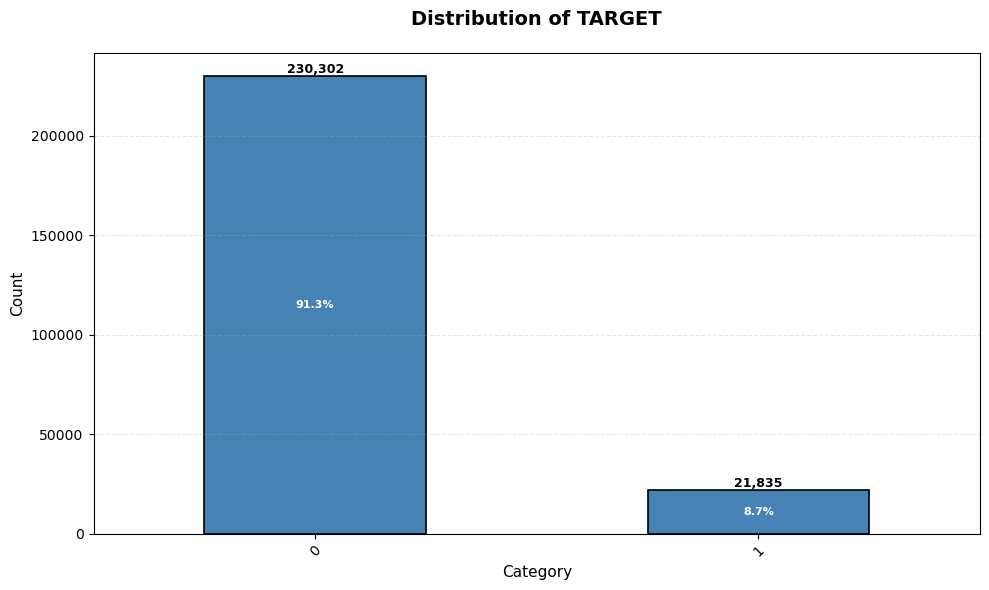

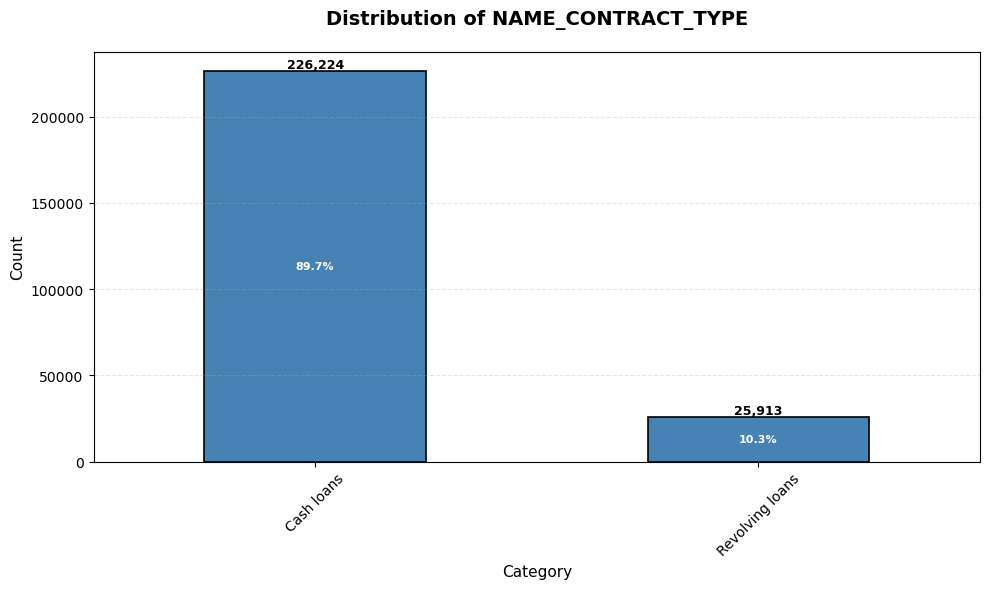

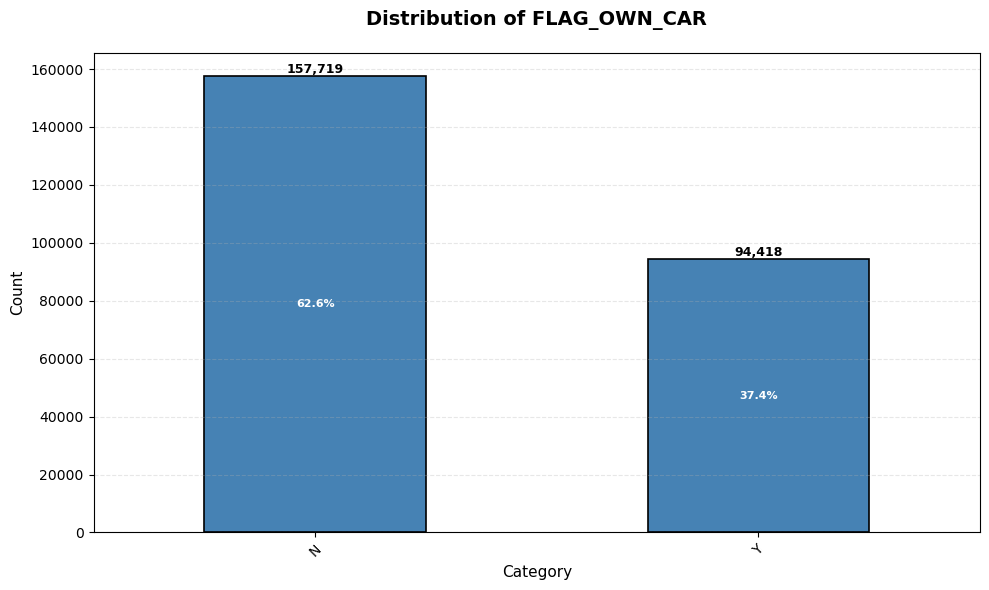

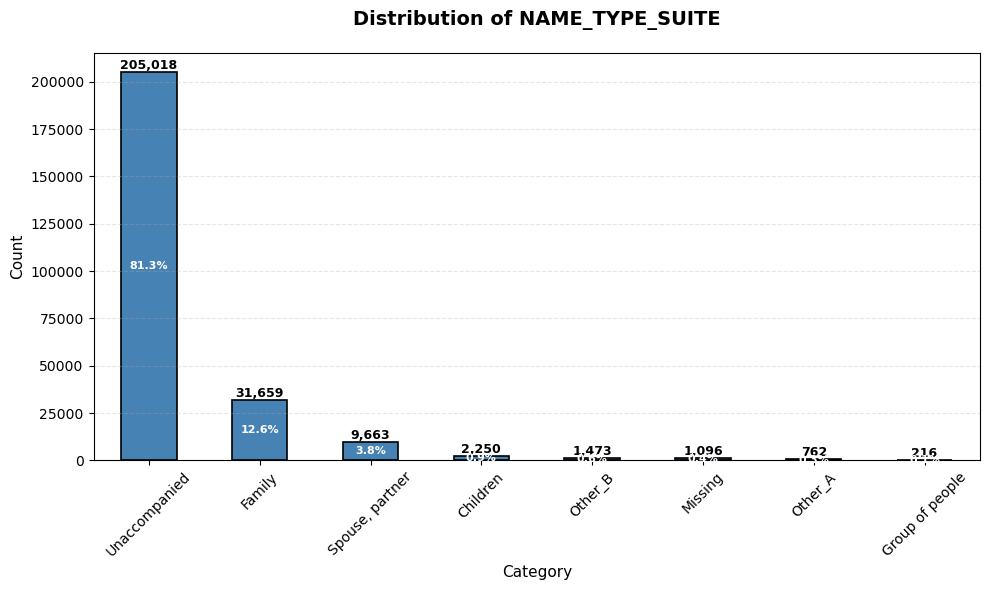

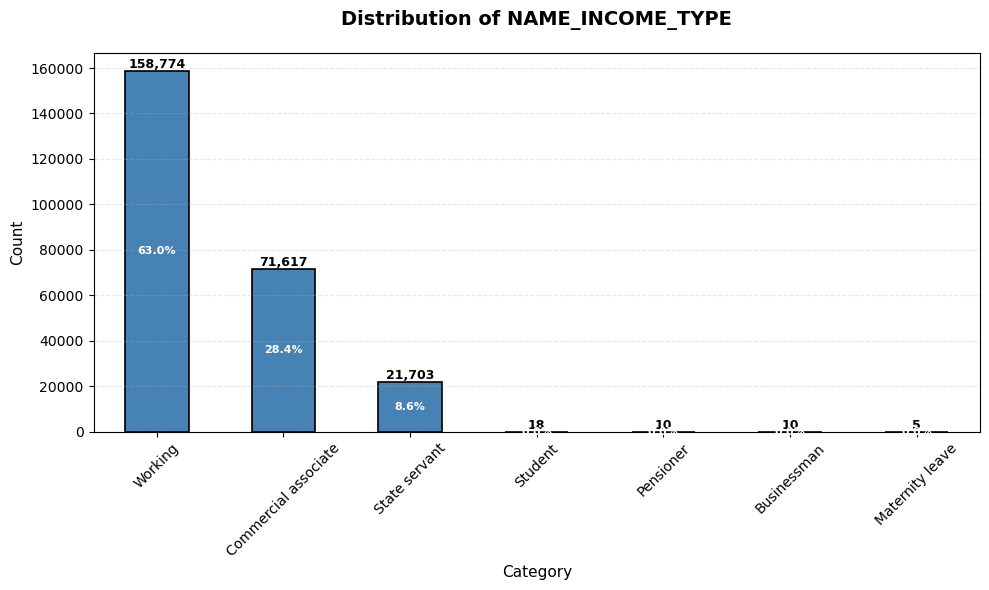

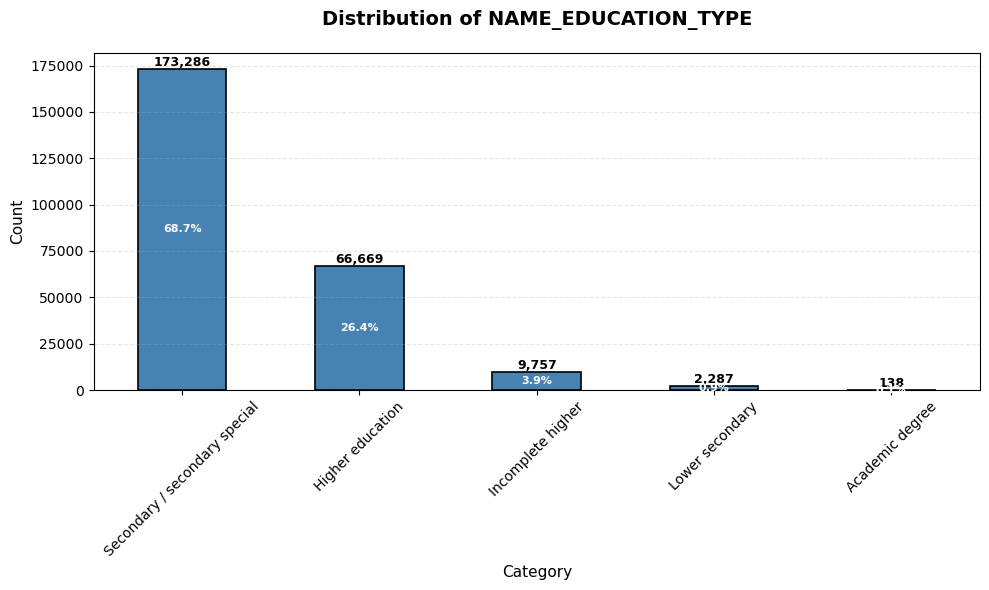

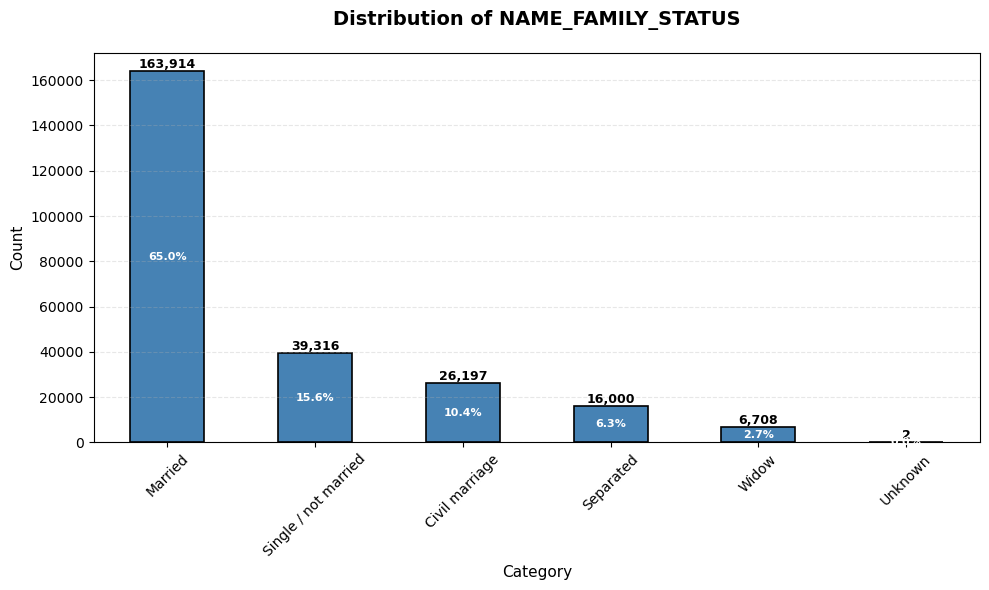

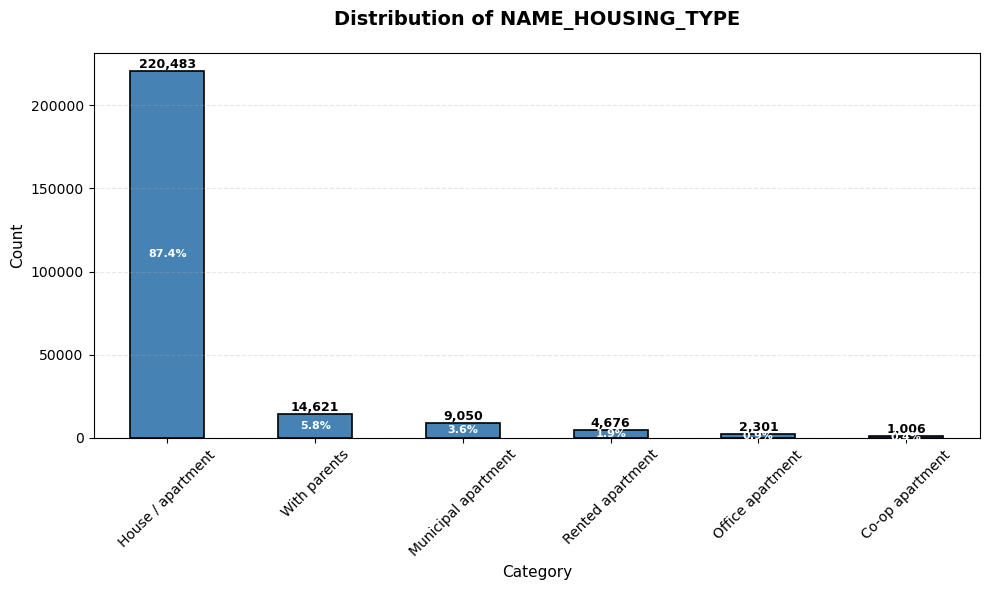

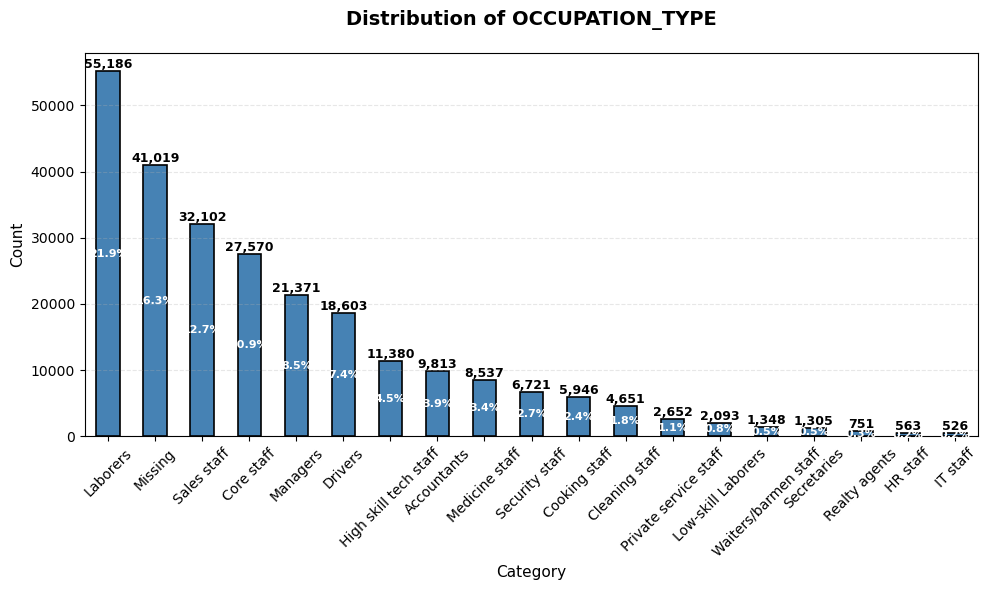

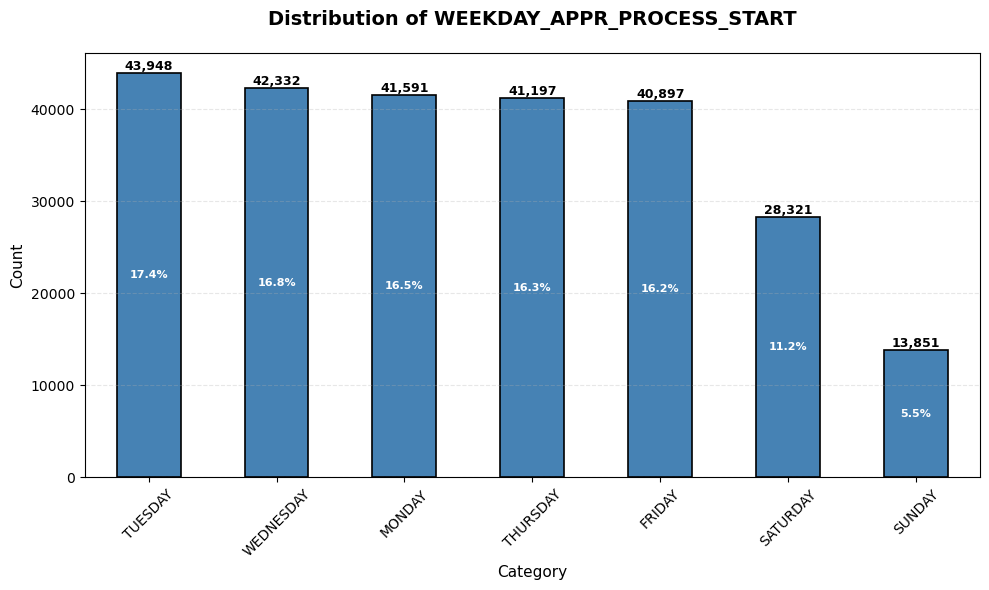

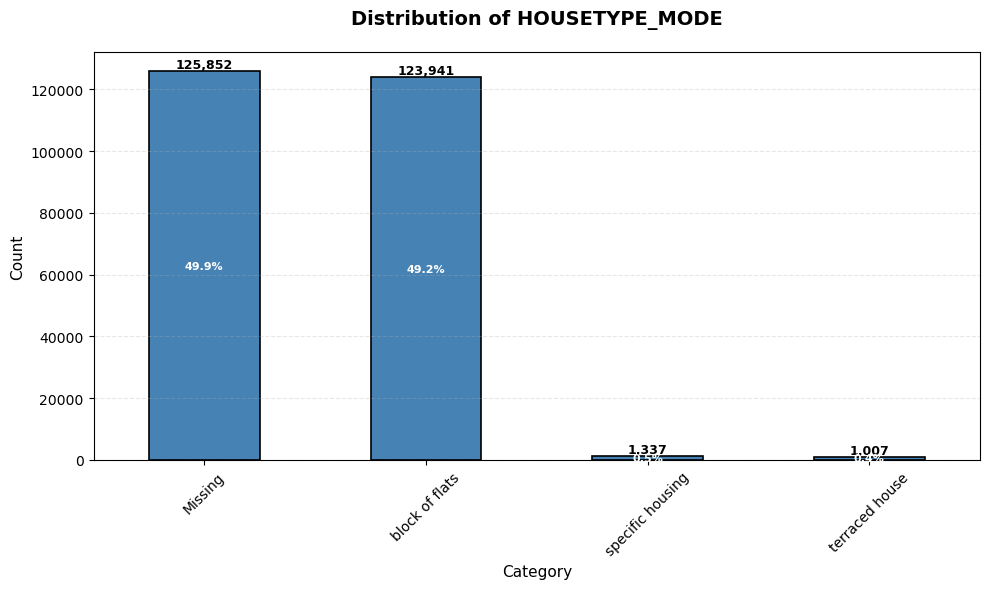

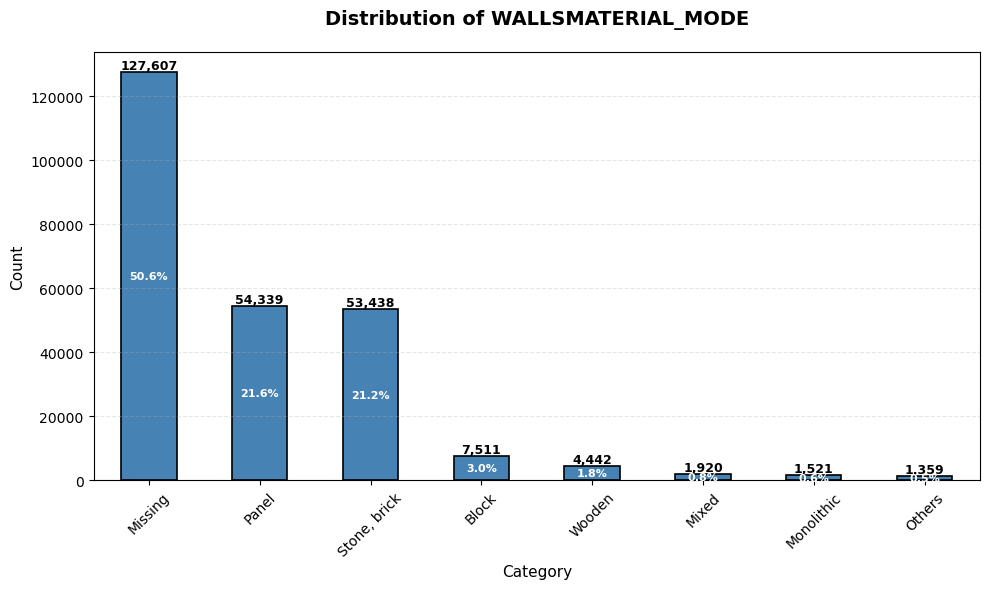

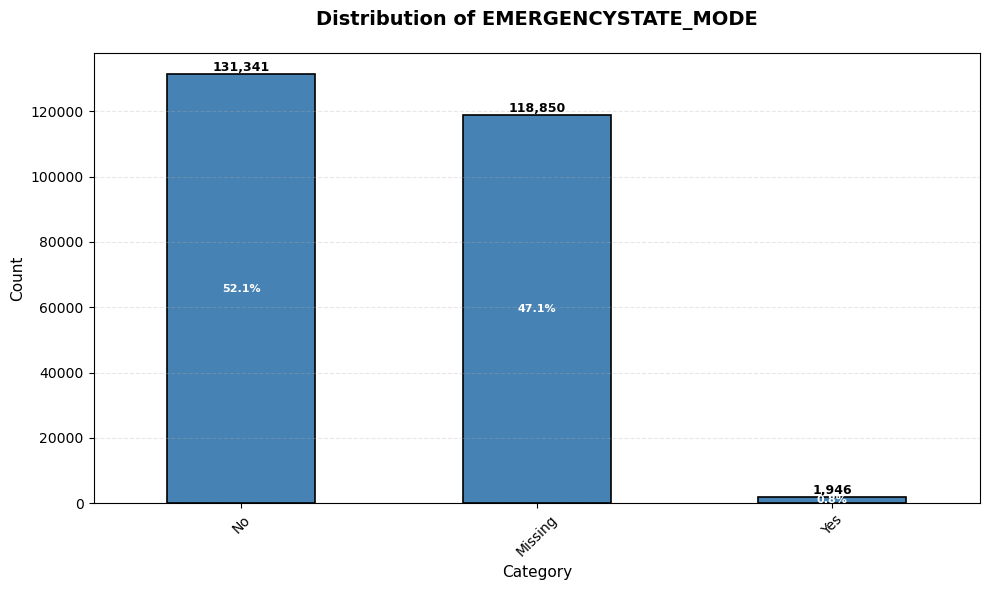

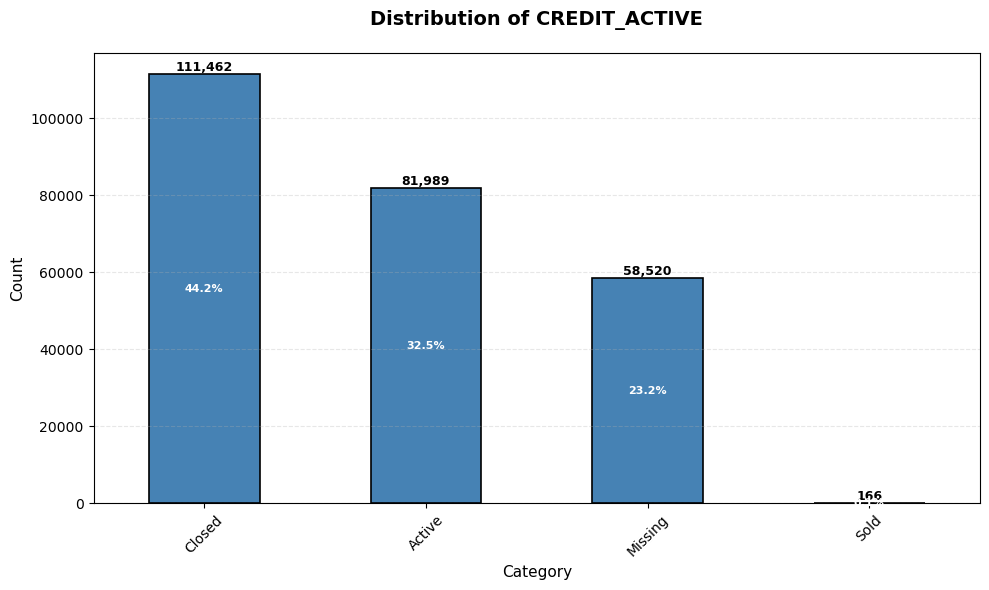

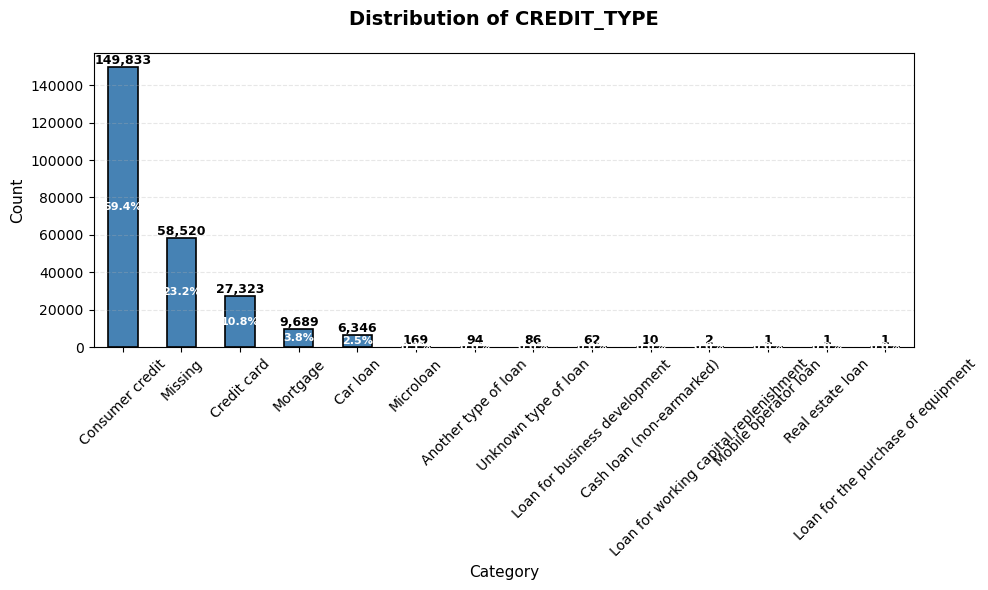


CATEGORICAL VARIABLES SUMMARY

TARGET:
  Unique values: 2
  Missing: 0
  Value counts:
    0: 230,302 (91.34%)
    1: 21,835 (8.66%)

NAME_CONTRACT_TYPE:
  Unique values: 2
  Missing: 0
  Value counts:
    Cash loans: 226,224 (89.72%)
    Revolving loans: 25,913 (10.28%)

FLAG_OWN_CAR:
  Unique values: 2
  Missing: 0
  Value counts:
    N: 157,719 (62.55%)
    Y: 94,418 (37.45%)

NAME_TYPE_SUITE:
  Unique values: 8
  Missing: 0
  Value counts:
    Unaccompanied: 205,018 (81.31%)
    Family: 31,659 (12.56%)
    Spouse, partner: 9,663 (3.83%)
    Children: 2,250 (0.89%)
    Other_B: 1,473 (0.58%)
    Missing: 1,096 (0.43%)
    Other_A: 762 (0.30%)
    Group of people: 216 (0.09%)

NAME_INCOME_TYPE:
  Unique values: 7
  Missing: 0
  Value counts:
    Working: 158,774 (62.97%)
    Commercial associate: 71,617 (28.40%)
    State servant: 21,703 (8.61%)
    Student: 18 (0.01%)
    Pensioner: 10 (0.00%)
    Businessman: 10 (0.00%)
    Maternity leave: 5 (0.00%)

NAME_EDUCATION_TYPE:
  Unique

In [22]:
print("="*80)
print("CATEGORICAL VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS")
print("="*80)

# List of categorical columns
categorical_columns = ['SK_ID_CURR', 'TARGET',
    'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE', 'CREDIT_ACTIVE','CREDIT_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY']

# Filter to only columns that exist in the dataframe
categorical_columns = [col for col in categorical_columns if col in df_merged_cleaned.columns]

# Set limits
MAX_UNIQUE_VALUES = 20  # Skip columns with more than 20 unique values
MAX_PLOTS = 15  # Only show first 15 plots

print(f"Total categorical columns available: {len(categorical_columns)}")
print(f"Limits: Max {MAX_UNIQUE_VALUES} unique values per column, Max {MAX_PLOTS} plots\n")

# Filter columns based on unique value count
columns_to_plot = []
for col in categorical_columns:
    unique_count = df_merged_cleaned[col].nunique()
    if unique_count <= MAX_UNIQUE_VALUES:
        columns_to_plot.append(col)
    else:
        print(f"⊘ Skipping '{col}' - has {unique_count} unique values (exceeds limit of {MAX_UNIQUE_VALUES})")

# Limit to MAX_PLOTS
columns_to_plot = columns_to_plot[:MAX_PLOTS]
print(f"\nVisualizing {len(columns_to_plot)} columns\n")

# Create a new DataFrame with only the categorical columns
categorical_df_filtered = df_merged_cleaned[columns_to_plot].copy()

# Visualize each categorical variable individually
for col in columns_to_plot:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    value_counts = categorical_df_filtered[col].value_counts()
    
    # Create bar plot
    value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', linewidth=1.2)
    
    # Customize plot
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Category', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on top of bars
    for i, v in enumerate(value_counts):
        ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add percentage labels
    total = value_counts.sum()
    for i, v in enumerate(value_counts):
        pct = (v / total) * 100
        ax.text(i, v/2, f'{pct:.1f}%', ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Print summary
print("\n" + "="*80)
print("CATEGORICAL VARIABLES SUMMARY")
print("="*80)

for col in columns_to_plot:
    print(f"\n{col}:")
    print(f"  Unique values: {categorical_df_filtered[col].nunique()}")
    print(f"  Missing: {categorical_df_filtered[col].isnull().sum()}")
    print(f"  Value counts:")
    value_counts = categorical_df_filtered[col].value_counts()
    for value, count in value_counts.items():
        pct = (count / len(categorical_df_filtered)) * 100
        print(f"    {value}: {count:,} ({pct:.2f}%)")

print("\n✓ All visualizations complete!")

NUMERIC VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS
Total numeric columns to visualize: 16



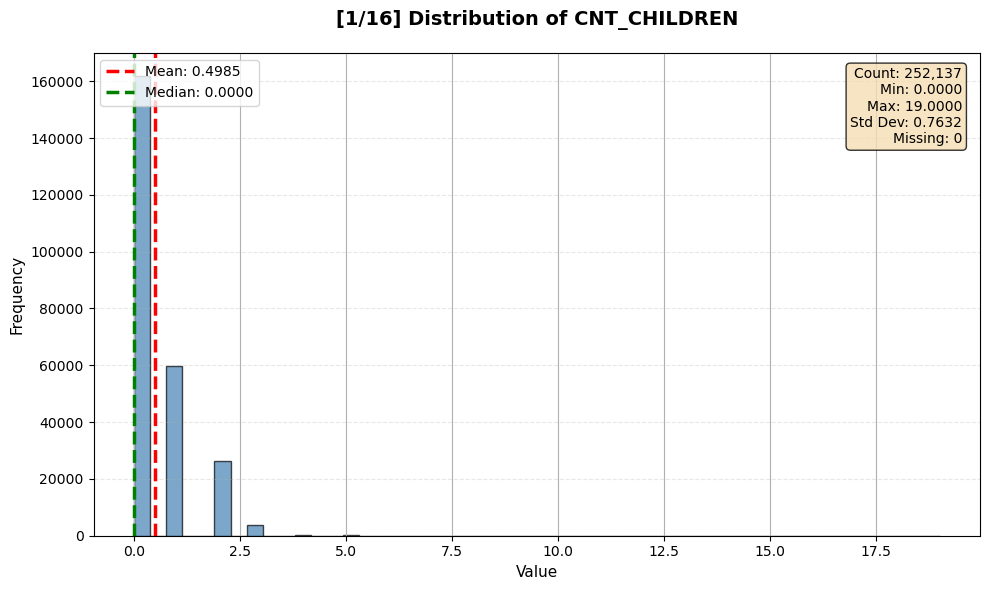

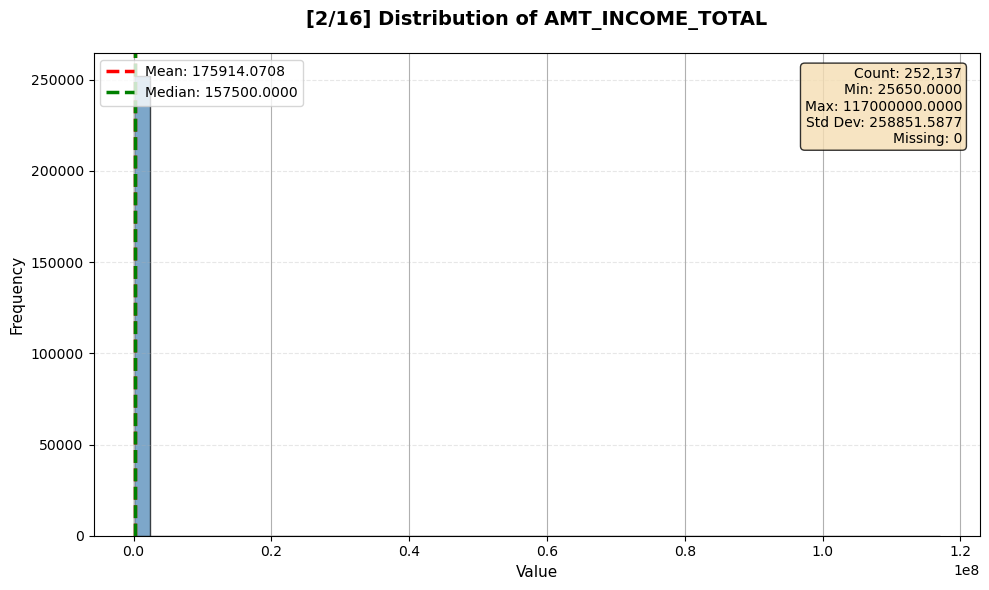

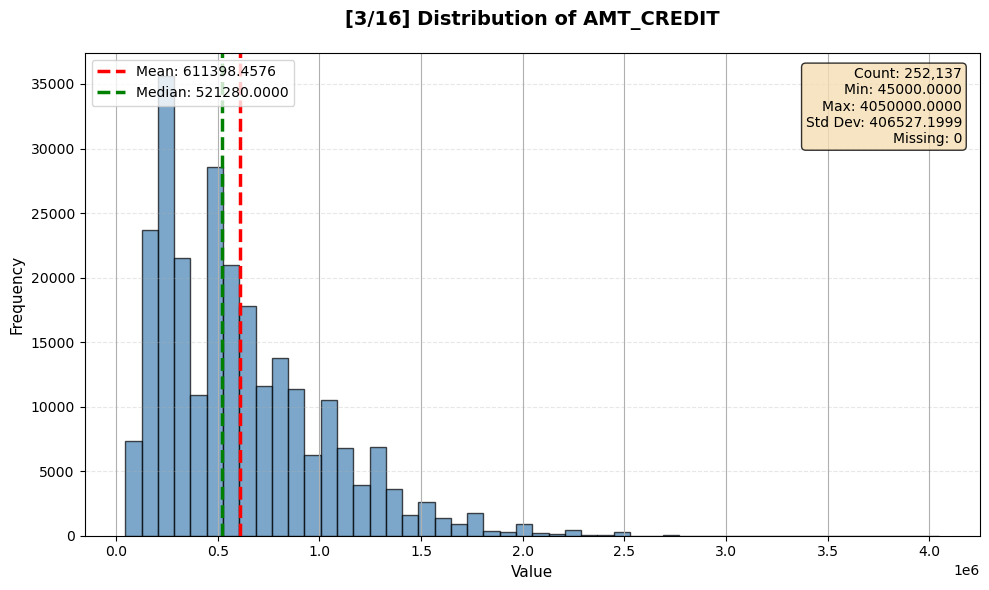

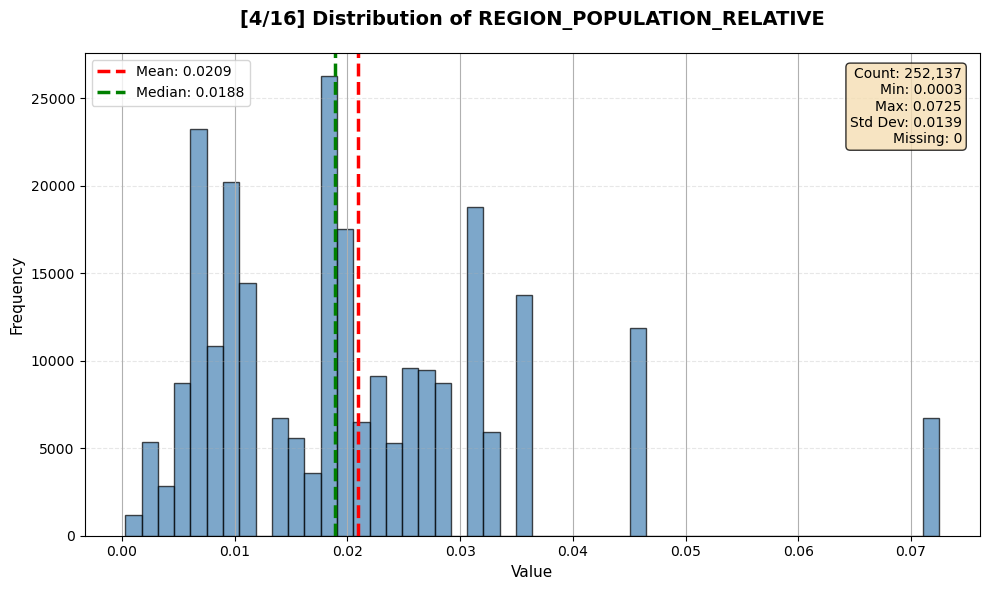

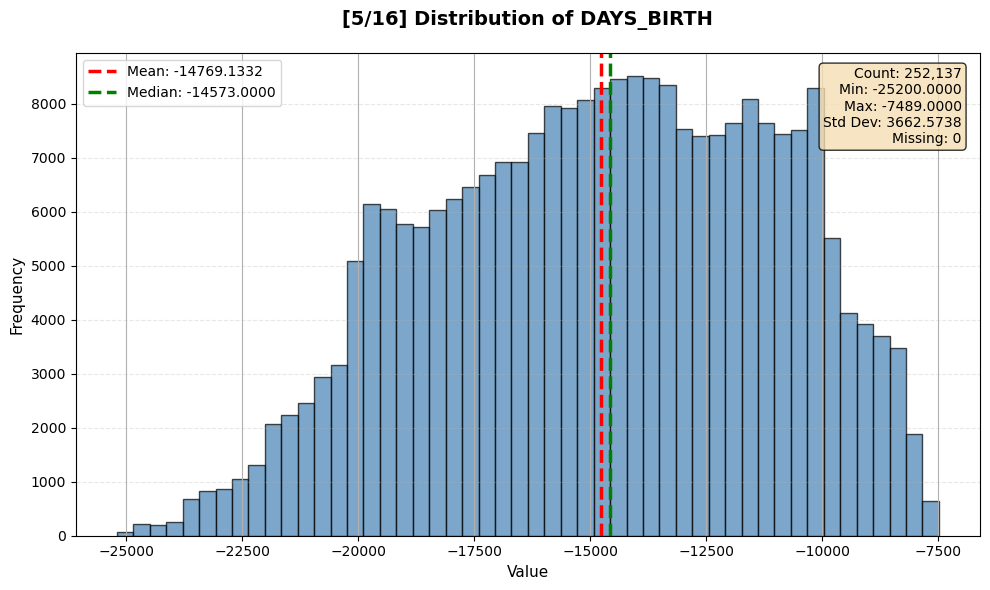

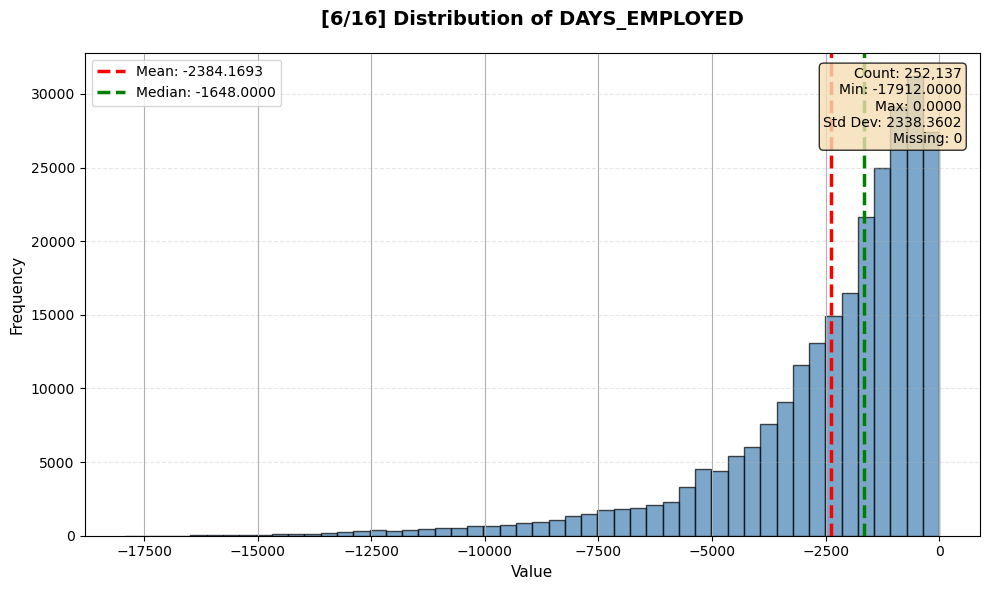

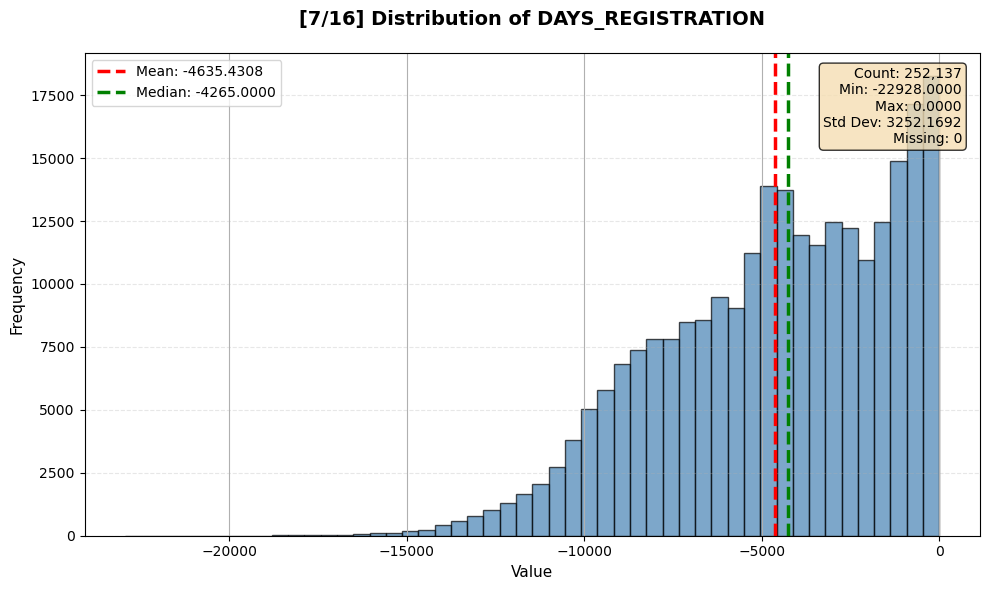

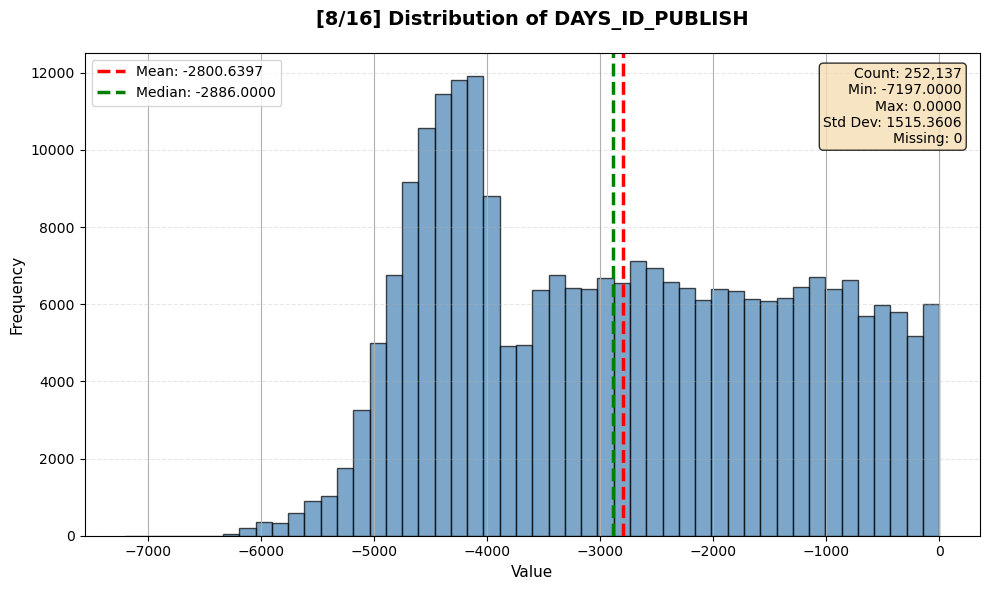

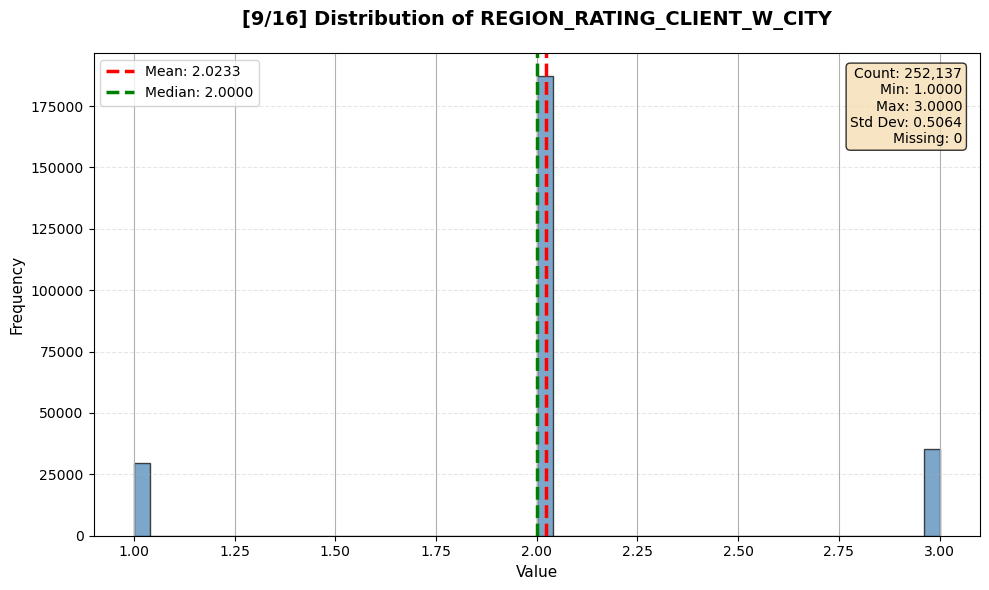

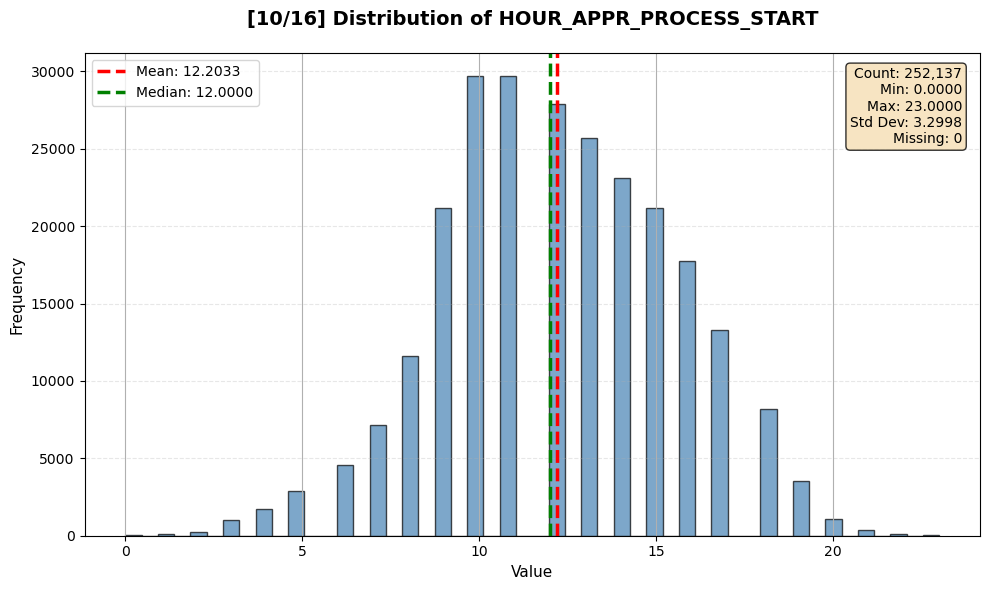

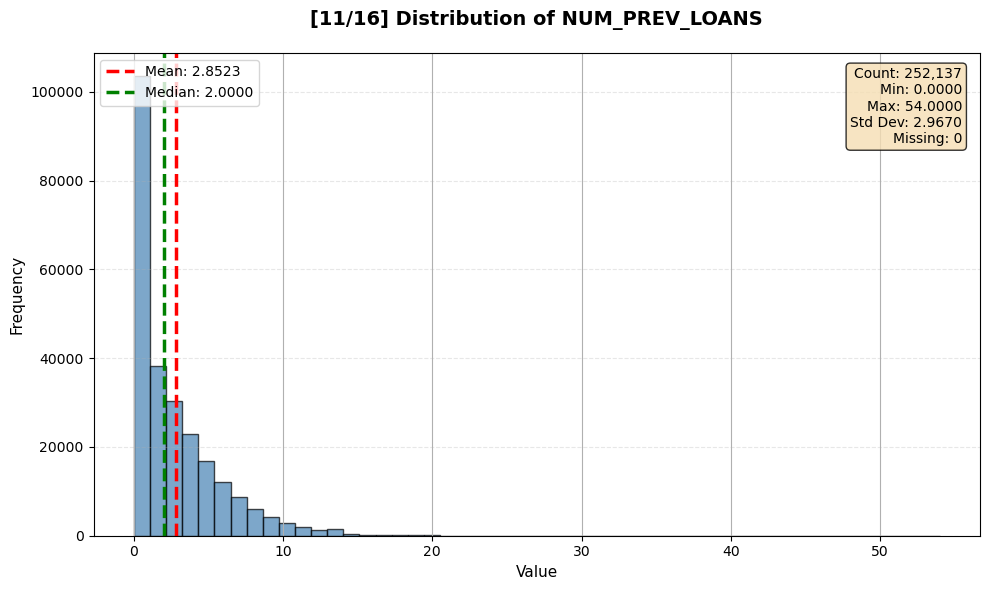

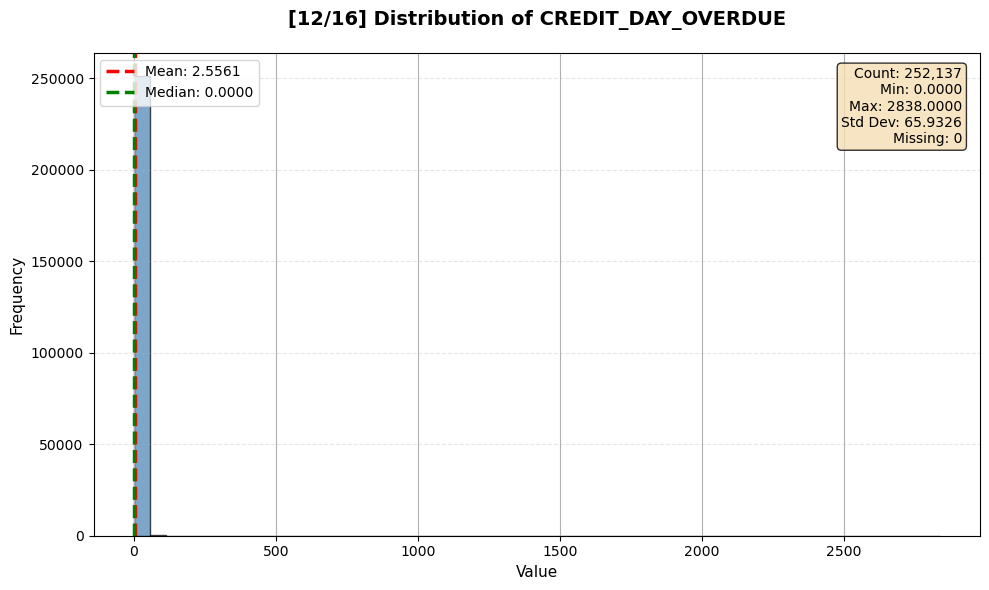

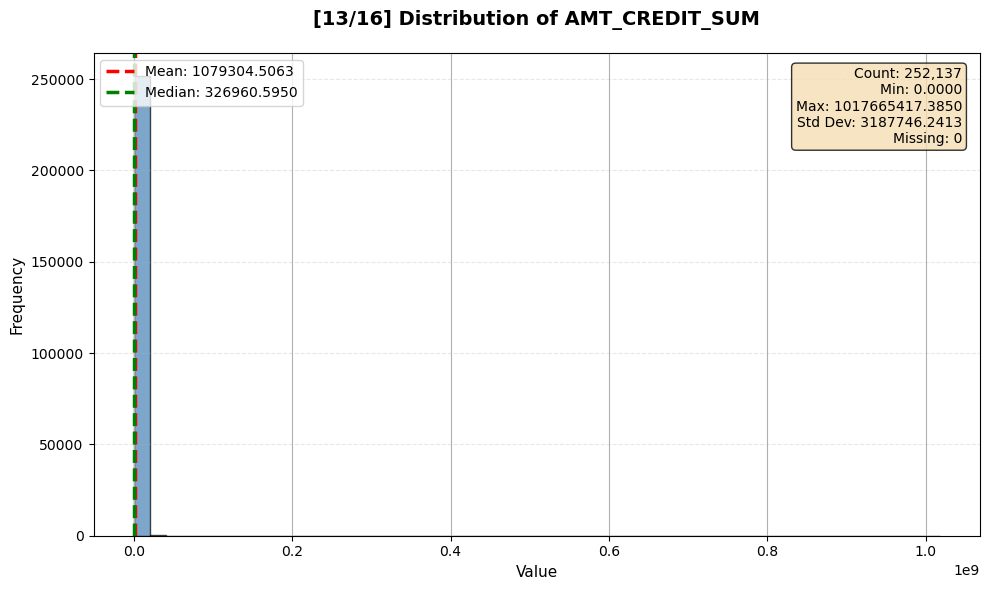

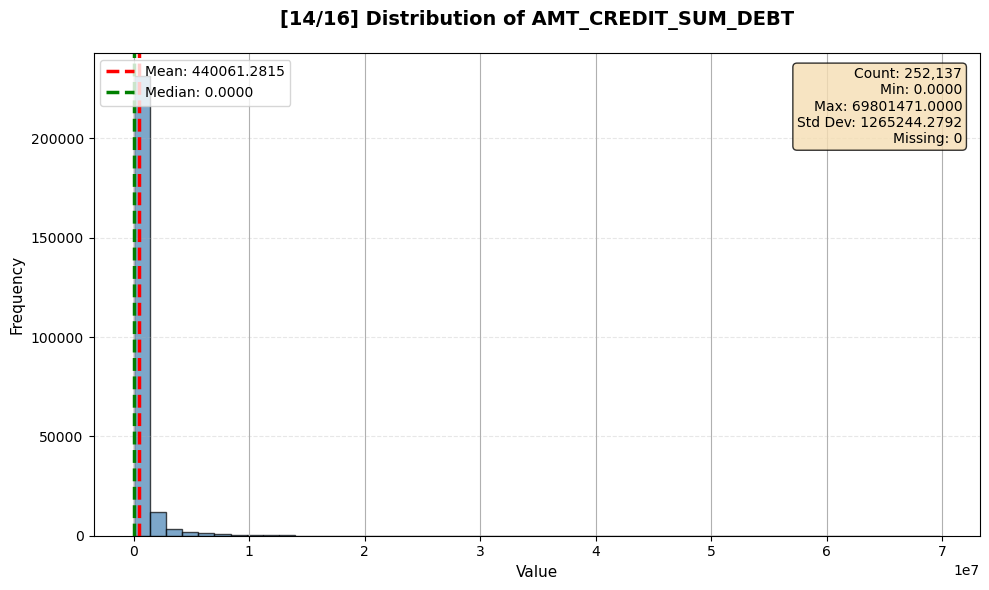

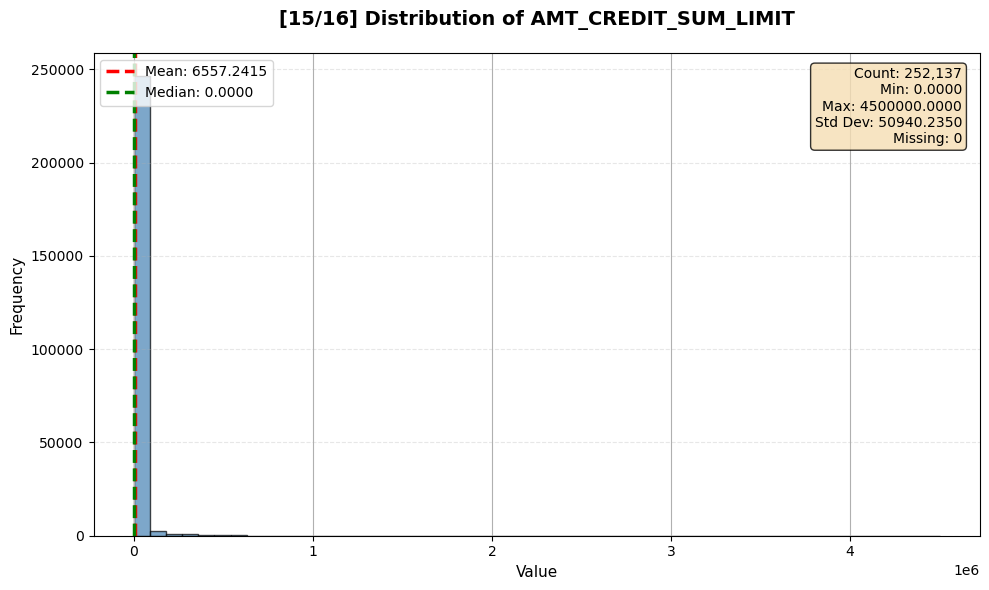

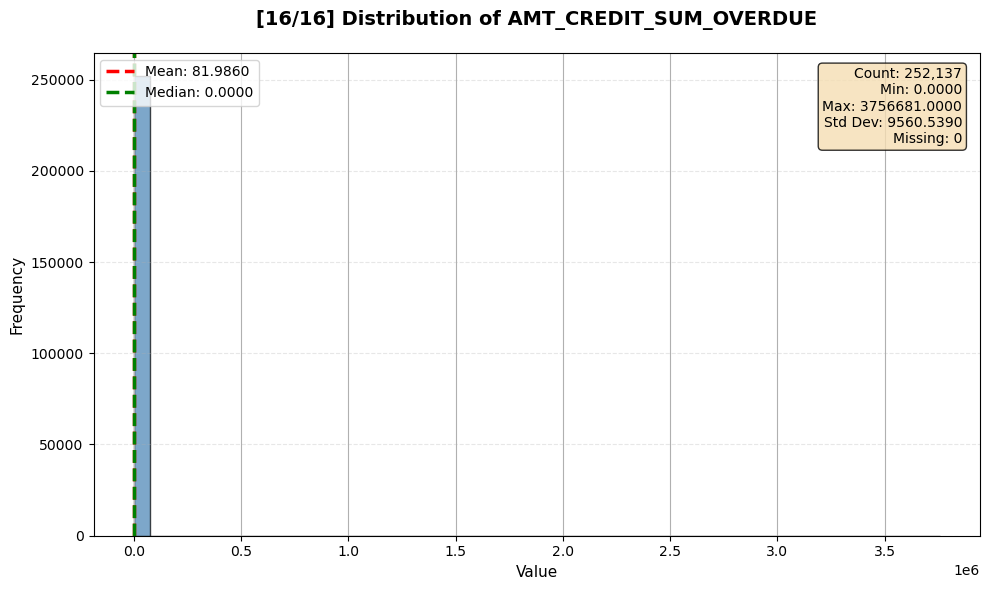


✓ All 16 visualizations complete!


In [23]:
print("="*80)
print("NUMERIC VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS")
print("="*80)

# Get all numeric columns
numeric_var_merged = df_merged_cleaned.select_dtypes(include=['number']).columns.tolist()

# Remove columns that are already in categorical_columns
numeric_var_filtered = [col for col in numeric_var_merged if col not in categorical_columns]

print(f"Total numeric columns to visualize: {len(numeric_var_filtered)}\n")

# Visualize each numeric variable individually
for idx, col in enumerate(numeric_var_filtered, 1):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create histogram
    df_merged_cleaned[col].hist(ax=ax, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    
    # Customize plot
    ax.set_title(f'[{idx}/{len(numeric_var_filtered)}] Distribution of {col}', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add statistics
    mean = df_merged_cleaned[col].mean()
    median = df_merged_cleaned[col].median()
    std = df_merged_cleaned[col].std()
    
    ax.axvline(mean, color='red', linestyle='--', linewidth=2.5, label=f'Mean: {mean:.4f}')
    ax.axvline(median, color='green', linestyle='--', linewidth=2.5, label=f'Median: {median:.4f}')
    
    # Add stats box
    stats_text = (f"Count: {df_merged_cleaned[col].count():,.0f}\n"
                 f"Min: {df_merged_cleaned[col].min():.4f}\n"
                 f"Max: {df_merged_cleaned[col].max():.4f}\n"
                 f"Std Dev: {std:.4f}\n"
                 f"Missing: {df_merged_cleaned[col].isnull().sum():,.0f}")
    
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print(f"\n✓ All {len(numeric_var_filtered)} visualizations complete!")

In [24]:
print("="*80)
print("DROPPING CATEGORICAL VARIABLES WITH NO VARIATION")
print("="*80)

# Use your defined categorical_columns list
categorical_columns = ['SK_ID_CURR', 'TARGET',
    'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE', 'CREDIT_ACTIVE','CREDIT_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY']

# Filter to only columns that exist in the dataframe
categorical_columns_existing = [col for col in categorical_columns if col in df_merged_cleaned.columns]

print(f"Total categorical columns in your list: {len(categorical_columns)}")
print(f"Columns that exist in dataframe: {len(categorical_columns_existing)}")

# Find categorical columns with only 1 unique value
single_value_cols = []
for col in categorical_columns_existing:
    unique_count = df_merged_cleaned[col].nunique()
    if unique_count == 1:
        single_value_cols.append(col)
        unique_value = df_merged_cleaned[col].unique()[0]
        print(f"  Dropping: {col} (only 1 unique value: '{unique_value}')")

# Drop columns with no variation
df_merged_cleaned = df_merged_cleaned.drop(columns=single_value_cols)

print("\n" + "="*80)
print("COLUMN REMOVAL SUMMARY")
print("="*80)

print(f"\nCategorical columns with no variation: {len(single_value_cols)}")
if len(single_value_cols) > 0:
    print(f"Columns dropped:")
    for col in single_value_cols:
        print(f"  - {col}")
else:
    print("No categorical columns with no variation found ✓")

# Display remaining categorical columns from your list
remaining_categorical = [col for col in categorical_columns_existing if col in df_merged_cleaned.columns]
print(f"\nRemaining categorical columns ({len(remaining_categorical)}):")
for col in remaining_categorical:
    unique_count = df_merged_cleaned[col].nunique()
    print(f"  - {col}: {unique_count} unique values")

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nShape before: (previous) rows × columns")
print(f"Shape after: {df_merged_cleaned.shape[0]:,} rows × {df_merged_cleaned.shape[1]} columns")
print(f"Columns dropped: {len(single_value_cols)}")

print(f"\nVariable name: df_merged_cleaned (updated)")
print(f"Final shape: {df_merged_cleaned.shape}")
print(f"✓ Categorical variables with no variation have been removed!")

DROPPING CATEGORICAL VARIABLES WITH NO VARIATION
Total categorical columns in your list: 47
Columns that exist in dataframe: 47

COLUMN REMOVAL SUMMARY

Categorical columns with no variation: 0
No categorical columns with no variation found ✓

Remaining categorical columns (47):
  - SK_ID_CURR: 252137 unique values
  - TARGET: 2 unique values
  - NAME_CONTRACT_TYPE: 2 unique values
  - FLAG_OWN_CAR: 2 unique values
  - NAME_TYPE_SUITE: 8 unique values
  - NAME_INCOME_TYPE: 7 unique values
  - NAME_EDUCATION_TYPE: 5 unique values
  - NAME_FAMILY_STATUS: 6 unique values
  - NAME_HOUSING_TYPE: 6 unique values
  - OCCUPATION_TYPE: 19 unique values
  - WEEKDAY_APPR_PROCESS_START: 7 unique values
  - ORGANIZATION_TYPE: 57 unique values
  - HOUSETYPE_MODE: 4 unique values
  - WALLSMATERIAL_MODE: 8 unique values
  - EMERGENCYSTATE_MODE: 3 unique values
  - CREDIT_ACTIVE: 4 unique values
  - CREDIT_TYPE: 14 unique values
  - FLAG_MOBIL: 2 unique values
  - FLAG_EMP_PHONE: 2 unique values
  - FL

BOXPLOT DISTRIBUTION OF NUMERIC VARIABLES (INDIVIDUAL FIGURES)
Total numeric columns: 48
Columns in categorical list: 47
Numeric columns to visualize: 16



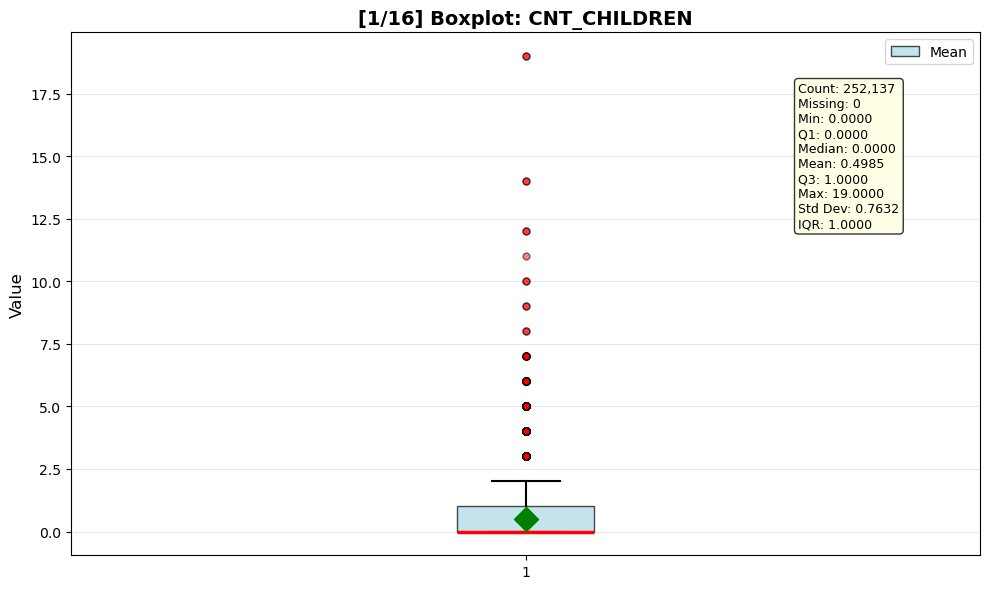

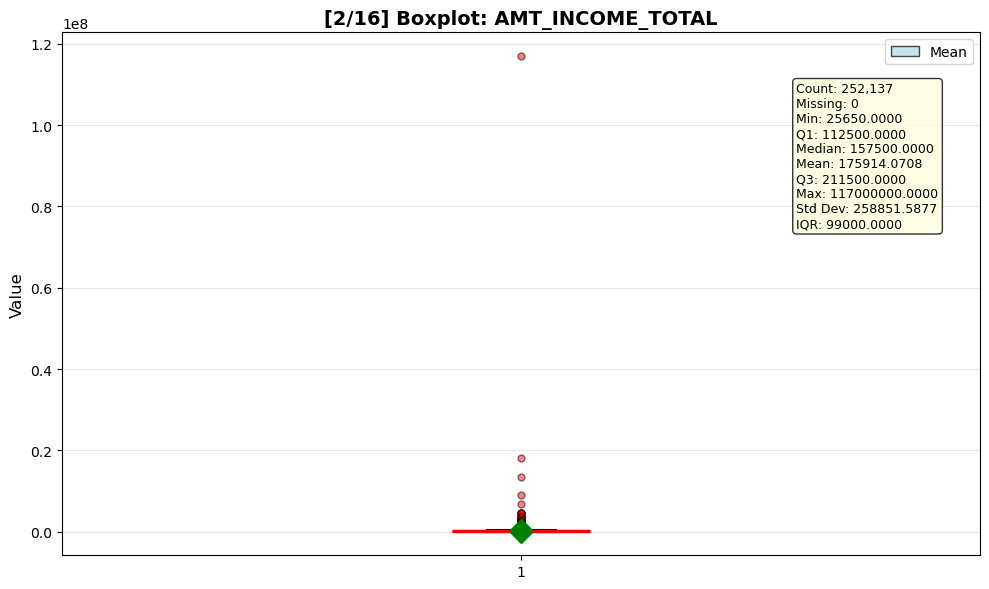

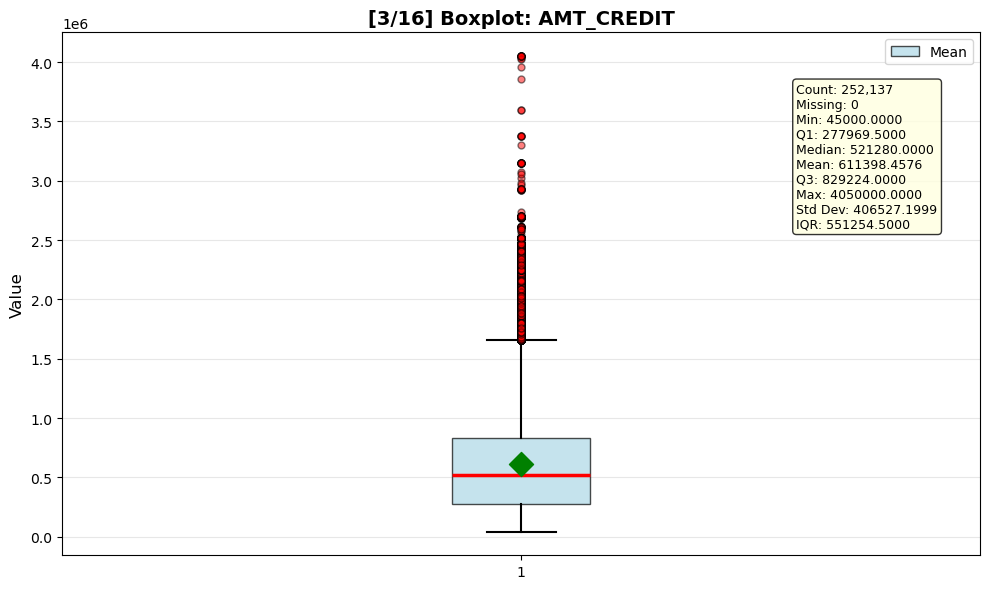

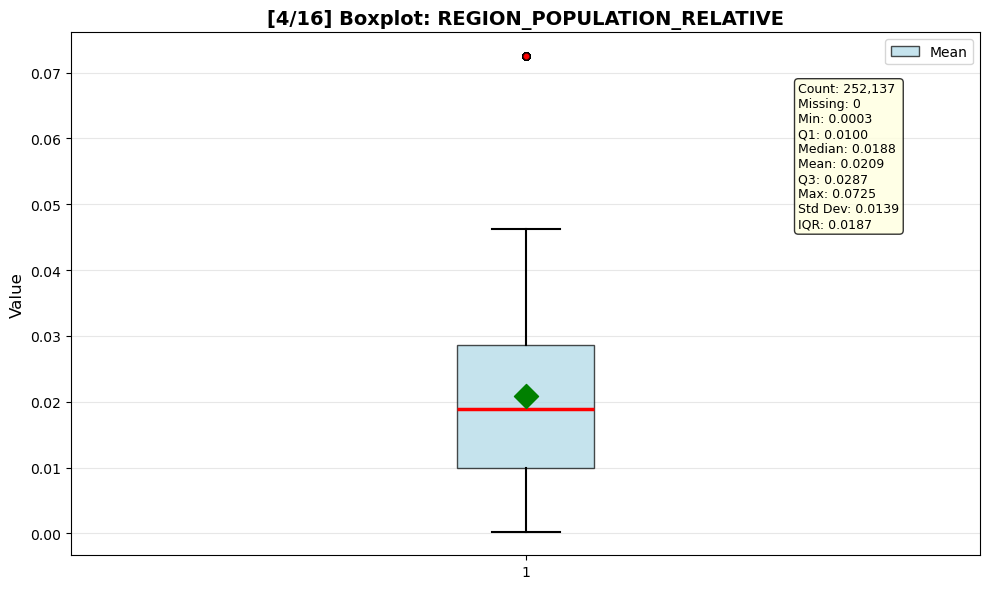

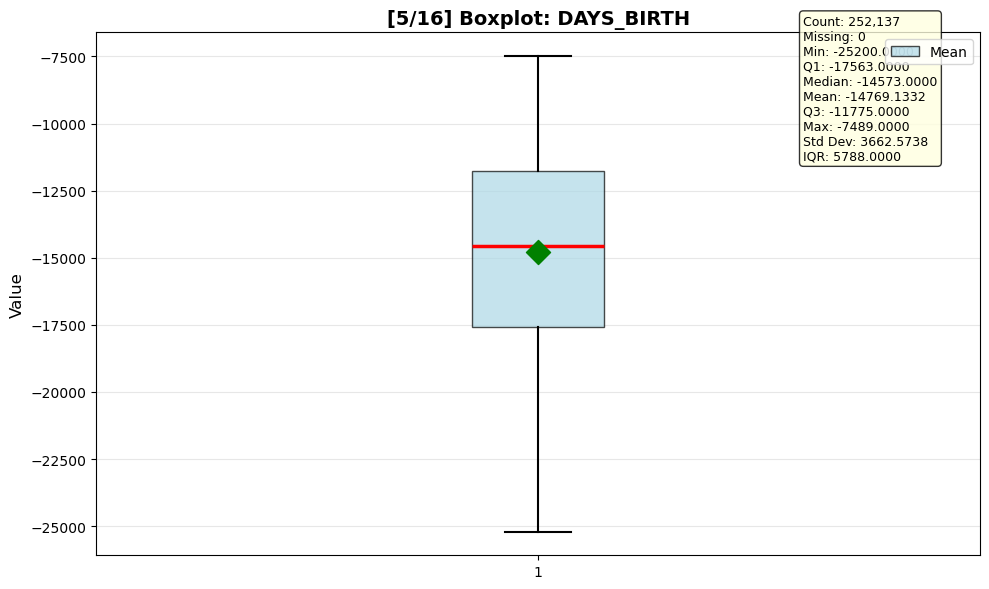

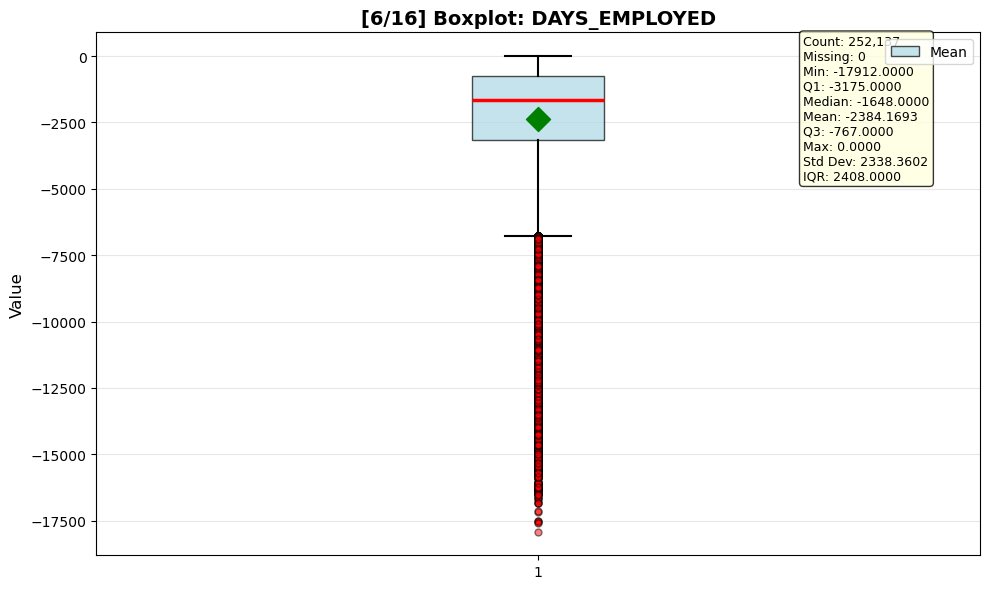

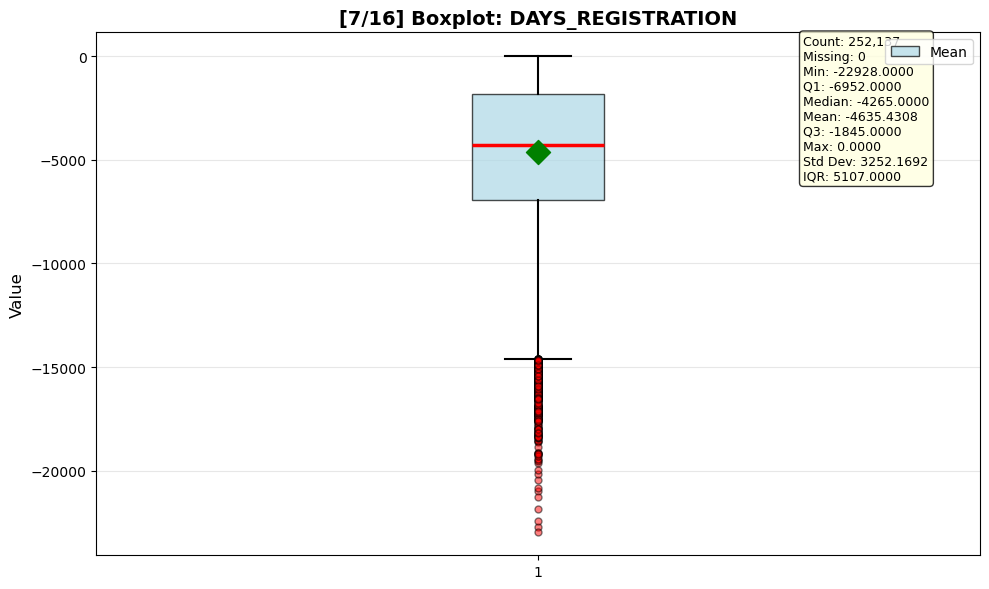

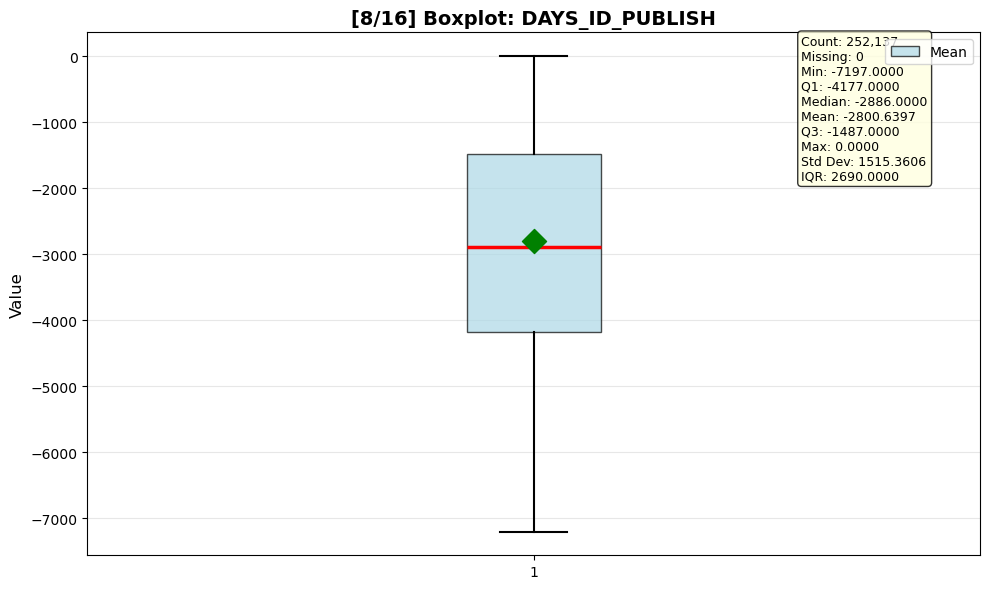

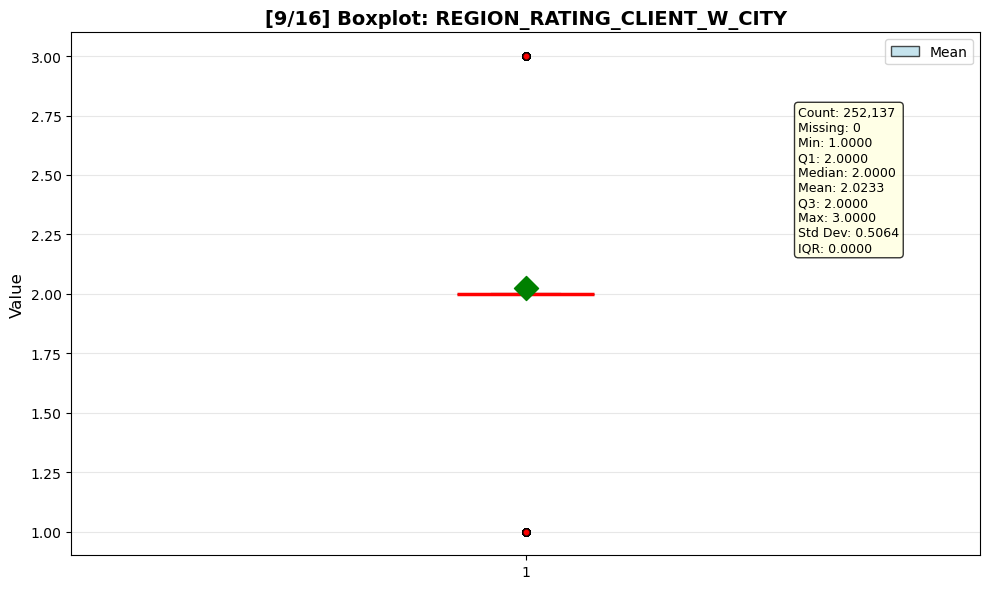

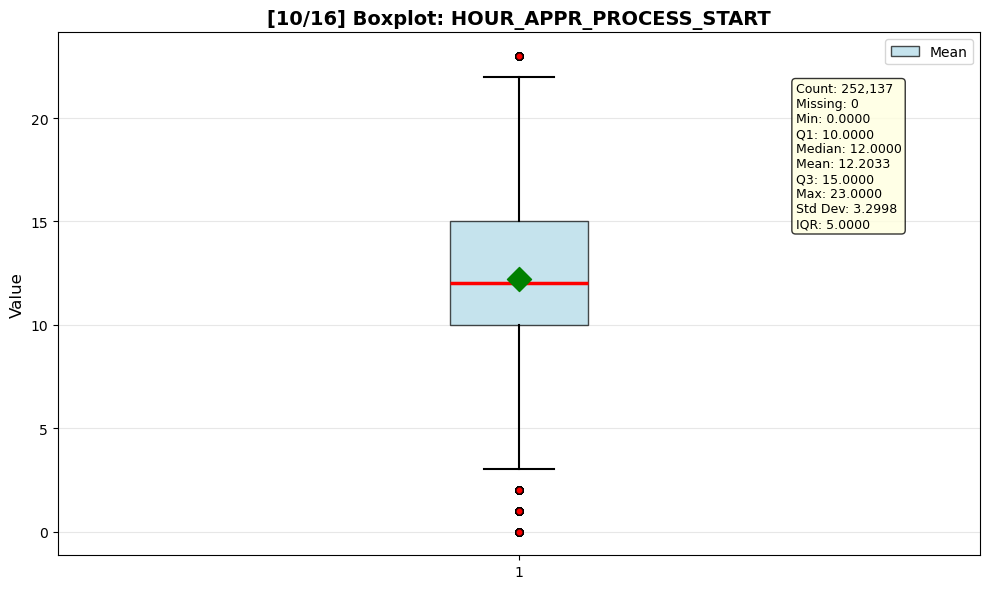

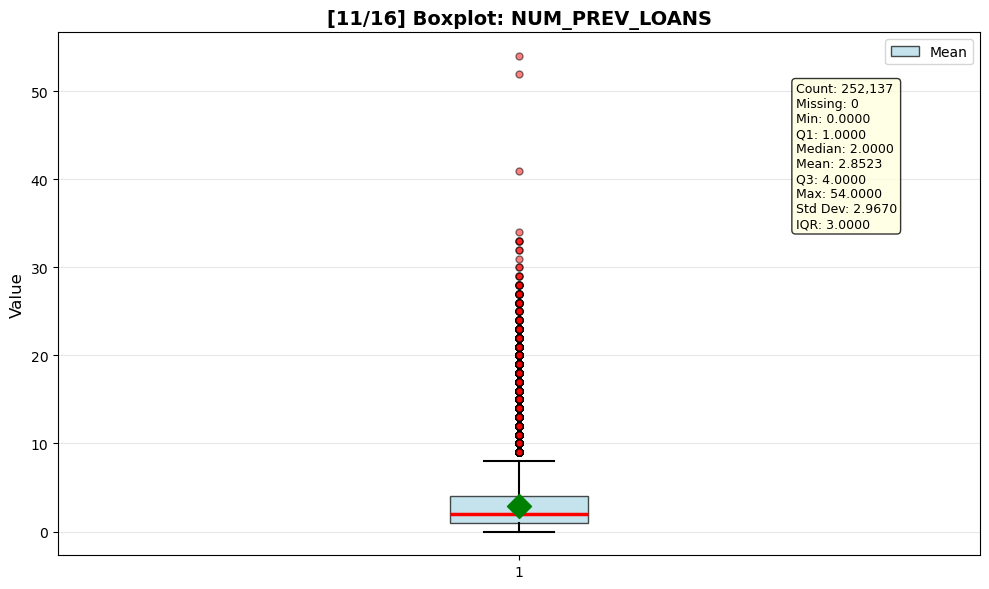

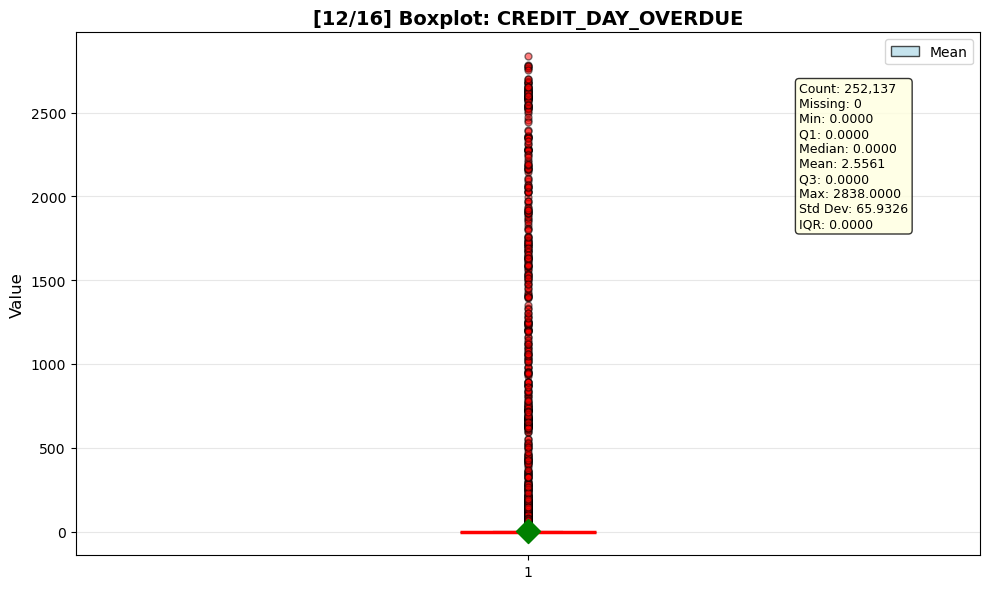

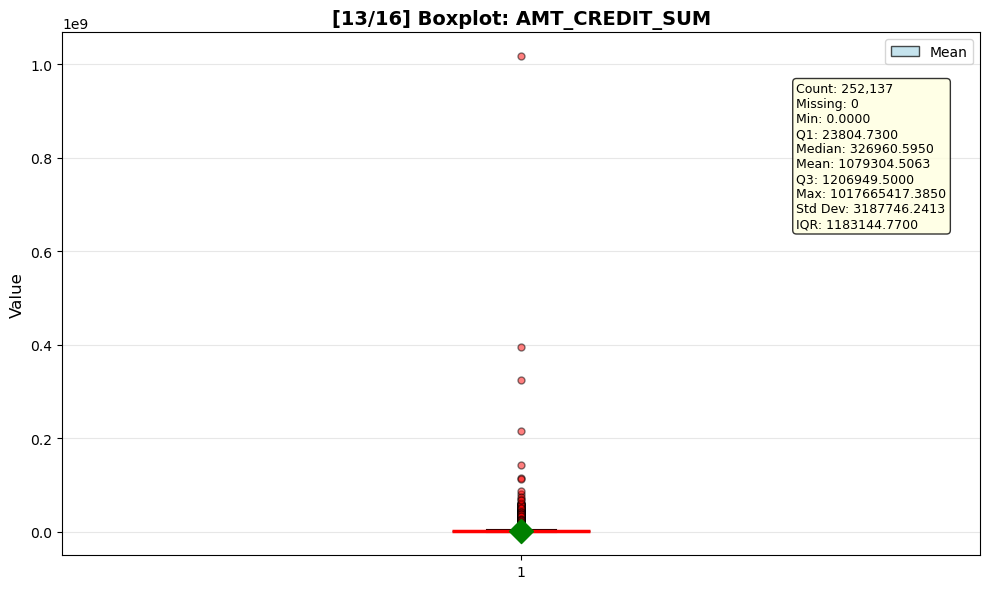

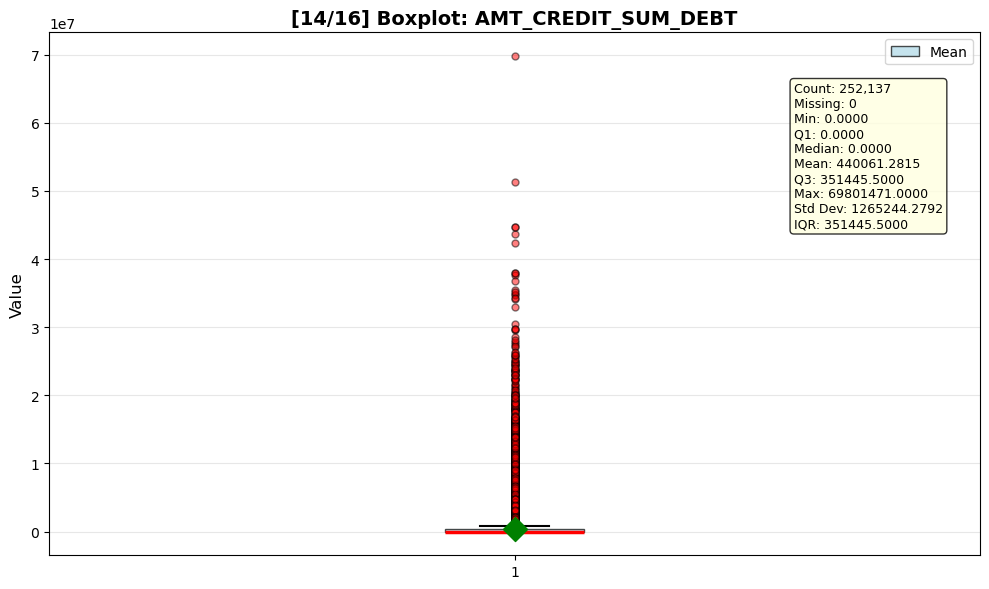

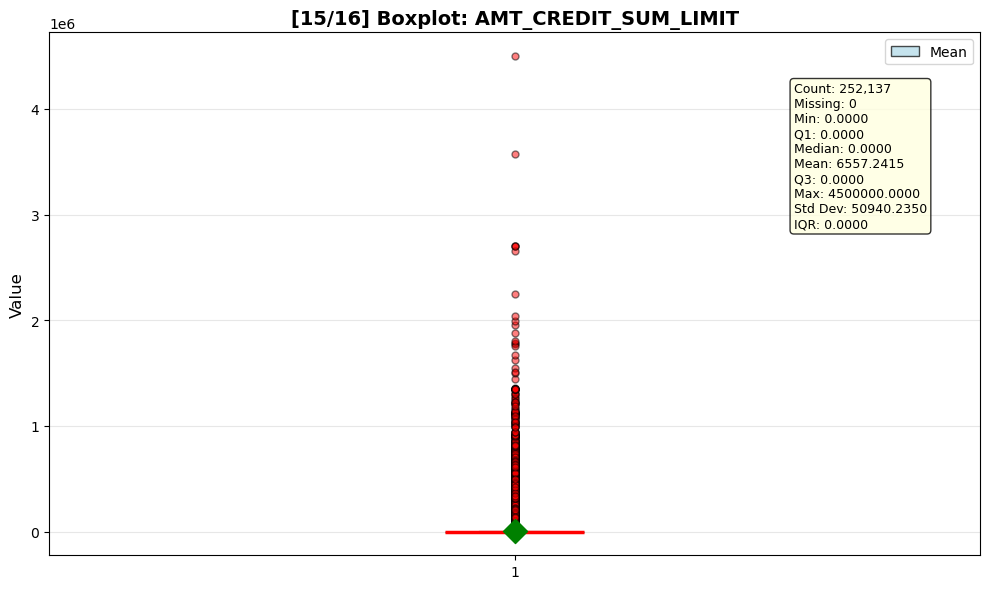

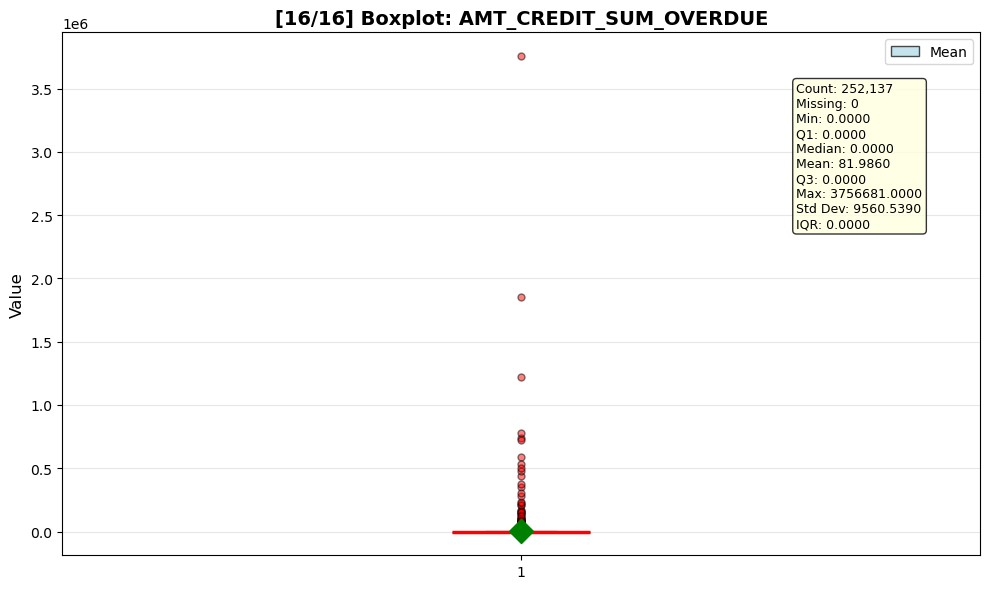


✓ All 16 boxplots created!


In [25]:
print("="*80)
print("BOXPLOT DISTRIBUTION OF NUMERIC VARIABLES (INDIVIDUAL FIGURES)")
print("="*80)

# Get numeric variables
numeric_var_merged = df_merged_cleaned.select_dtypes(include=['number']).columns.tolist()

# Exclude columns that are in categorical_columns list
visualization_cols = [col for col in numeric_var_merged if col not in categorical_columns]

print(f"Total numeric columns: {len(numeric_var_merged)}")
print(f"Columns in categorical list: {len(categorical_columns)}")
print(f"Numeric columns to visualize: {len(visualization_cols)}\n")

# Create individual boxplots
for idx, col in enumerate(visualization_cols, 1):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create boxplot
    bp = ax.boxplot(df_merged_cleaned[col].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
    
    # Add mean marker
    mean_val = df_merged_cleaned[col].mean()
    ax.scatter([1], [mean_val], color='green', s=150, marker='D', zorder=3, label='Mean')
    
    # Customize plot
    ax.set_title(f'[{idx}/{len(visualization_cols)}] Boxplot: {col}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(['Mean'], loc='upper right')
    
    # Add statistics
    stats_text = (f"Count: {df_merged_cleaned[col].count():,.0f}\n"
                 f"Missing: {df_merged_cleaned[col].isnull().sum():,.0f}\n"
                 f"Min: {df_merged_cleaned[col].min():.4f}\n"
                 f"Q1: {df_merged_cleaned[col].quantile(0.25):.4f}\n"
                 f"Median: {df_merged_cleaned[col].median():.4f}\n"
                 f"Mean: {mean_val:.4f}\n"
                 f"Q3: {df_merged_cleaned[col].quantile(0.75):.4f}\n"
                 f"Max: {df_merged_cleaned[col].max():.4f}\n"
                 f"Std Dev: {df_merged_cleaned[col].std():.4f}\n"
                 f"IQR: {df_merged_cleaned[col].quantile(0.75) - df_merged_cleaned[col].quantile(0.25):.4f}")
    
    ax.text(1.3, ax.get_ylim()[1] * 0.9, stats_text, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

print(f"\n✓ All {len(visualization_cols)} boxplots created!")

## Bivariate Analysis of Categorical Data

Total categorical columns to analyze: 45
Creating normalized stacked bar plots for bivariate analysis...



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


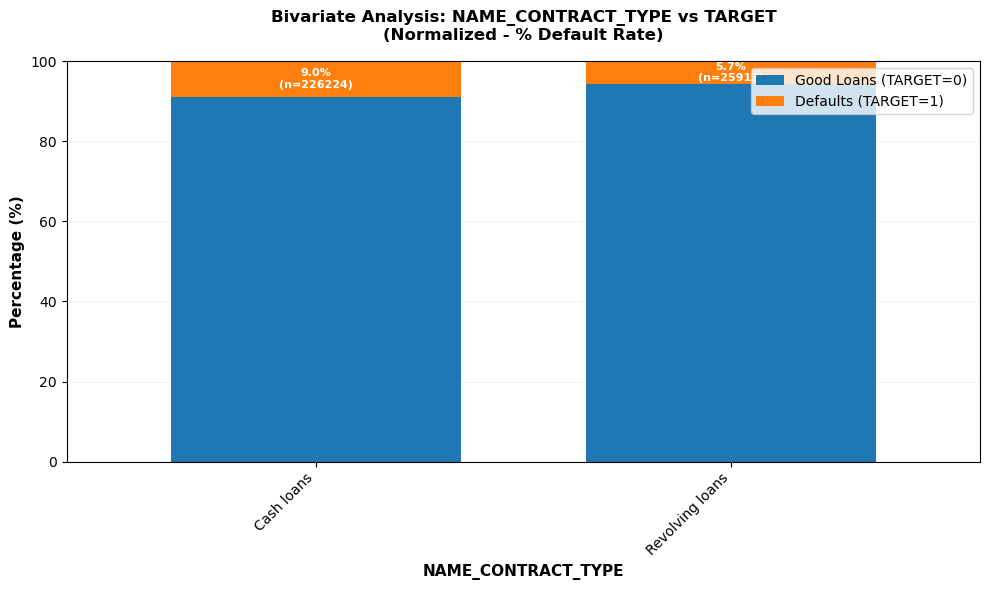

NAME_CONTRACT_TYPE:
  Categories: 2
  Default rate range: 5.65% - 9.00%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


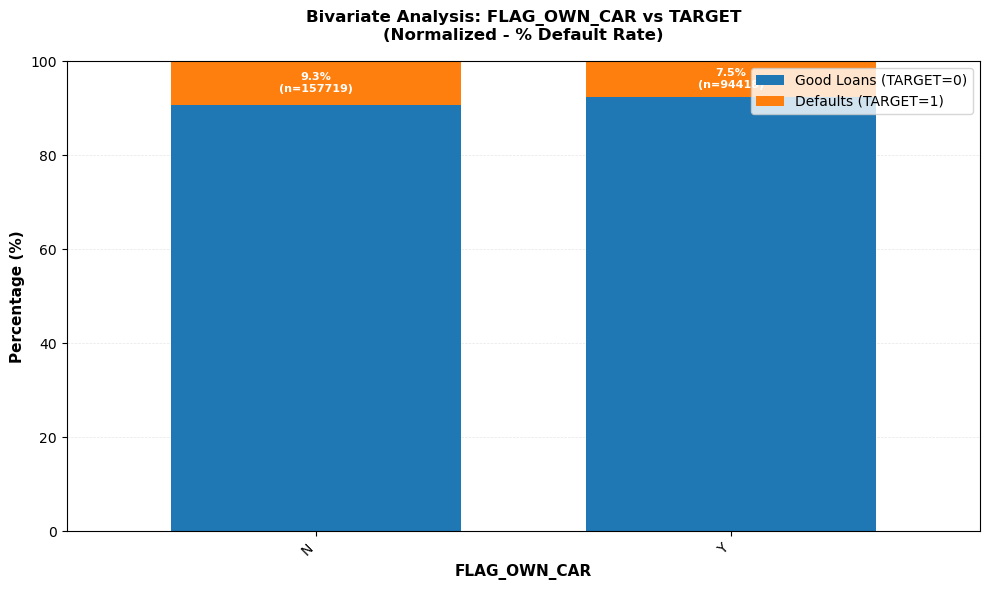

FLAG_OWN_CAR:
  Categories: 2
  Default rate range: 7.50% - 9.35%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


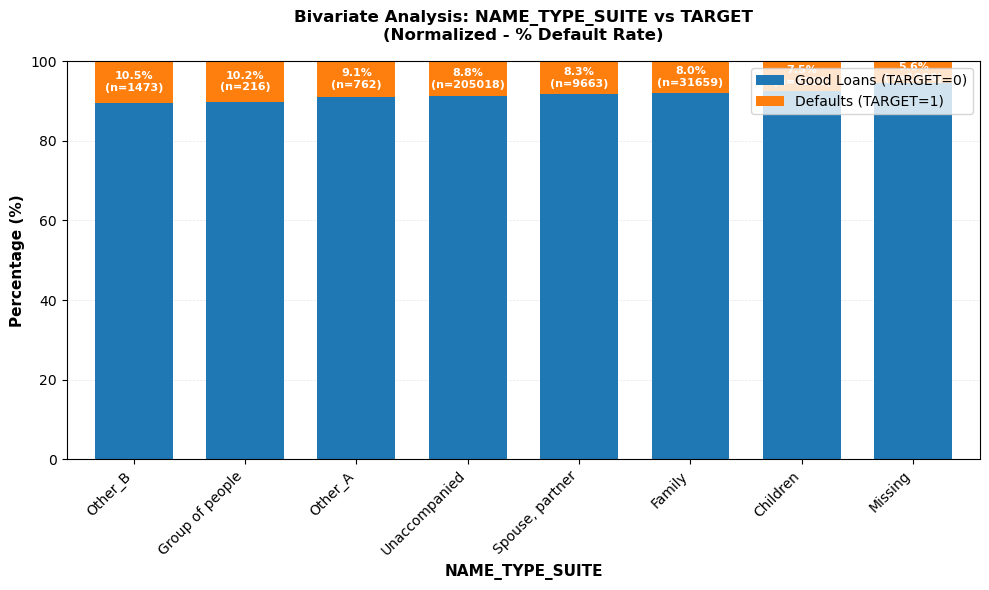

NAME_TYPE_SUITE:
  Categories: 8
  Default rate range: 5.57% - 10.52%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


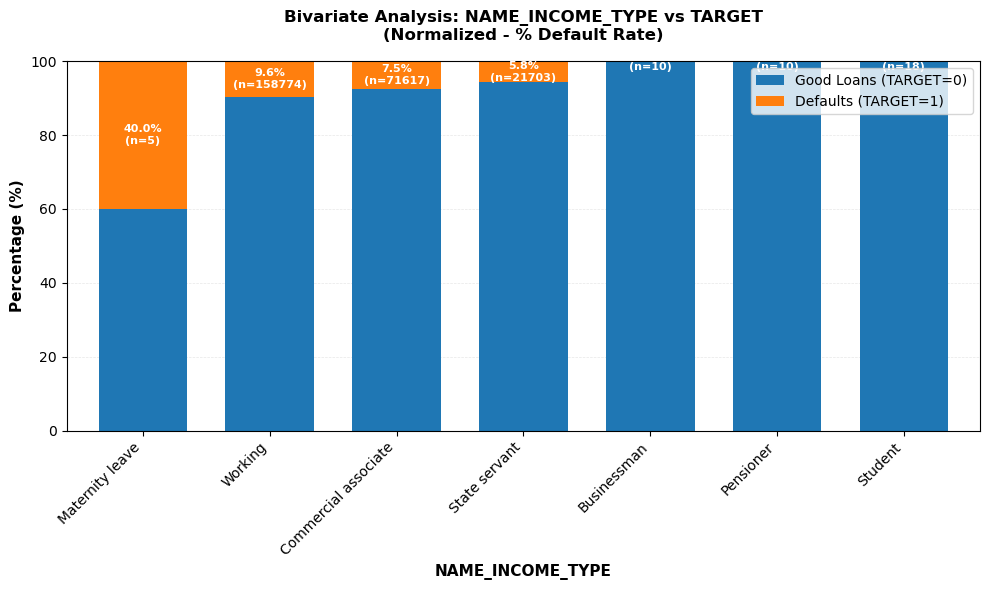

NAME_INCOME_TYPE:
  Categories: 7
  Default rate range: 0.00% - 40.00%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


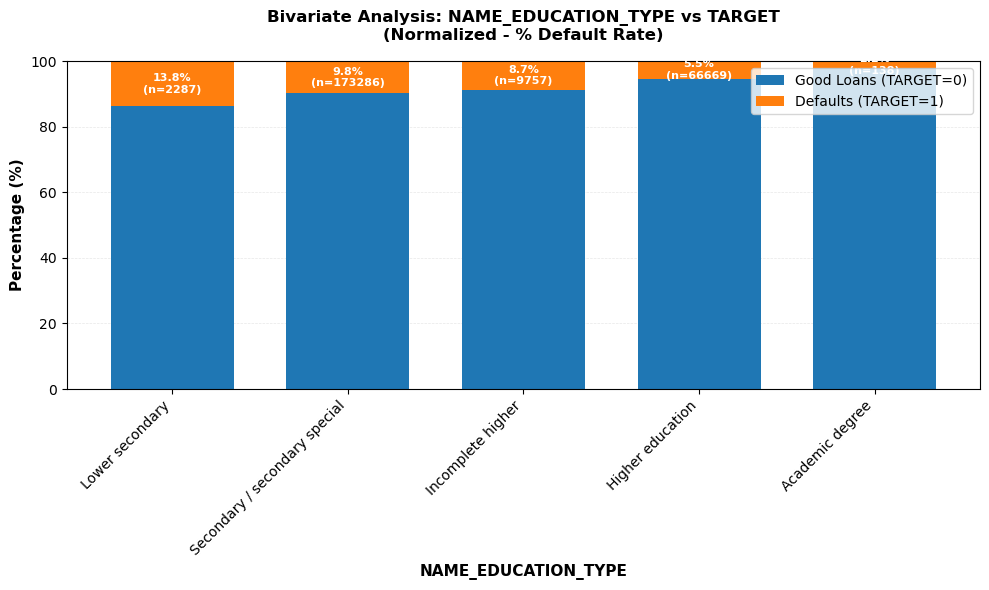

NAME_EDUCATION_TYPE:
  Categories: 5
  Default rate range: 2.17% - 13.77%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


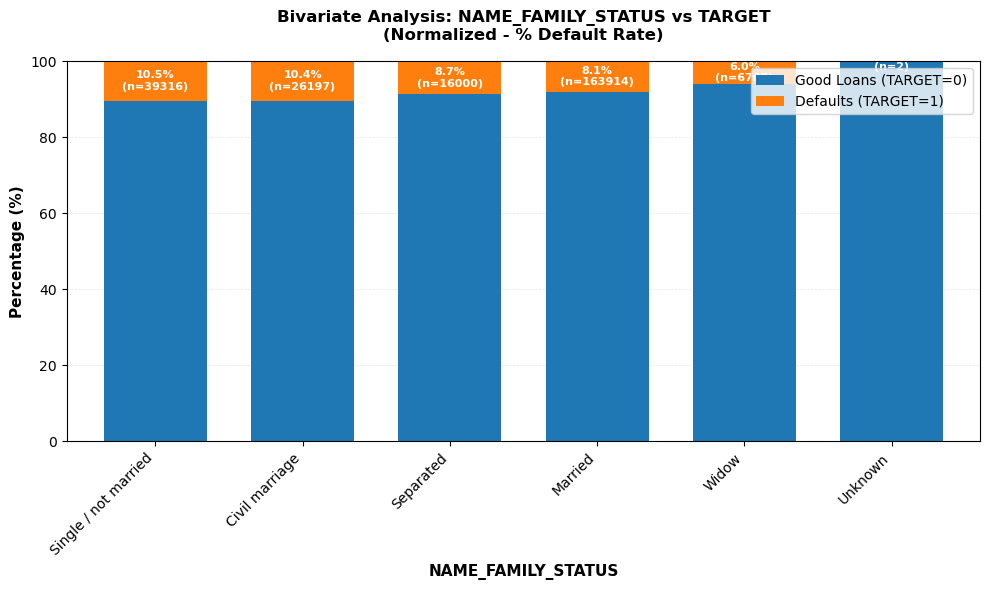

NAME_FAMILY_STATUS:
  Categories: 6
  Default rate range: 0.00% - 10.48%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


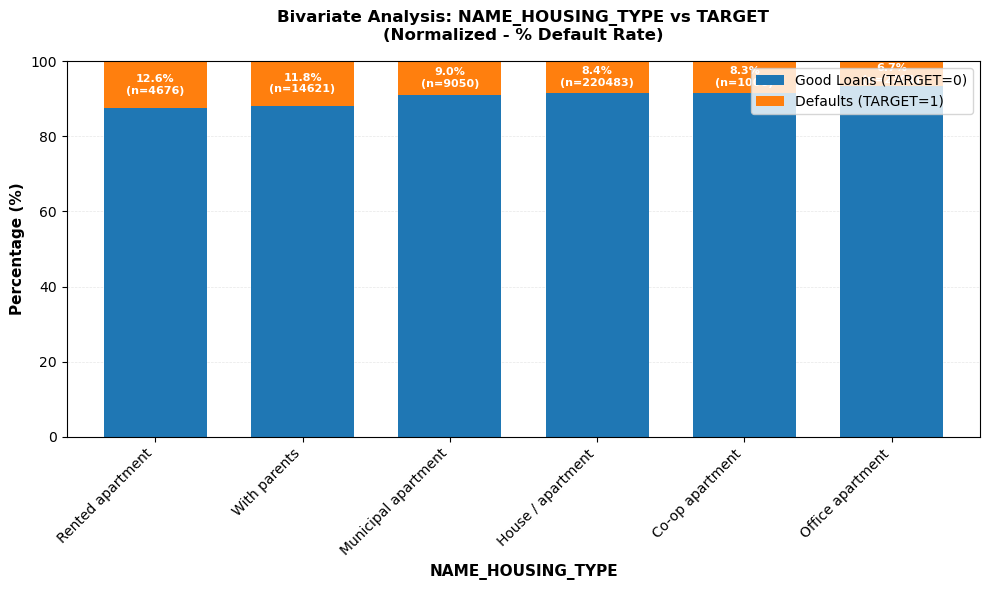

NAME_HOUSING_TYPE:
  Categories: 6
  Default rate range: 6.65% - 12.55%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


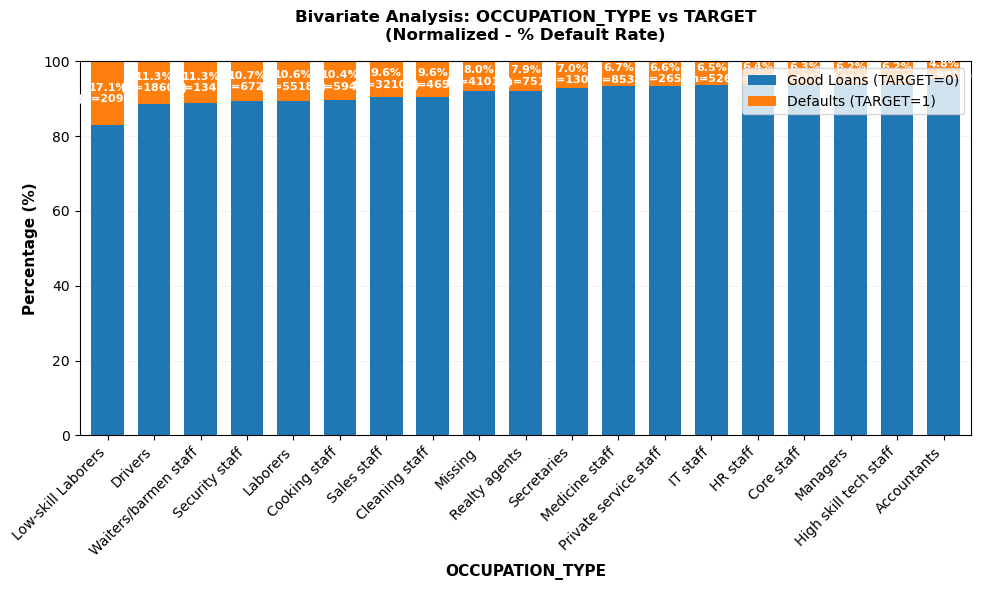

OCCUPATION_TYPE:
  Categories: 19
  Default rate range: 4.83% - 17.15%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


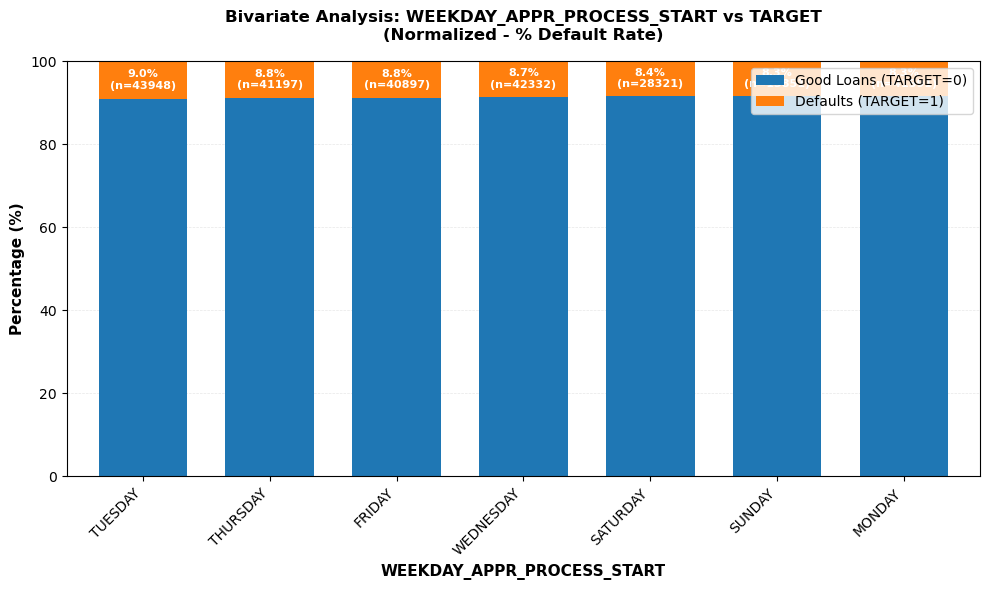

WEEKDAY_APPR_PROCESS_START:
  Categories: 7
  Default rate range: 8.32% - 9.00%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


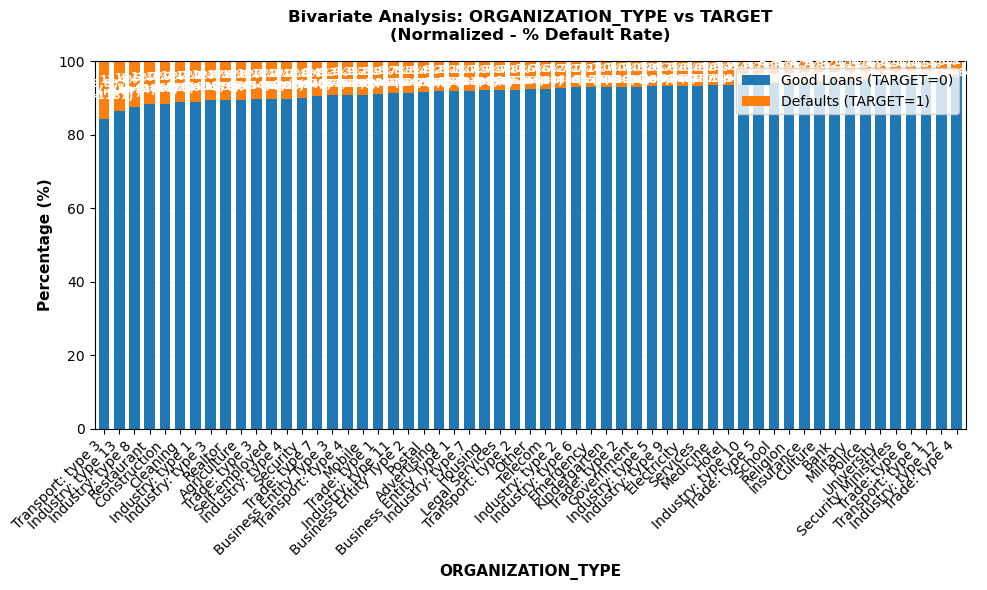

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


ORGANIZATION_TYPE:
  Categories: 57
  Default rate range: 3.12% - 15.75%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



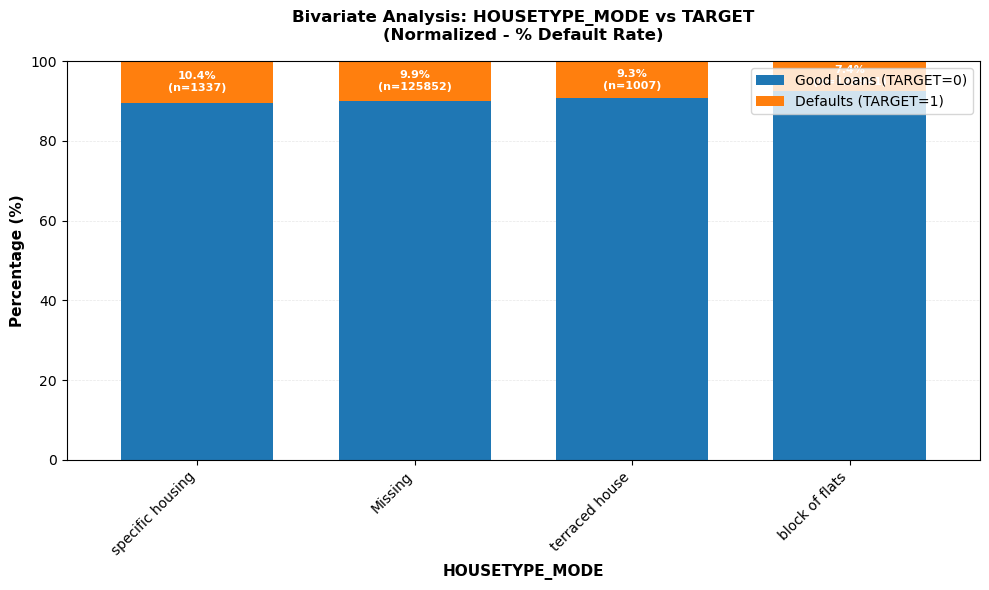

HOUSETYPE_MODE:
  Categories: 4
  Default rate range: 7.41% - 10.40%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


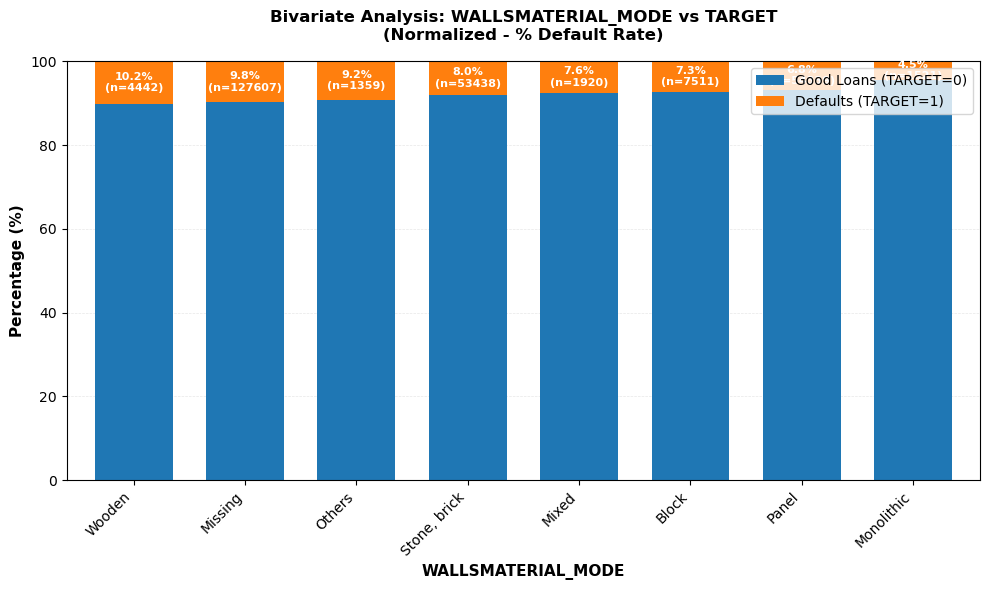

WALLSMATERIAL_MODE:
  Categories: 8
  Default rate range: 4.47% - 10.24%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


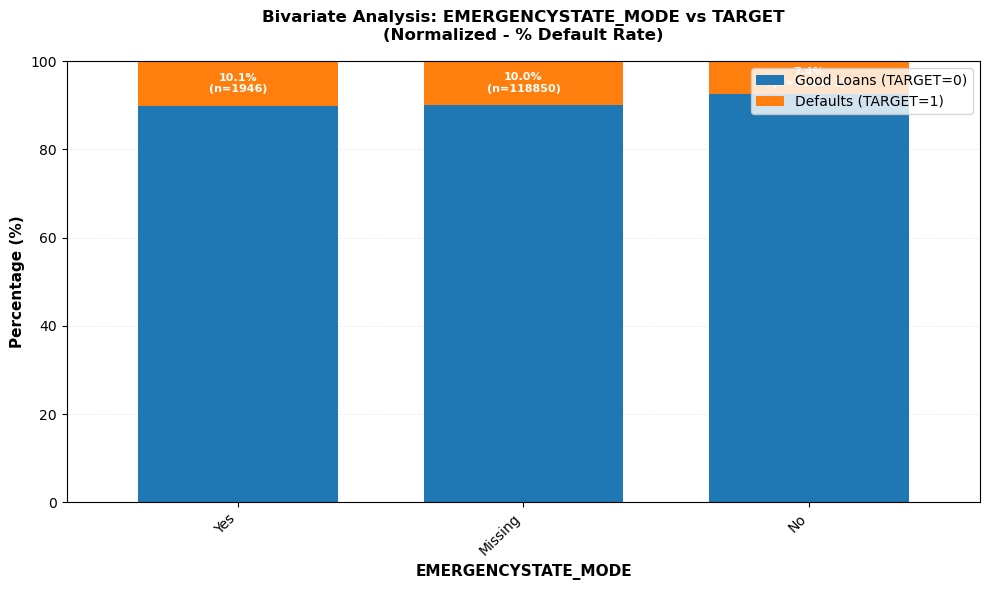

EMERGENCYSTATE_MODE:
  Categories: 3
  Default rate range: 7.44% - 10.12%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


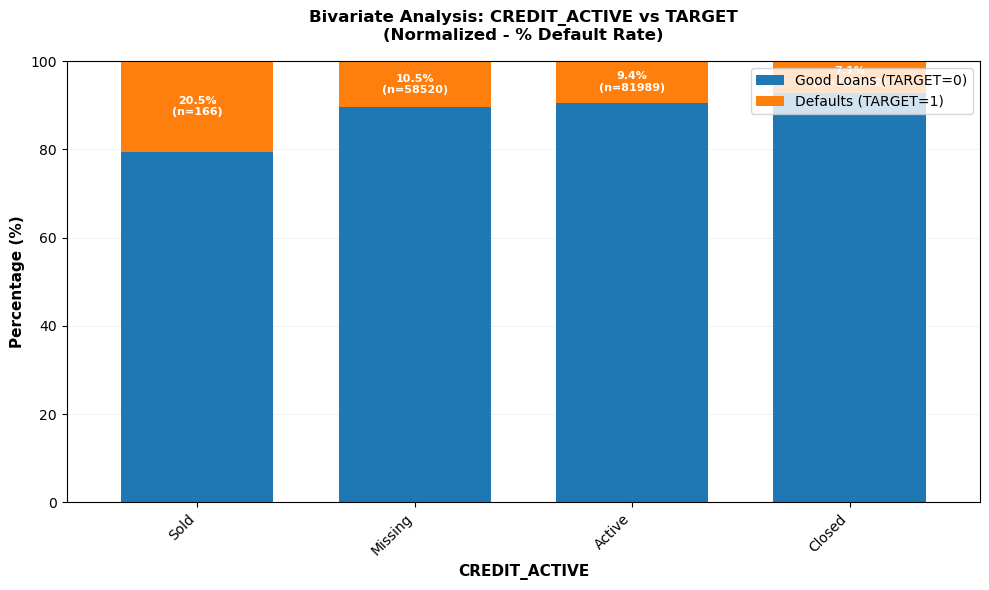

CREDIT_ACTIVE:
  Categories: 4
  Default rate range: 7.13% - 20.48%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


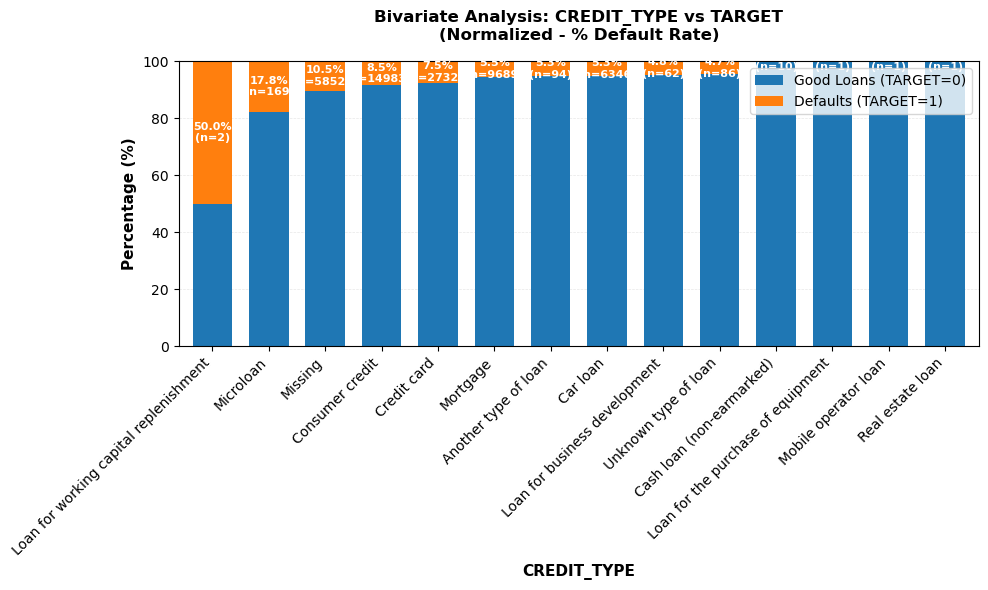

CREDIT_TYPE:
  Categories: 14
  Default rate range: 0.00% - 50.00%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


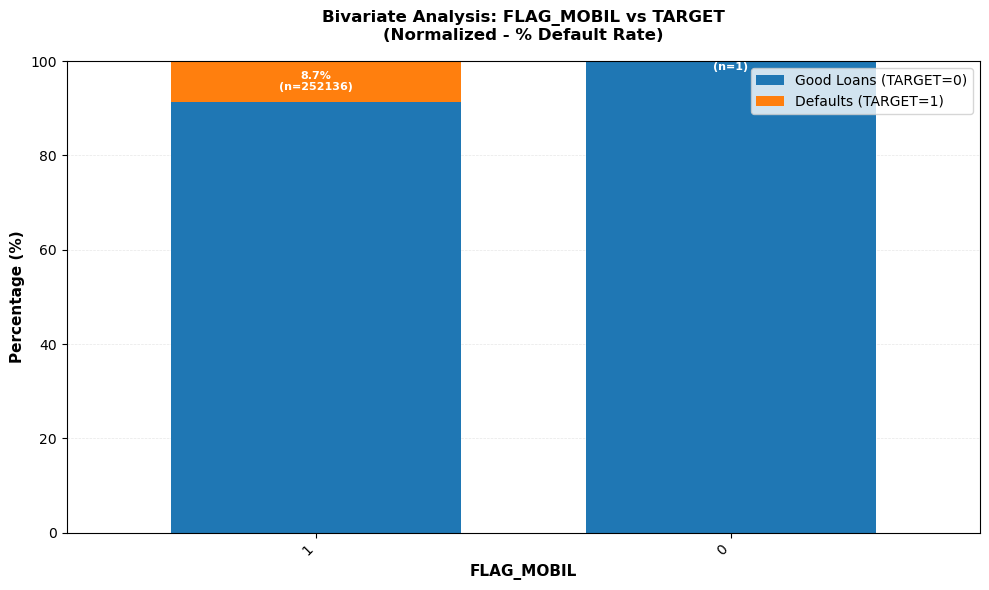

FLAG_MOBIL:
  Categories: 2
  Default rate range: 0.00% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


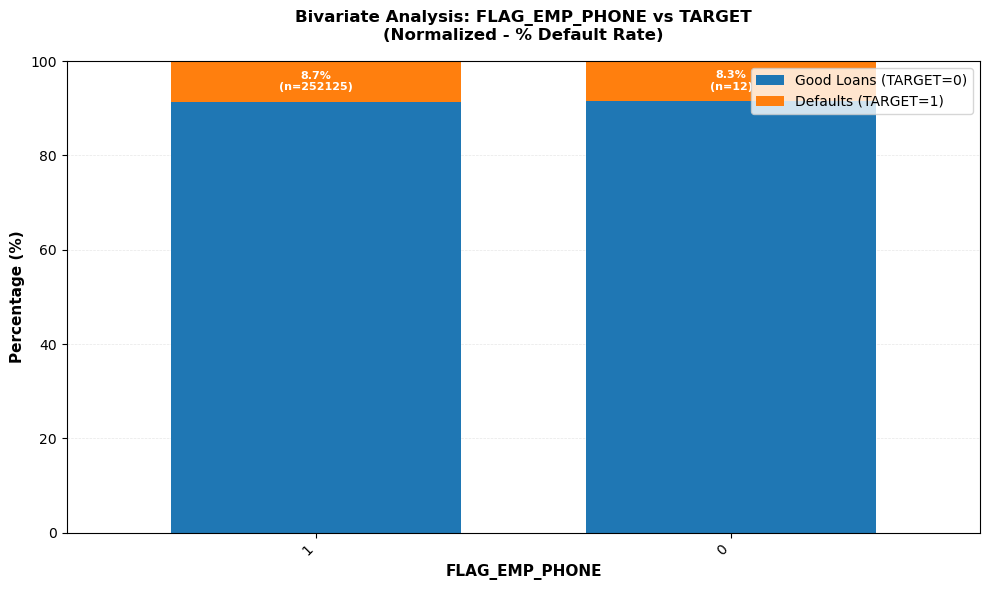

FLAG_EMP_PHONE:
  Categories: 2
  Default rate range: 8.33% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


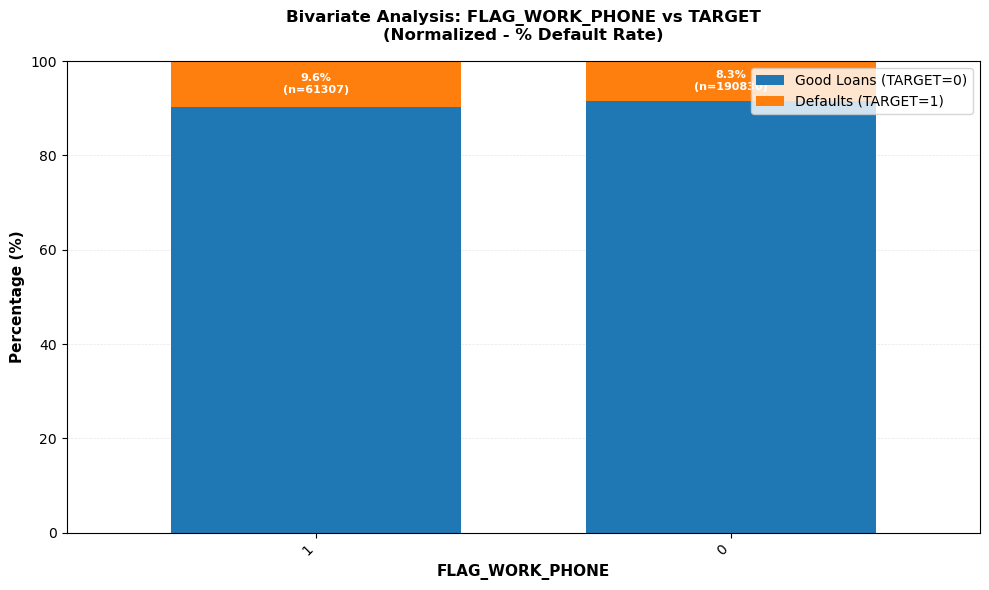

FLAG_WORK_PHONE:
  Categories: 2
  Default rate range: 8.35% - 9.63%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


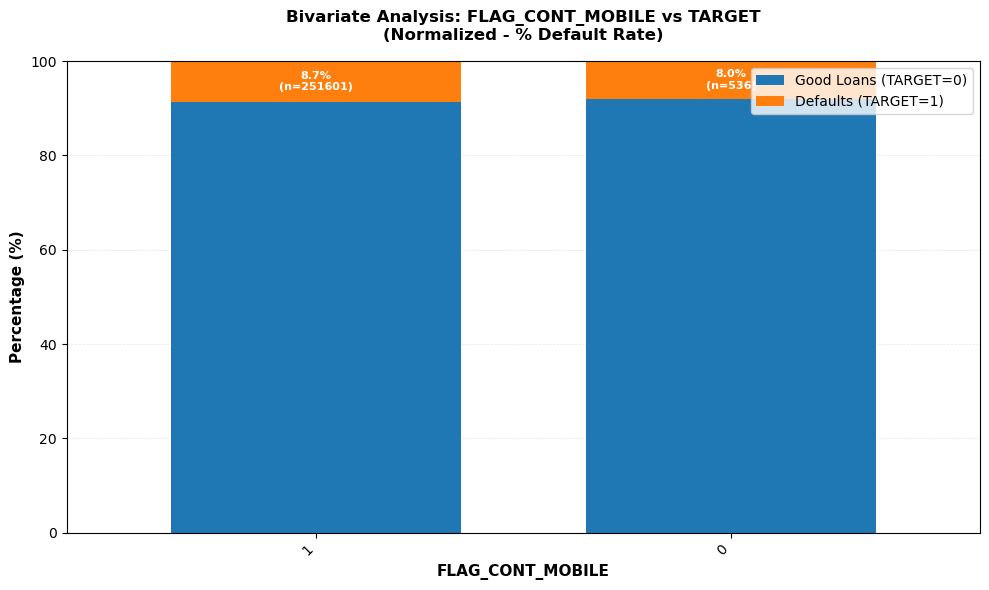

FLAG_CONT_MOBILE:
  Categories: 2
  Default rate range: 8.02% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


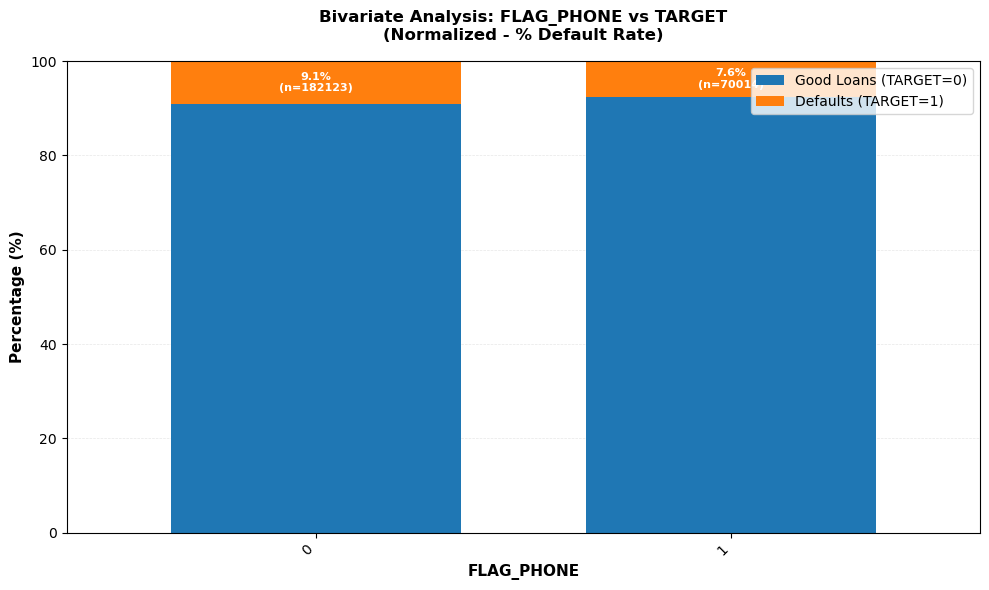

FLAG_PHONE:
  Categories: 2
  Default rate range: 7.57% - 9.08%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


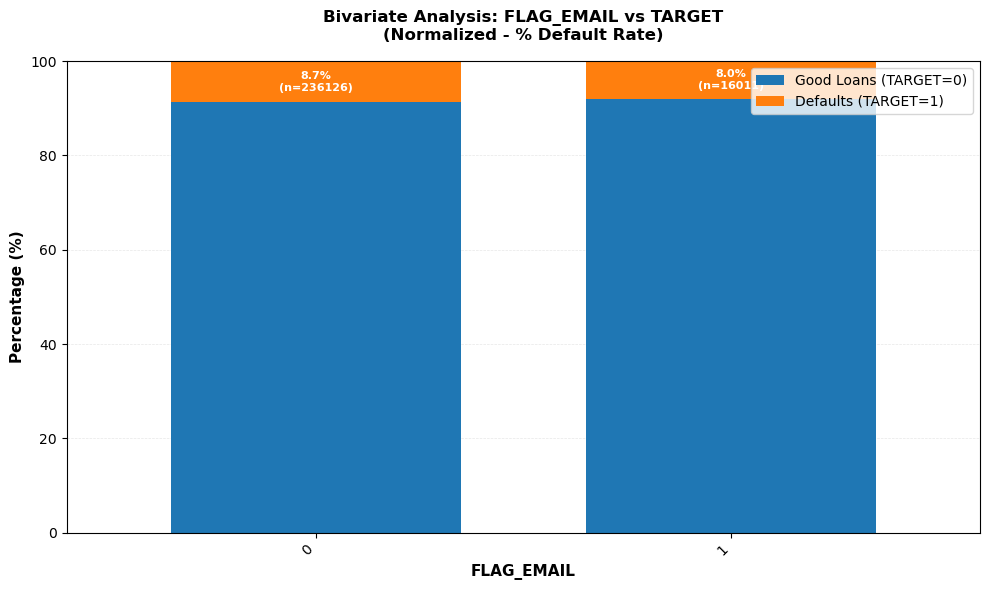

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_EMAIL:
  Categories: 2
  Default rate range: 8.01% - 8.70%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



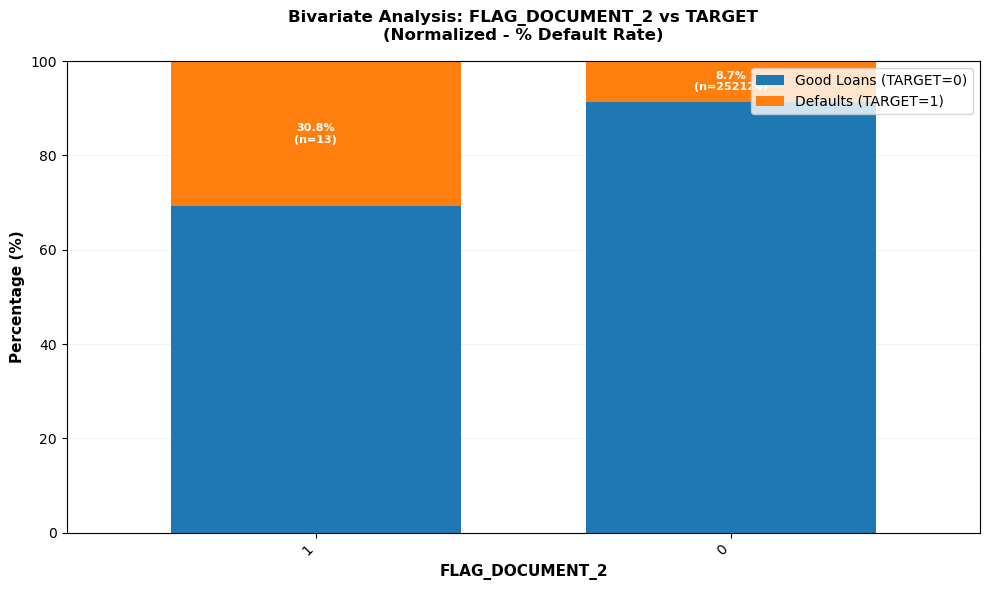

FLAG_DOCUMENT_2:
  Categories: 2
  Default rate range: 8.66% - 30.77%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


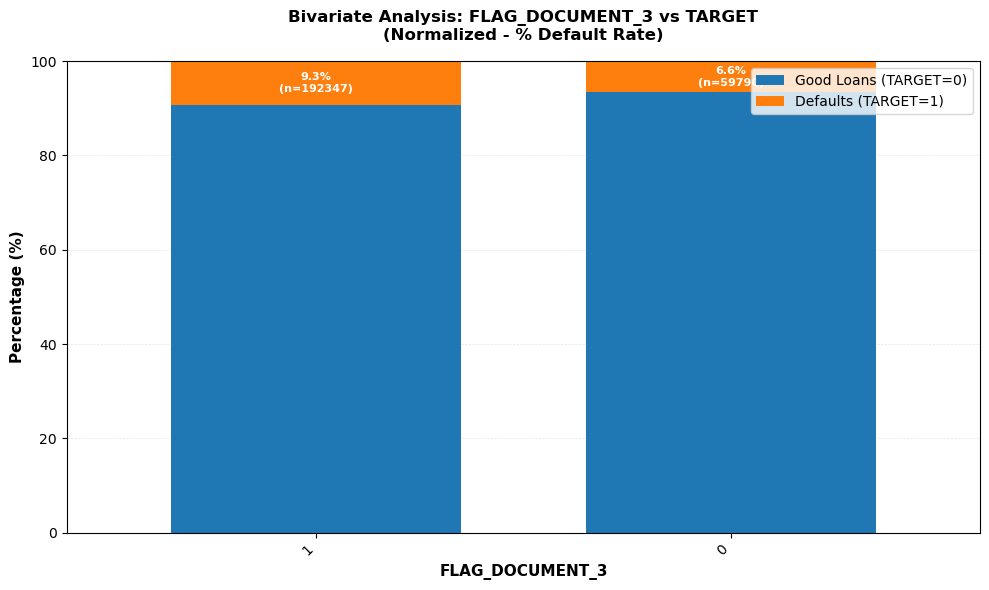

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_3:
  Categories: 2
  Default rate range: 6.58% - 9.31%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



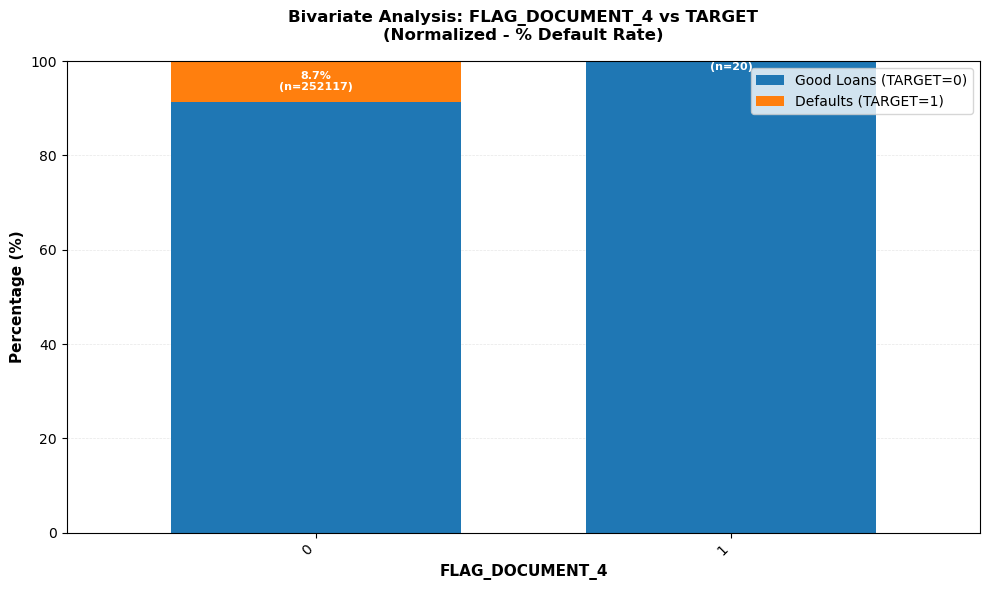

FLAG_DOCUMENT_4:
  Categories: 2
  Default rate range: 0.00% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


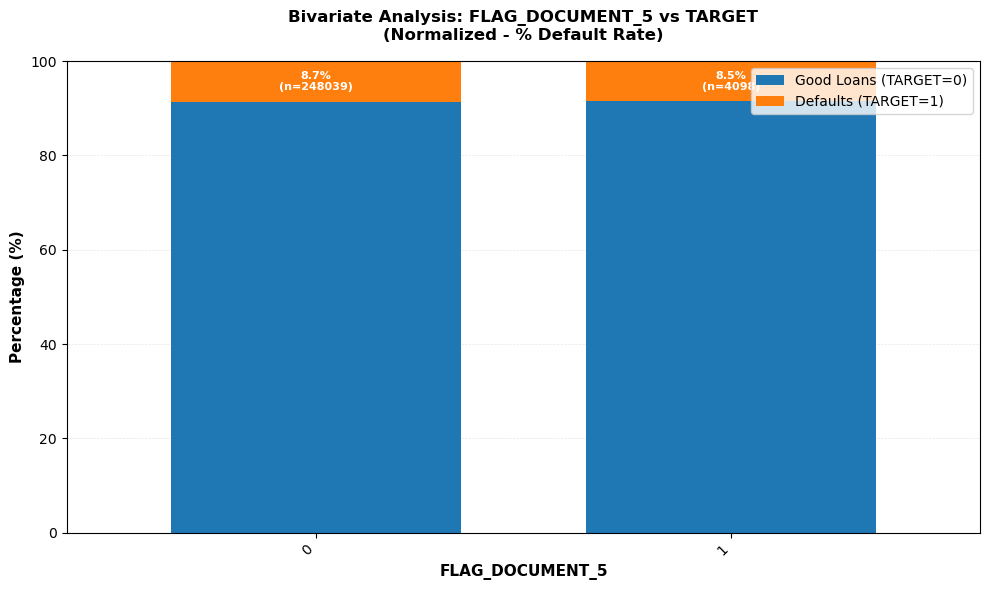

FLAG_DOCUMENT_5:
  Categories: 2
  Default rate range: 8.52% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


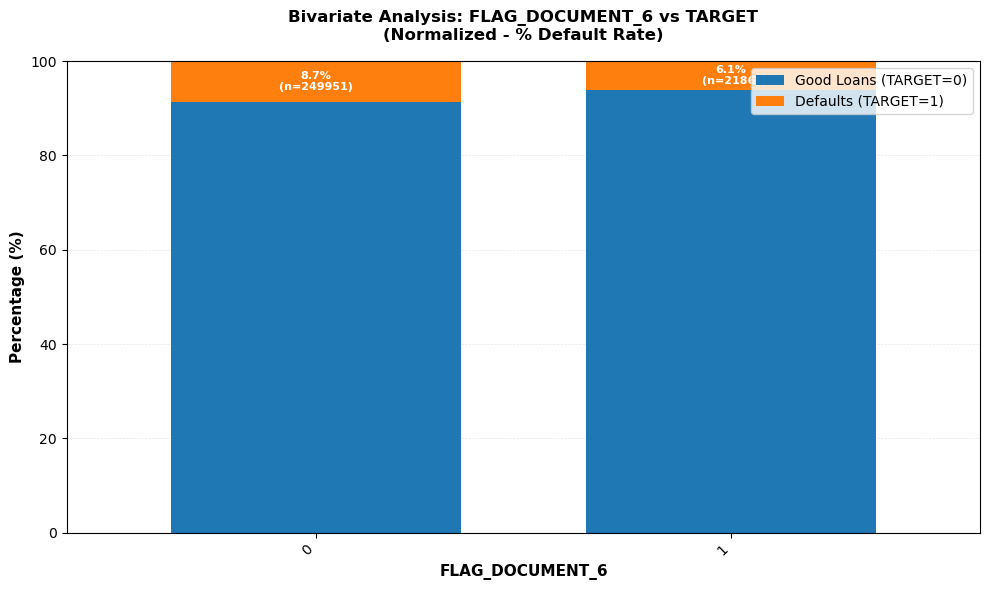

FLAG_DOCUMENT_6:
  Categories: 2
  Default rate range: 6.13% - 8.68%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


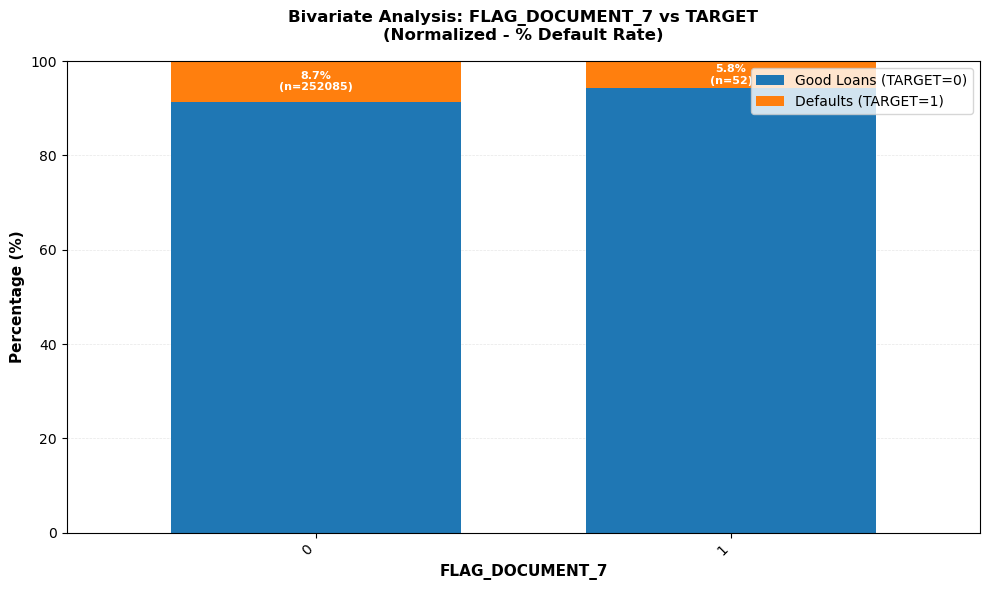

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_7:
  Categories: 2
  Default rate range: 5.77% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



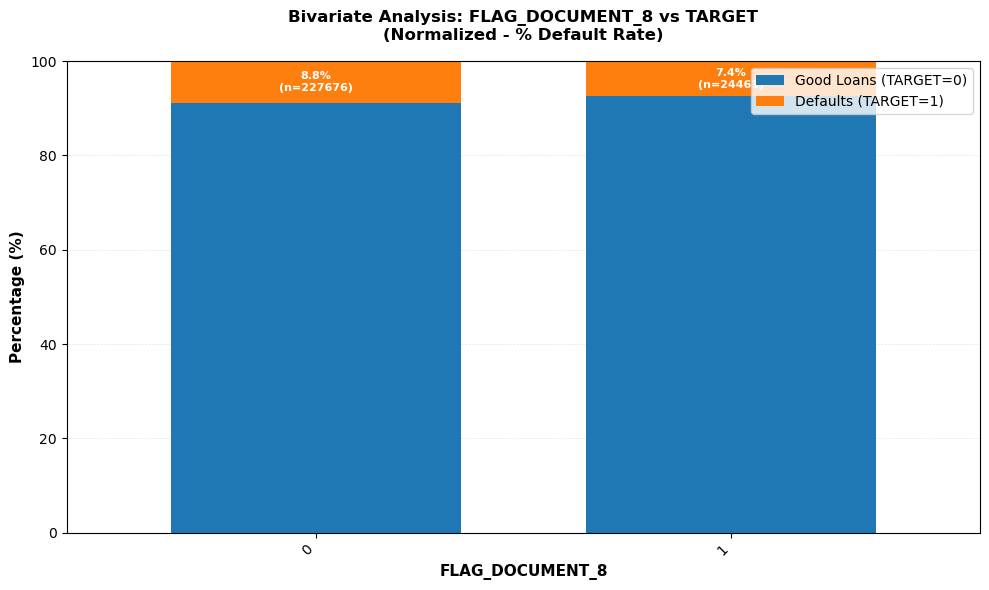

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_8:
  Categories: 2
  Default rate range: 7.44% - 8.79%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



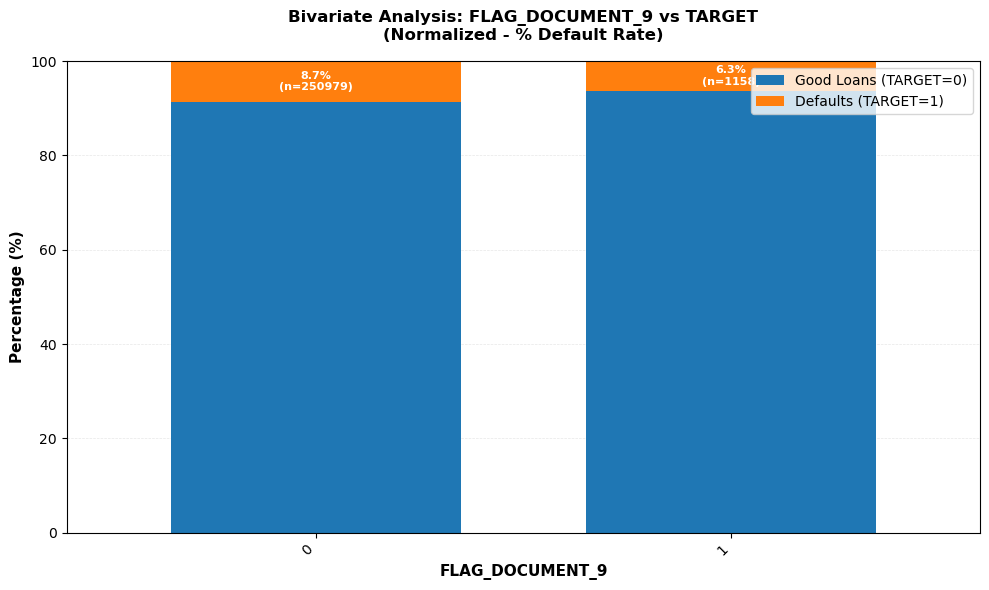

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_9:
  Categories: 2
  Default rate range: 6.30% - 8.67%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



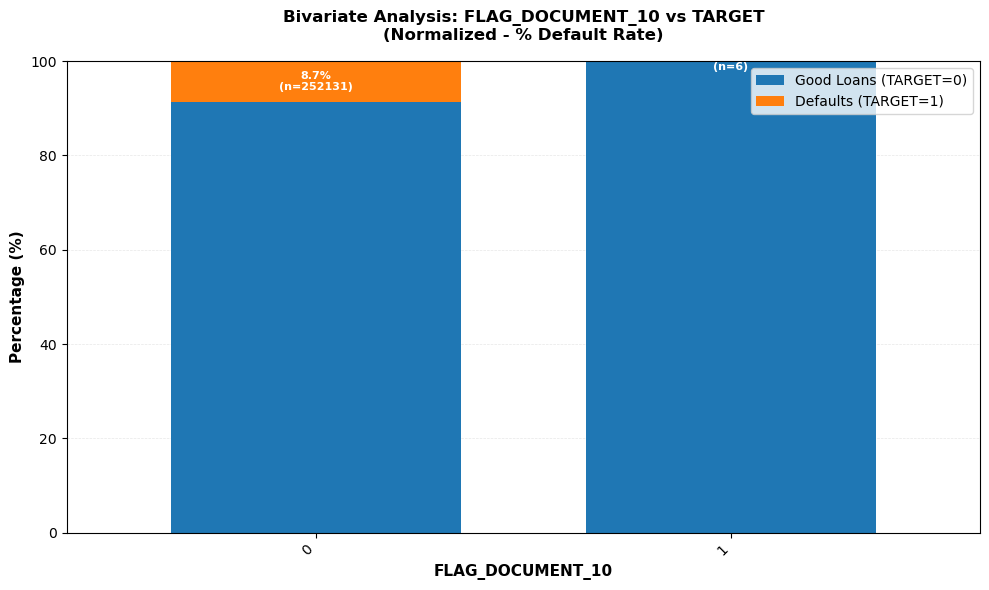

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_10:
  Categories: 2
  Default rate range: 0.00% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



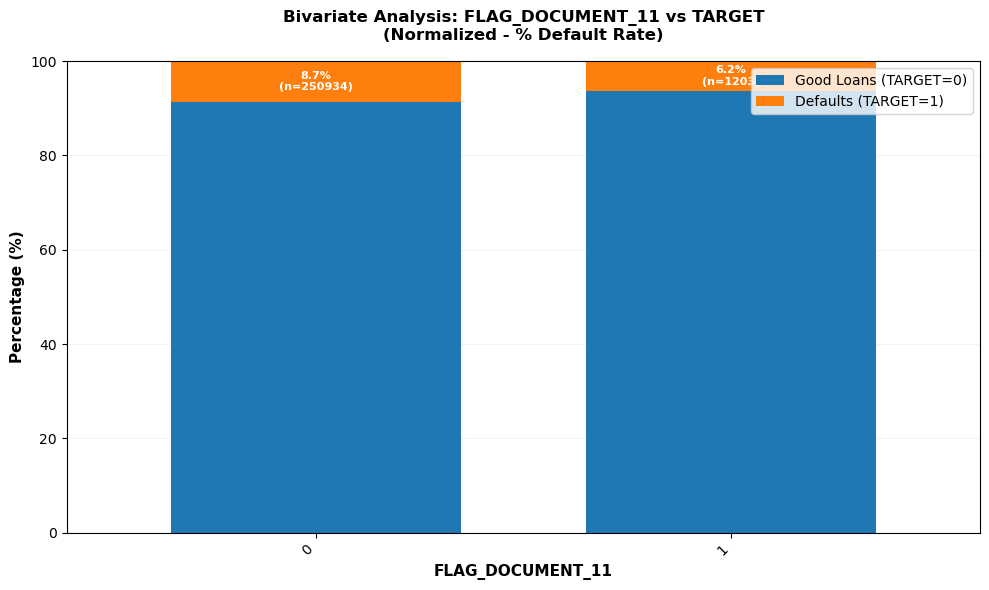

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_11:
  Categories: 2
  Default rate range: 6.23% - 8.67%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



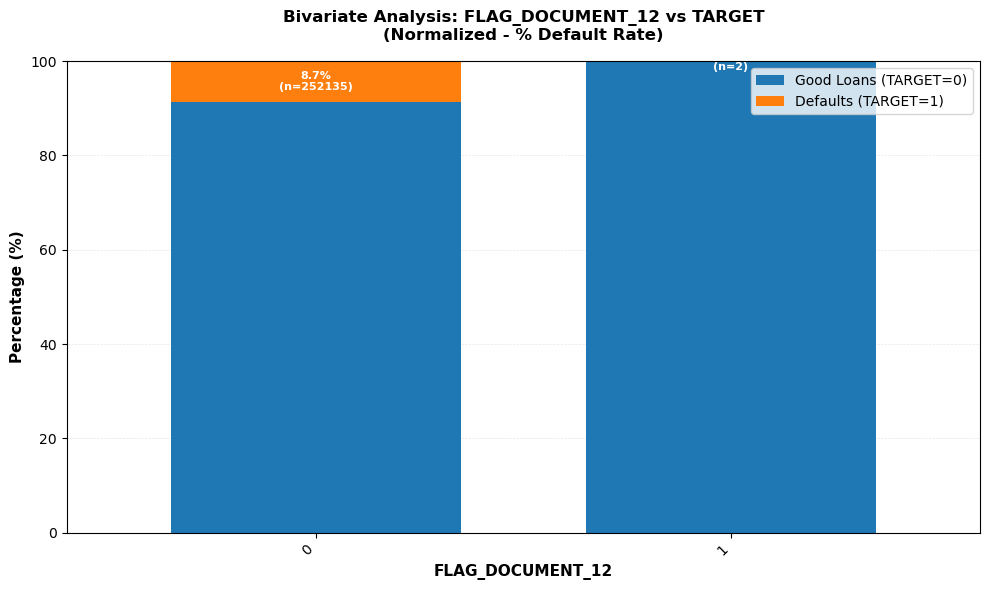

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_12:
  Categories: 2
  Default rate range: 0.00% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



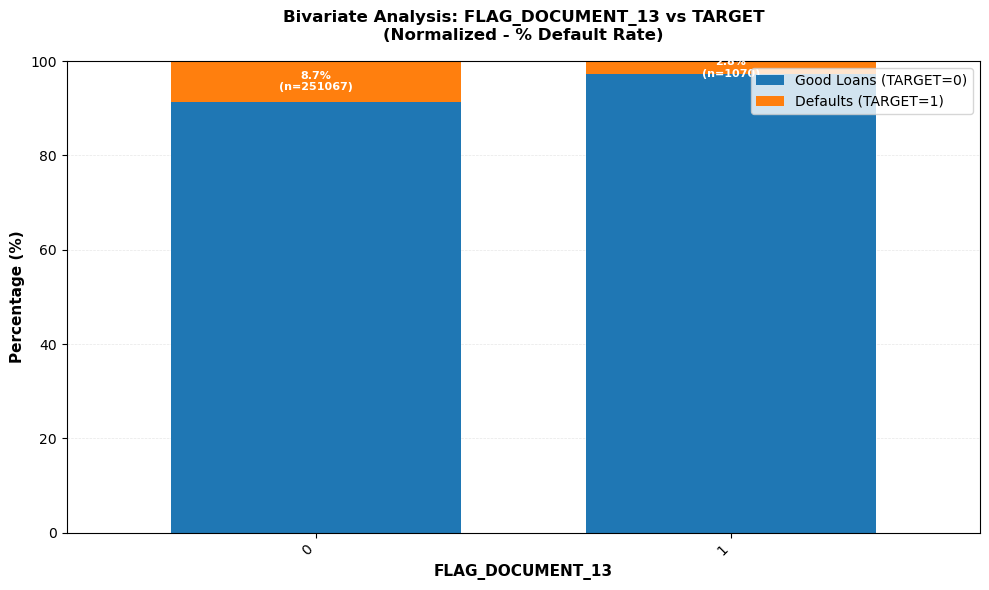

FLAG_DOCUMENT_13:
  Categories: 2
  Default rate range: 2.80% - 8.68%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


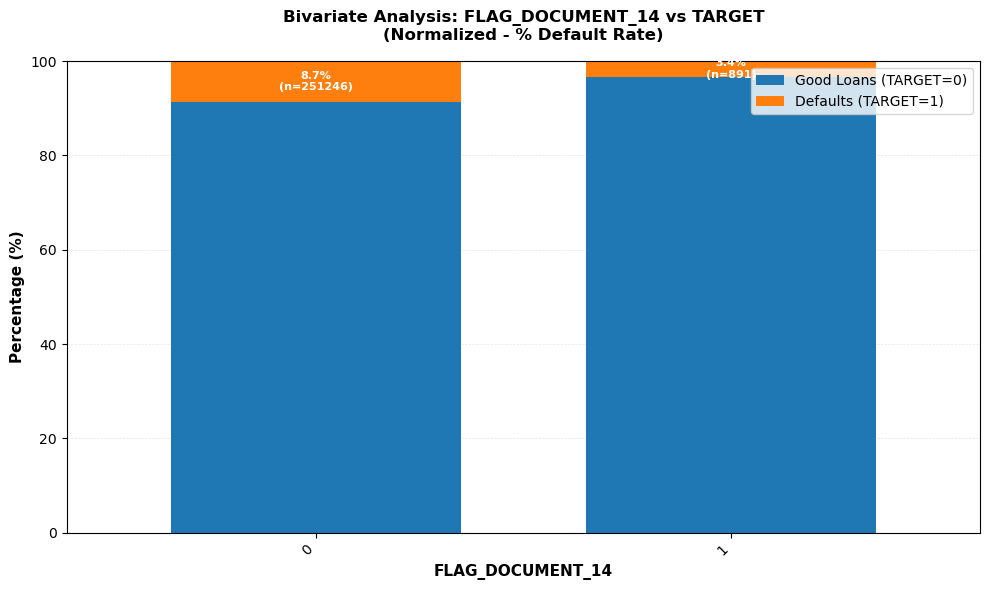

FLAG_DOCUMENT_14:
  Categories: 2
  Default rate range: 3.37% - 8.68%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


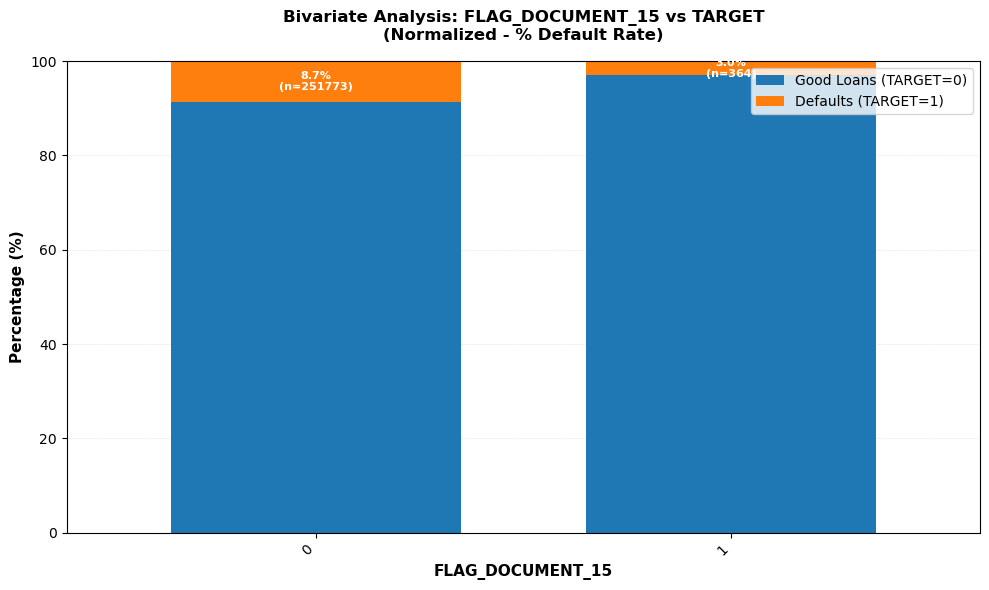

FLAG_DOCUMENT_15:
  Categories: 2
  Default rate range: 3.02% - 8.67%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


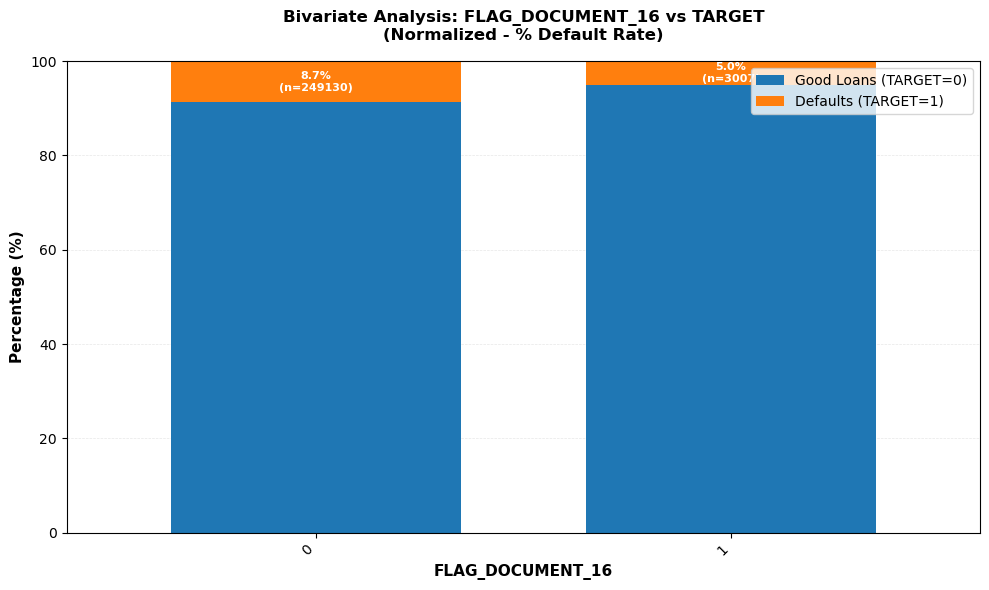

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_16:
  Categories: 2
  Default rate range: 4.99% - 8.70%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



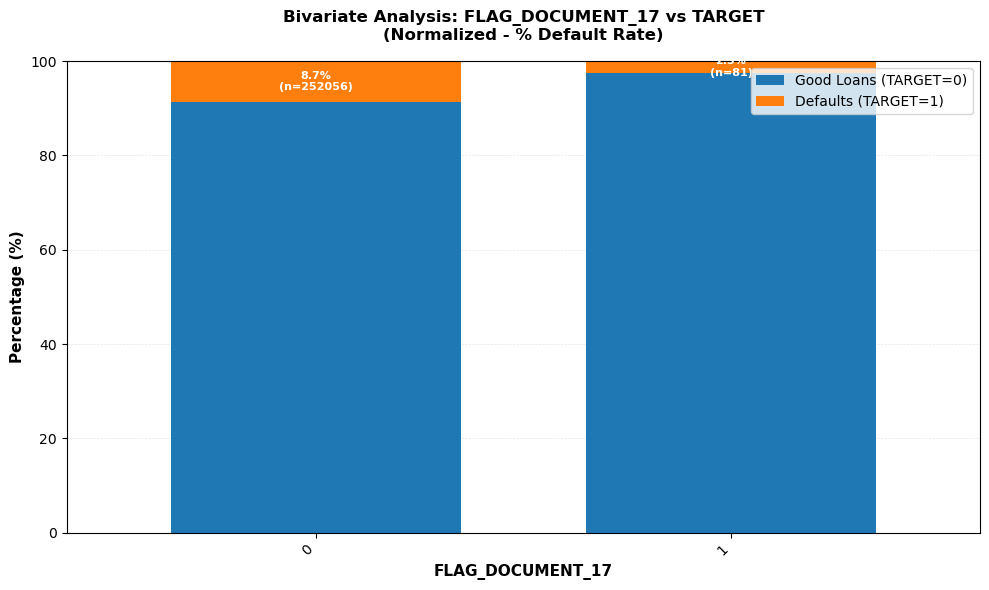

FLAG_DOCUMENT_17:
  Categories: 2
  Default rate range: 2.47% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


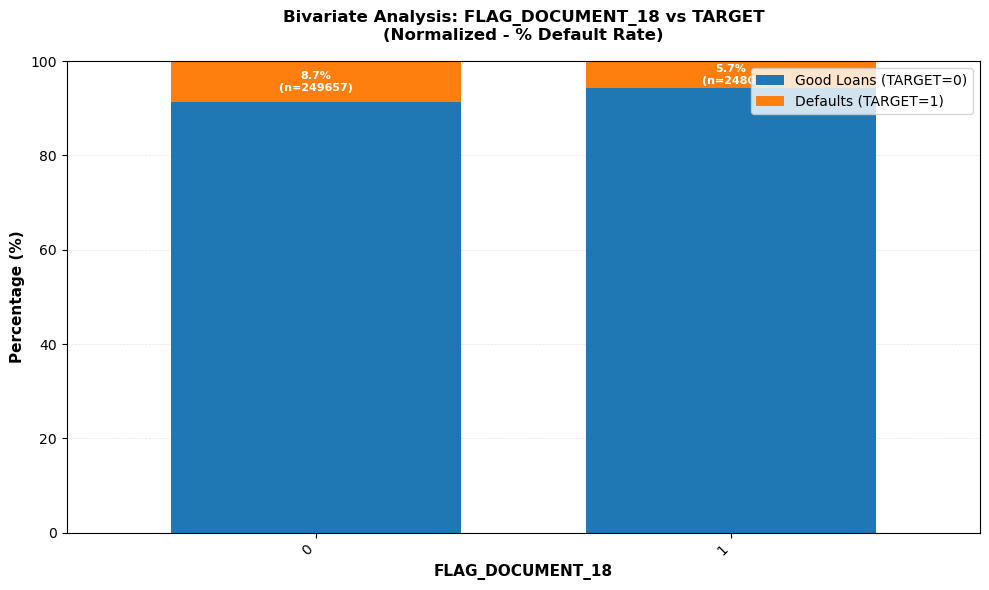

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_18:
  Categories: 2
  Default rate range: 5.73% - 8.69%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



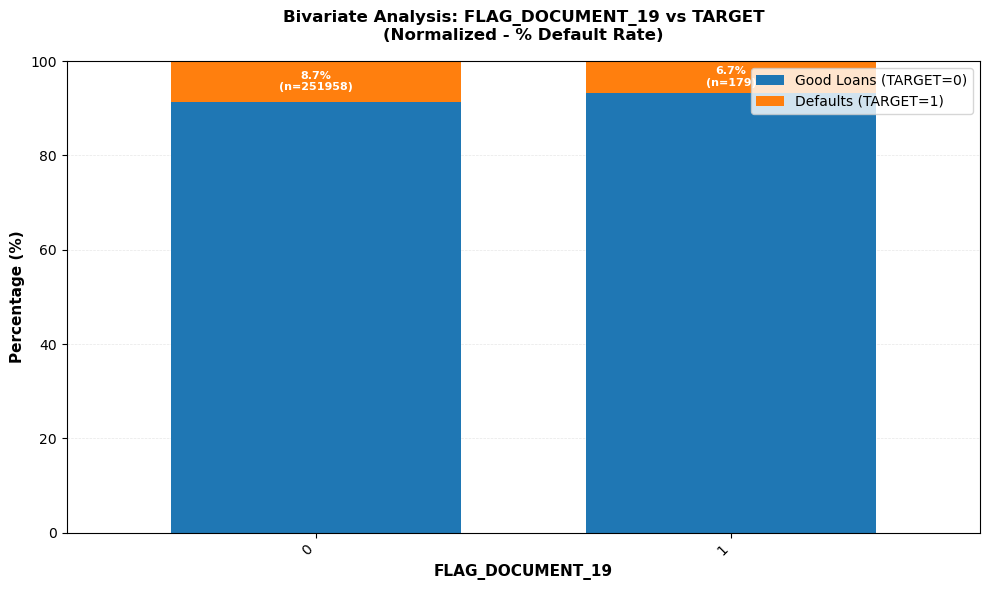

FLAG_DOCUMENT_19:
  Categories: 2
  Default rate range: 6.70% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


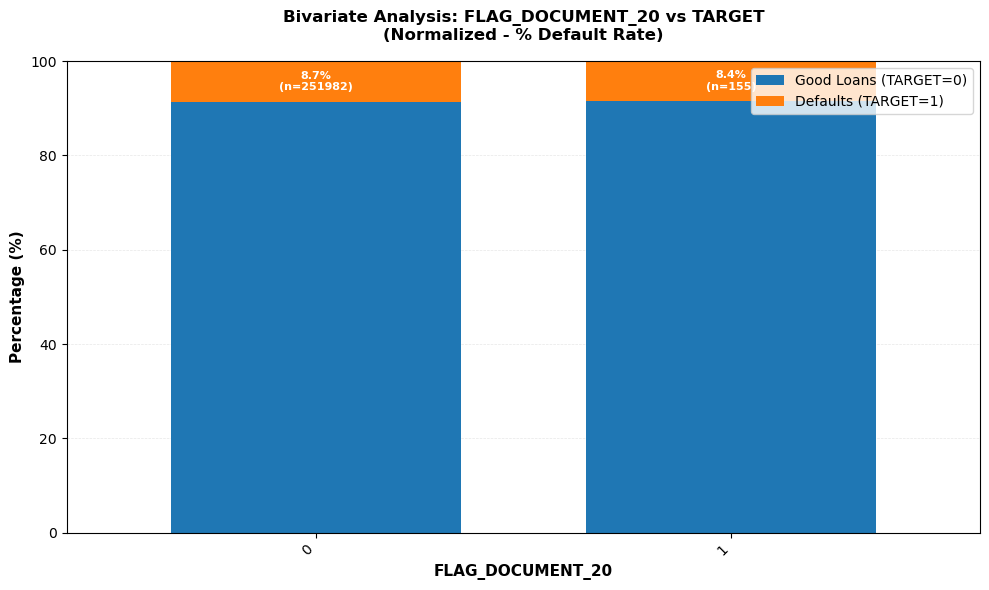

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_20:
  Categories: 2
  Default rate range: 8.39% - 8.66%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



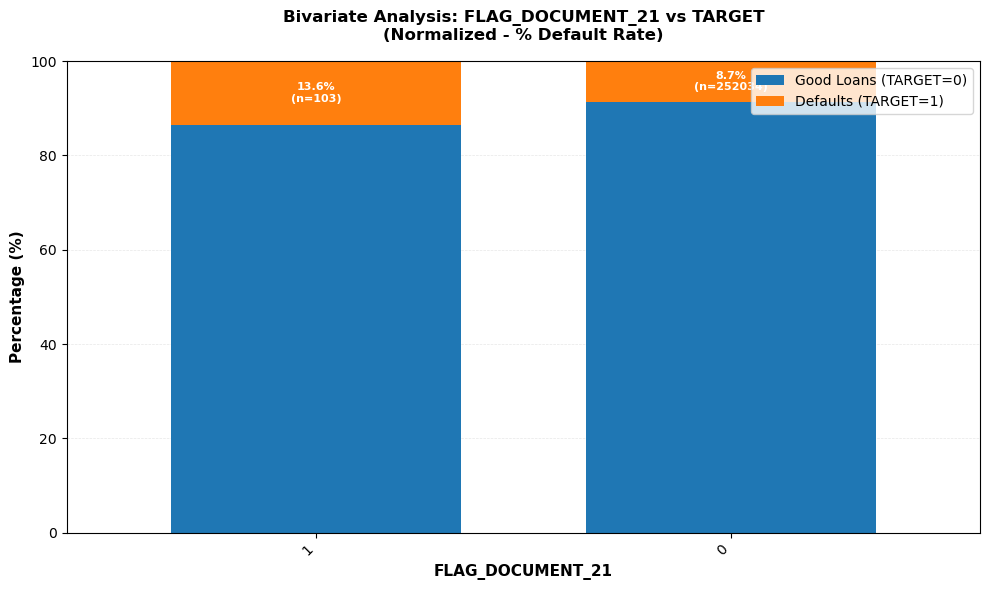

/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


FLAG_DOCUMENT_21:
  Categories: 2
  Default rate range: 8.66% - 13.59%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



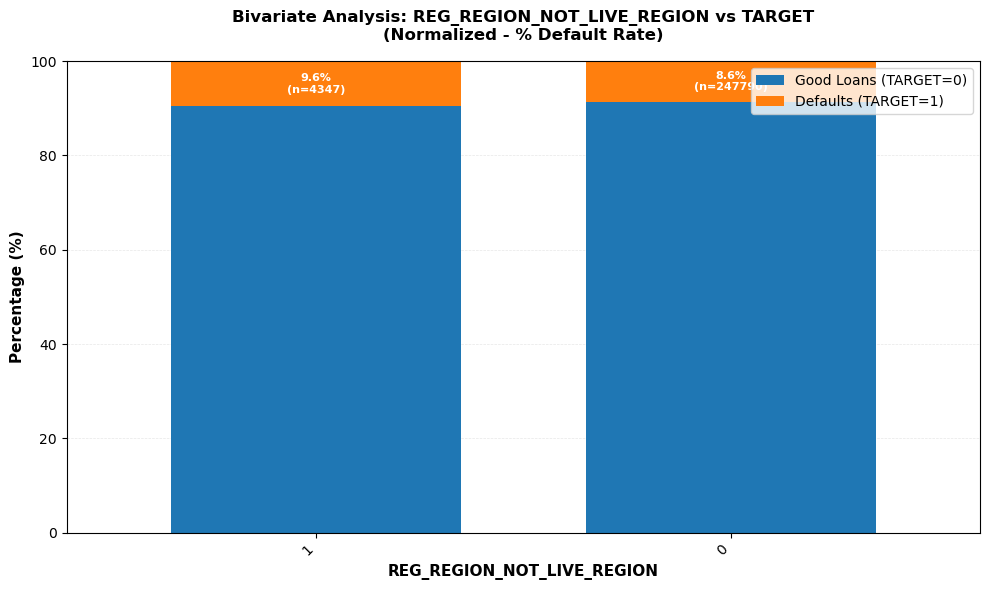

REG_REGION_NOT_LIVE_REGION:
  Categories: 2
  Default rate range: 8.64% - 9.59%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


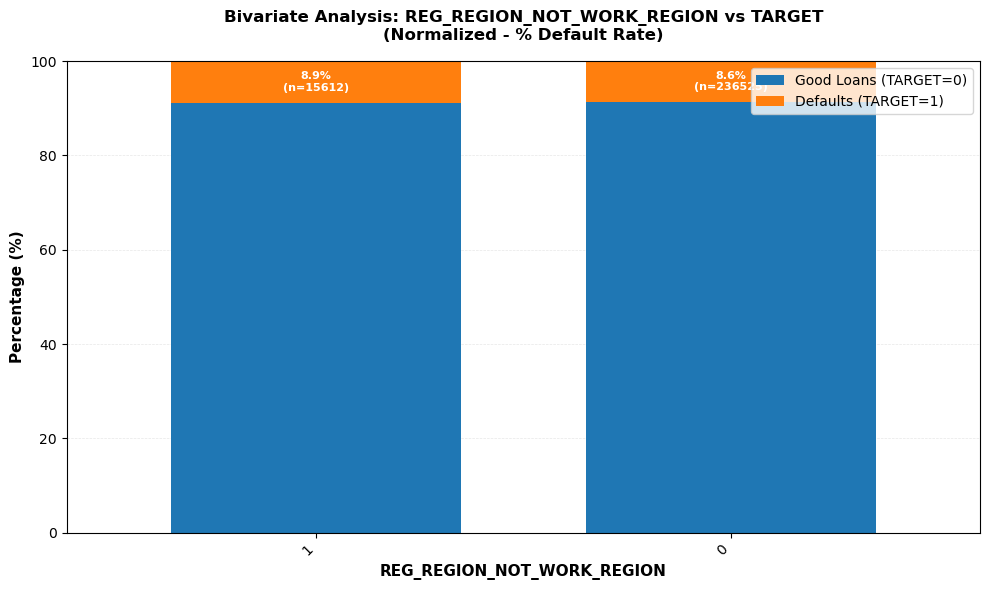

REG_REGION_NOT_WORK_REGION:
  Categories: 2
  Default rate range: 8.64% - 8.89%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


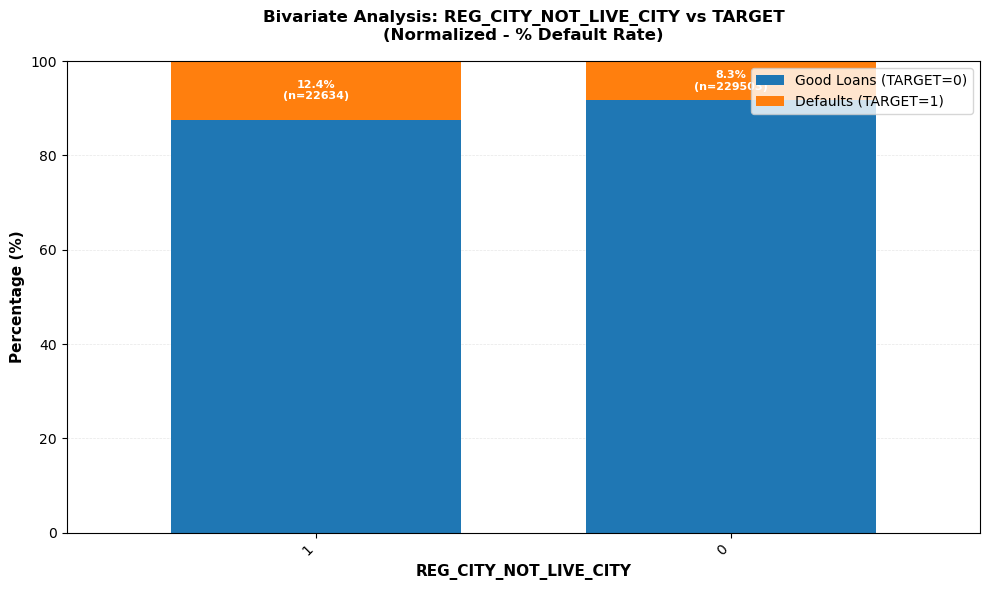

REG_CITY_NOT_LIVE_CITY:
  Categories: 2
  Default rate range: 8.29% - 12.42%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp



/var/folders/5z/_v91q0bs3cl_y08k407bg0t00000gn/T/ipykernel_26546/1601908118.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


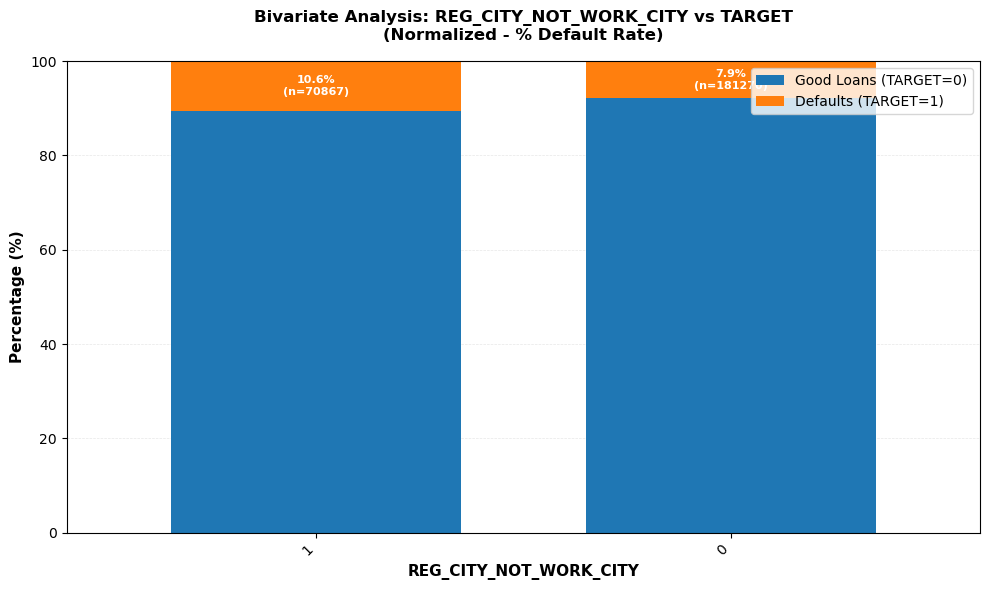

REG_CITY_NOT_WORK_CITY:
  Categories: 2
  Default rate range: 7.90% - 10.61%
  Portfolio default rate: 8.66%
  Difference from overall: 0.00 pp

Completed bivariate analysis for 45 categorical variables.


In [26]:
# Bivariate Analysis: Normalized Stacked Bar Plots for Categorical Variables vs TARGET
# Creates individual normalized (percentage) stacked bar charts to analyze the relationship 
# between each categorical variable and the TARGET variable (loan default status)

# Define the categorical columns to analyze (excluding SK_ID_CURR and TARGET)
cols_to_analyze = [col for col in categorical_columns if col not in ['SK_ID_CURR', 'TARGET'] and col in df_merged_cleaned.columns]

print(f"Total categorical columns to analyze: {len(cols_to_analyze)}")
print(f"Creating normalized stacked bar plots for bivariate analysis...\n")

# Create stacked bar plots for each categorical variable
for col in cols_to_analyze:
    try:
        # Create crosstab: rows are categories, columns are TARGET values (0 and 1)
        crosstab = pd.crosstab(df_merged_cleaned[col], df_merged_cleaned['TARGET'], margins=False)
        
        # Skip if column has no variance or no data
        if crosstab.shape[0] == 0 or crosstab.shape[1] < 2:
            print(f"Skipping {col}: Insufficient data variation")
            continue
        
        # Calculate normalized proportions (percentages) for stacked bars
        crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
        
        # Calculate statistics for each category
        total_counts = crosstab.sum(axis=1)  # Total observations per category
        bad_counts = crosstab[1]  # Count of defaults (TARGET=1)
        default_rates = (bad_counts / total_counts * 100).round(2)
        
        # Sort by default rate (descending) for better visual analysis of risk
        sort_idx = np.argsort(-default_rates.values)
        crosstab_pct_sorted = crosstab_pct.iloc[sort_idx]
        default_rates_sorted = default_rates.iloc[sort_idx]
        total_counts_sorted = total_counts.iloc[sort_idx]
        
        # Create the stacked bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot stacked bars with colors: blue for good (0), orange for defaults (1)
        crosstab_pct_sorted.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=['#1f77b4', '#ff7f0e'],  # blue for good loans, orange for defaults
            width=0.7,
            legend=True
        )
        
        # Add default rate percentage and sample size annotations on bars
        for i, (category, default_rate) in enumerate(default_rates_sorted.items()):
            sample_size = int(total_counts_sorted[category])
            # Position text in the middle of the default (orange) portion for readability
            y_pos = crosstab_pct_sorted.iloc[i, 0] + crosstab_pct_sorted.iloc[i, 1] / 2
            ax.text(i, y_pos, f'{default_rate:.1f}%\n(n={sample_size})', 
                    ha='center', va='center', fontsize=8, color='white', weight='bold')
        
        # Customize the plot appearance
        ax.set_xlabel(col, fontsize=11, weight='bold')
        ax.set_ylabel('Percentage (%)', fontsize=11, weight='bold')
        ax.set_title(f'Bivariate Analysis: {col} vs TARGET\n(Normalized - % Default Rate)', 
                     fontsize=12, weight='bold', pad=15)
        ax.set_ylim([0, 100])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
        
        # Update legend labels for clarity
        ax.legend(['Good Loans (TARGET=0)', 'Defaults (TARGET=1)'], 
                  loc='upper right', frameon=True, fontsize=10)
        
        # Add grid for better readability
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics for this variable
        print(f"{col}:")
        print(f"  Categories: {len(total_counts_sorted)}")
        print(f"  Default rate range: {default_rates_sorted.min():.2f}% - {default_rates_sorted.max():.2f}%")
        print(f"  Portfolio default rate: {(bad_counts.sum() / total_counts.sum() * 100):.2f}%")
        print(f"  Difference from overall: {((bad_counts.sum() / total_counts.sum() * 100) - df_merged_cleaned['TARGET'].mean() * 100):.2f} pp\n")
        
    except Exception as e:
        print(f"Error processing {col}: {str(e)}\n")
        continue

print(f"Completed bivariate analysis for {len(cols_to_analyze)} categorical variables.")

In [27]:
print(df_merged_cleaned.head())


   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002       1         Cash loans            N               Y   
1      100003       0         Cash loans            N               N   
2      100004       0    Revolving loans            Y               Y   
3      100006       0         Cash loans            N               Y   
4      100007       0         Cash loans            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE  \
0             0          202500.0    406597.5     24700.5        351000.0   
1             0          270000.0   1293502.5     35698.5       1129500.0   
2             0           67500.0    135000.0      6750.0        135000.0   
3             0          135000.0    312682.5     29686.5        297000.0   
4             0          121500.0    513000.0     21865.5        513000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Wo

## Generate WOE bins on Merged Dataset

In [35]:
# NUMERIC COLUMNS - Continuous or count-based features
numeric_features = [
    # Customer demographics
    'CNT_CHILDREN',
    'CNT_FAM_MEMBERS',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'DAYS_LAST_PHONE_CHANGE',

    # Financial amounts
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',

    # Geographic
    'REGION_POPULATION_RELATIVE',

    # Temporal
    'HOUR_APPR_PROCESS_START',

    # Social circle
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',

    # Credit bureau aggregates
    'NUM_PREV_LOANS',
    'CREDIT_DAY_OVERDUE',
    'DAYS_CREDIT',
    'DAYS_CREDIT_ENDDATE',
    'DAYS_ENDDATE_FACT',
    'CNT_CREDIT_PROLONG',
    'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT',
    'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE',
    'DAYS_CREDIT_UPDATE',

    # Building features (aggregated)
    'APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI',
    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
    'ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI',
    'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI',
    'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
    'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI',
    'REGION_RATING_CLIENT_W_CITY',
    'TOTALAREA_MODE',

    # Credit bureau inquiry activity
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR',
]

# CATEGORICAL COLUMNS - Nominal/ordinal features
categorical_features = [
    # Contract & housing
    'NAME_CONTRACT_TYPE',
    'NAME_TYPE_SUITE',
    'NAME_HOUSING_TYPE',

    # Demographics
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'OCCUPATION_TYPE',

    # Flags (binary categorical)
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'FLAG_MOBIL',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL',

    # Regional flags (binary)
    'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',

    # Document submission flags
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',

    # Weekday
    'WEEKDAY_APPR_PROCESS_START',

    # Building modes (categorical)
    'HOUSETYPE_MODE',
    'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE',

    # Bureau categorical
    'CREDIT_ACTIVE',
    'CREDIT_TYPE',
]

# ============================================================================
# VALIDATE: Check for overlap and missing columns
# ============================================================================

# Check for overlap between numeric and categorical
overlap = set(numeric_features) & set(categorical_features)
if overlap:
    print(f"❌ ERROR: Columns appear in both lists: {overlap}")
else:
    print(f"✓ No overlap between numeric and categorical lists\n")

# Check all columns exist in dataframe
numeric_missing = [col for col in numeric_features if col not in df_merged_cleaned.columns]
categorical_missing = [col for col in categorical_features if col not in df_merged_cleaned.columns]

if numeric_missing:
    print(f"⚠️  Numeric columns not found in data: {numeric_missing}")
    numeric_features = [col for col in numeric_features if col in df_merged_cleaned.columns]

if categorical_missing:
    print(f"⚠️  Categorical columns not found in data: {categorical_missing}")
    categorical_features = [col for col in categorical_features if col in df_merged_cleaned.columns]

# ============================================================================
# COMBINE FEATURES FOR WOE BINNING
# ============================================================================

all_features_for_woe = numeric_features + categorical_features

# Create dataframe with all features and TARGET
df_for_woe = df_merged_cleaned[all_features_for_woe + ['TARGET']].copy()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Total unique features: {len(all_features_for_woe)}")
print(f"Dataset shape: {df_for_woe.shape}\n")

# ============================================================================
# PREPARE DATA FOR WOE BINNING
# ============================================================================

# Replace string "Missing" with actual NaN - scorecardpy will create a separate bin for missing values
df_for_woe = df_for_woe.replace('Missing', np.nan)

# Check for missing values (these will become their own bin)
print("Missing values summary (will be binned separately):")
missing_summary = df_for_woe.isnull().sum()
if missing_summary.sum() > 0:
    print(missing_summary[missing_summary > 0])
else:
    print("No missing values found")

print(f"\nTotal missing values: {df_for_woe.isnull().sum().sum()}\n")

# ============================================================================
# PERFORM WOE BINNING
# ============================================================================

print("Performing WOE binning on all features...")
bins = sc.woebin(df_for_woe, y='TARGET', auto_continue=True)

print(f"✓ WOE binning completed for {len(bins)} features\n")

# Store IV values in a dictionary
iv_summary = {var: bindetails['total_iv'][0] for var, bindetails in bins.items()}

# Convert the IV dictionary to a sorted DataFrame
iv_summary_df = pd.DataFrame(iv_summary.items(), columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

# Display the IV summary
print("=" * 100)
print("Summary of IV Values for All Features (Numeric + Categorical):")
print("=" * 100 + "\n")
print(iv_summary_df)

# Print the WoE details for each variable
print("\n" + "=" * 100)
print("Detailed WoE Binning Results for Each Variable:")
print("=" * 100 + "\n")

for variable, bindetails in bins.items():
    print(f"\n{variable}:")
    display(bindetails)
    print("--" * 50)

✓ No overlap between numeric and categorical lists

Numeric features: 54
Categorical features: 45
Total unique features: 99
Dataset shape: (252137, 100)

Missing values summary (will be binned separately):
CNT_FAM_MEMBERS                      2
DAYS_LAST_PHONE_CHANGE               1
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    256
OBS_30_CNT_SOCIAL_CIRCLE           849
DEF_30_CNT_SOCIAL_CIRCLE           849
OBS_60_CNT_SOCIAL_CIRCLE           849
DEF_60_CNT_SOCIAL_CIRCLE           849
DAYS_CREDIT                      58520
DAYS_CREDIT_ENDDATE              58520
DAYS_ENDDATE_FACT                90701
CNT_CREDIT_PROLONG               58520
DAYS_CREDIT_UPDATE               58520
APARTMENTS_AVG                  127336
APARTMENTS_MODE                 127336
APARTMENTS_MEDI                 127336
YEARS_BEGINEXPLUATATION_AVG     122341
YEARS_BEGINEXPLUATATION_MODE    122341
YEARS_BEGINEXPLUATATION_MEDI    122341
ELEVATORS_AVG                   133778
ELEVATORS_MODE

/opt/anaconda3/envs/is453/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/envs/is453/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/anaconda3/envs/is453/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so 

Binning on 252137 rows and 100 columns in 00:00:26
✓ WOE binning completed for 99 features

Summary of IV Values for All Features (Numeric + Categorical):

                         Feature        IV
16                 DAYS_EMPLOYED  0.089939
26               OCCUPATION_TYPE  0.067797
10               AMT_GOODS_PRICE  0.067041
4            NAME_EDUCATION_TYPE  0.066224
7                    DAYS_CREDIT  0.063156
8                     AMT_CREDIT  0.060004
19   REGION_RATING_CLIENT_W_CITY  0.059416
97                    DAYS_BIRTH  0.054122
85             DAYS_ENDDATE_FACT  0.052901
70        DAYS_LAST_PHONE_CHANGE  0.047554
81                 FLOORSMAX_AVG  0.043104
13                FLOORSMAX_MEDI  0.042781
63                FLOORSMAX_MODE  0.042165
56                TOTALAREA_MODE  0.040793
53                LIVINGAREA_AVG  0.038863
21                 ELEVATORS_AVG  0.038441
95               LIVINGAREA_MEDI  0.038161
15                ELEVATORS_MEDI  0.037900
82               LIVINGAREA

variable         bin   count  count_distr    good    bad  \
0  AMT_CREDIT_SUM_LIMIT  [-inf,inf)  252137          1.0  230302  21835   

   badprob  woe  bin_iv  total_iv breaks  is_special_values  
0   0.0866  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

HOUSETYPE_MODE:


variable                                                 bin   count  \
0  HOUSETYPE_MODE                                             missing  125852   
1  HOUSETYPE_MODE  block of flats%,%terraced house%,%specific housing  126285   

   count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0     0.499141  113432  12420  0.098687  0.143982  0.010982  0.023406   
1     0.500859  116870   9415  0.074554 -0.162881  0.012424  0.023406   

                                               breaks  is_special_values  
0                                             missing               True  
1  block of flats%,%terraced house%,%specific housing              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_4:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_4  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

DAYS_ID_PUBLISH:


variable                bin   count  count_distr   good   bad  \
0  DAYS_ID_PUBLISH     [-inf,-4500.0)   37179     0.147456  34694  2485   
1  DAYS_ID_PUBLISH  [-4500.0,-4100.0)   32101     0.127316  29686  2415   
2  DAYS_ID_PUBLISH  [-4100.0,-1900.0)  102028     0.404653  93163  8865   
3  DAYS_ID_PUBLISH      [-1900.0,inf)   80829     0.320576  72759  8070   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.066839 -0.280417  0.010330  0.021555  -4500.0              False  
1  0.075231 -0.153099  0.002801  0.021555  -4100.0              False  
2  0.086888  0.003638  0.000005  0.021555  -1900.0              False  
3  0.099840  0.156878  0.008418  0.021555      inf              False

----------------------------------------------------------------------------------------------------

NAME_EDUCATION_TYPE:


variable  \
0  NAME_EDUCATION_TYPE   
1  NAME_EDUCATION_TYPE   

                                                                   bin  \
0                                   Academic degree%,%Higher education   
1  Incomplete higher%,%Secondary / secondary special%,%Lower secondary   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0   66807     0.264963   63135   3672  0.054964 -0.488662  0.051783  0.066224   
1  185330     0.735037  167167  18163  0.098004  0.136271  0.014441  0.066224   

                                                                breaks  \
0                                   Academic degree%,%Higher education   
1  Incomplete higher%,%Secondary / secondary special%,%Lower secondary   

   is_special_values  
0              False  
1              False

----------------------------------------------------------------------------------------------------

FLAG_EMAIL:


variable         bin   count  count_distr    good    bad   badprob  \
0  FLAG_EMAIL  [-inf,1.0)  236126     0.936499  215574  20552  0.087038   
1  FLAG_EMAIL   [1.0,inf)   16011     0.063501   14728   1283  0.080132   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.005531  0.000029  0.000468    1.0              False  
1 -0.084672  0.000440  0.000468    inf              False

----------------------------------------------------------------------------------------------------

REG_REGION_NOT_LIVE_REGION:


variable         bin   count  count_distr    good    bad  \
0  REG_REGION_NOT_LIVE_REGION  [-inf,inf)  252137          1.0  230302  21835   

   badprob  woe  bin_iv  total_iv breaks  is_special_values  
0   0.0866  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

DAYS_CREDIT:


variable                bin  count  count_distr   good   bad   badprob  \
0  DAYS_CREDIT            missing  58520     0.232096  52393  6127  0.104699   
1  DAYS_CREDIT     [-inf,-2100.0)  67698     0.268497  63469  4229  0.062469   
2  DAYS_CREDIT  [-2100.0,-1300.0)  45355     0.179882  41981  3374  0.074391   
3  DAYS_CREDIT   [-1300.0,-400.0)  60752     0.240948  55171  5581  0.091865   
4  DAYS_CREDIT       [-400.0,inf)  19812     0.078576  17288  2524  0.127398   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.209810  0.011142  0.063156  missing               True  
1 -0.352709  0.028891  0.063156  -2100.0              False  
2 -0.165241  0.004588  0.063156  -1300.0              False  
3  0.064808  0.001039  0.063156   -400.0              False  
4  0.431710  0.017496  0.063156      inf              False

----------------------------------------------------------------------------------------------------

AMT_CREDIT:


variable                   bin  count  count_distr   good   bad  \
0  AMT_CREDIT       [-inf,250000.0)  45871     0.181929  42198  3673   
1  AMT_CREDIT   [250000.0,300000.0)  24961     0.098998  22704  2257   
2  AMT_CREDIT   [300000.0,650000.0)  84488     0.335088  75287  9201   
3  AMT_CREDIT   [650000.0,850000.0)  37000     0.146746  34017  2983   
4  AMT_CREDIT  [850000.0,1350000.0)  45946     0.182226  42825  3121   
5  AMT_CREDIT       [1350000.0,inf)  13871     0.055014  13271   600   

    badprob       woe    bin_iv  total_iv     breaks  is_special_values  
0  0.080072 -0.085487  0.001283  0.060004   250000.0              False  
1  0.090421  0.047373  0.000227  0.060004   300000.0              False  
2  0.108903  0.253882  0.023987  0.060004   650000.0              False  
3  0.080622 -0.078054  0.000866  0.060004   850000.0              False  
4  0.067928 -0.263091  0.011317  0.060004  1350000.0              False  
5  0.043256 -0.740530  0.022324  0.060004        inf              False

----------------------------------------------------------------------------------------------------

REGION_POPULATION_RELATIVE:


variable                           bin   count  \
0  REGION_POPULATION_RELATIVE                  [-inf,0.021)  152927   
1  REGION_POPULATION_RELATIVE                 [0.021,0.032)   60933   
2  REGION_POPULATION_RELATIVE  [0.032,0.036000000000000004)   19662   
3  REGION_POPULATION_RELATIVE    [0.036000000000000004,inf)   18615   

   count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0     0.606523  138406  14521  0.094954  0.101282  0.006488  0.036221   
1     0.241666   55792   5141  0.084371 -0.028506  0.000194  0.036221   
2     0.077981   18377   1285  0.065354 -0.304464  0.006377  0.036221   
3     0.073829   17727    888  0.047703 -0.637995  0.023162  0.036221   

                 breaks  is_special_values  
0                 0.021              False  
1                 0.032              False  
2  0.036000000000000004              False  
3                   inf              False

----------------------------------------------------------------------------------------------------

AMT_GOODS_PRICE:


variable                   bin  count  count_distr   good   bad  \
0  AMT_GOODS_PRICE               missing    256     0.001015    237    19   
1  AMT_GOODS_PRICE       [-inf,150000.0)  18479     0.073290  17097  1382   
2  AMT_GOODS_PRICE   [150000.0,300000.0)  63659     0.252478  57734  5925   
3  AMT_GOODS_PRICE   [300000.0,500000.0)  65308     0.259018  58008  7300   
4  AMT_GOODS_PRICE   [500000.0,700000.0)  42706     0.169376  39184  3522   
5  AMT_GOODS_PRICE  [700000.0,1300000.0)  48229     0.191281  45112  3117   
6  AMT_GOODS_PRICE       [1300000.0,inf)  13500     0.053542  12930   570   

    badprob       woe    bin_iv  total_iv     breaks  is_special_values  
0  0.074219 -0.167744  0.000027  0.067041    missing               True  
1  0.074788 -0.159494  0.001746  0.067041   150000.0              False  
2  0.093074  0.079212  0.001637  0.067041   300000.0              False  
3  0.111778  0.283171  0.023347  0.067041   500000.0              False  
4  0.082471 -0.053362  0.000472  0.067041   700000.0              False  
5  0.064629 -0.316400  0.016810  0.067041  1300000.0              False  
6  0.042222 -0.765792  0.023003  0.067041        inf              False

----------------------------------------------------------------------------------------------------

FLAG_OWN_CAR:


variable bin   count  count_distr    good    bad   badprob       woe  \
0  FLAG_OWN_CAR   Y   94418     0.374471   87336   7082  0.075007 -0.156329   
1  FLAG_OWN_CAR   N  157719     0.625529  142966  14753  0.093540  0.084717   

     bin_iv  total_iv breaks  is_special_values  
0  0.008580  0.013229      Y              False  
1  0.004649  0.013229      N              False

----------------------------------------------------------------------------------------------------

CREDIT_ACTIVE:


variable            bin   count  count_distr    good   bad   badprob  \
0  CREDIT_ACTIVE        missing   58520     0.232096   52393  6127  0.104699   
1  CREDIT_ACTIVE         Closed  111462     0.442069  103518  7944  0.071271   
2  CREDIT_ACTIVE  Active%,%Sold   82155     0.325835   74391  7764  0.094504   

        woe    bin_iv  total_iv         breaks  is_special_values  
0  0.209810  0.011142  0.032384        missing               True  
1 -0.211451  0.018115  0.032384         Closed              False  
2  0.096040  0.003127  0.032384  Active%,%Sold              False

----------------------------------------------------------------------------------------------------

FLOORSMAX_MEDI:


variable          bin   count  count_distr    good    bad   badprob  \
0  FLOORSMAX_MEDI      missing  124857     0.495195  112477  12380  0.099153   
1  FLOORSMAX_MEDI  [-inf,0.12)   20559     0.081539   18576   1983  0.096454   
2  FLOORSMAX_MEDI  [0.12,0.18)   58356     0.231446   53790   4566  0.078244   
3  FLOORSMAX_MEDI  [0.18,0.36)   31582     0.125257   29551   2031  0.064309   
4  FLOORSMAX_MEDI   [0.36,inf)   16783     0.066563   15908    875  0.052136   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.149211  0.011727  0.042781  missing               True  
1  0.118618  0.001205  0.042781     0.12              False  
2 -0.110573  0.002703  0.042781     0.18              False  
3 -0.321712  0.011356  0.042781     0.36              False  
4 -0.544476  0.015790  0.042781      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_17:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_17  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

ELEVATORS_MEDI:


variable          bin   count  count_distr    good    bad   badprob  \
0  ELEVATORS_MEDI      missing  133778     0.530577  120631  13147  0.098275   
1  ELEVATORS_MEDI  [-inf,0.02)   71382     0.283108   65506   5876  0.082318   
2  ELEVATORS_MEDI  [0.02,0.22)   30775     0.122057   28832   1943  0.063136   
3  ELEVATORS_MEDI   [0.22,inf)   16202     0.064259   15333    869  0.053635   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.139335  0.010912    0.0379  missing               True  
1 -0.055388  0.000849    0.0379     0.02              False  
2 -0.341375  0.012360    0.0379     0.22              False  
3 -0.514542  0.013779    0.0379      inf              False

----------------------------------------------------------------------------------------------------

DAYS_EMPLOYED:


variable                bin  count  count_distr   good   bad  \
0  DAYS_EMPLOYED     [-inf,-4000.0)  43884     0.174048  41693  2191   
1  DAYS_EMPLOYED  [-4000.0,-2000.0)  63601     0.252248  59080  4521   
2  DAYS_EMPLOYED  [-2000.0,-1000.0)  62454     0.247699  56497  5957   
3  DAYS_EMPLOYED      [-1000.0,inf)  82198     0.326005  73032  9166   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.049927 -0.590098  0.047617  0.089939  -4000.0              False  
1  0.071084 -0.214282  0.010603  0.089939  -2000.0              False  
2  0.095382  0.106257  0.002922  0.089939  -1000.0              False  
3  0.111511  0.280481  0.028797  0.089939      inf              False

----------------------------------------------------------------------------------------------------

DAYS_CREDIT_UPDATE:


variable             bin   count  count_distr    good    bad  \
0  DAYS_CREDIT_UPDATE         missing   58520     0.232096   52393   6127   
1  DAYS_CREDIT_UPDATE   [-inf,-420.0)   32831     0.130211   30710   2121   
2  DAYS_CREDIT_UPDATE  [-420.0,-40.0)   44270     0.175579   41048   3222   
3  DAYS_CREDIT_UPDATE     [-40.0,inf)  116516     0.462114  106151  10365   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.104699  0.209810  0.011142  0.028813  missing               True  
1  0.064604 -0.316823  0.011472  0.028813   -420.0              False  
2  0.072781 -0.188863  0.005793  0.028813    -40.0              False  
3  0.088958  0.029449  0.000406  0.028813      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_11:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_11  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

REGION_RATING_CLIENT_W_CITY:


variable         bin   count  count_distr    good  \
0  REGION_RATING_CLIENT_W_CITY  [-inf,2.0)   29459     0.116837   27984   
1  REGION_RATING_CLIENT_W_CITY   [2.0,3.0)  187336     0.742993  171383   
2  REGION_RATING_CLIENT_W_CITY   [3.0,inf)   35342     0.140170   30935   

     bad   badprob       woe    bin_iv  total_iv breaks  is_special_values  
0   1475  0.050070 -0.587098  0.031679  0.059416    2.0              False  
1  15953  0.085157 -0.018377  0.000249  0.059416    3.0              False  
2   4407  0.124696  0.407183  0.027488  0.059416    inf              False

----------------------------------------------------------------------------------------------------

NAME_TYPE_SUITE:


variable                                                  bin  \
0  NAME_TYPE_SUITE                                              missing   
1  NAME_TYPE_SUITE                  Children%,%Family%,%Spouse, partner   
2  NAME_TYPE_SUITE  Unaccompanied%,%Other_A%,%Group of people%,%Other_B   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0    1096     0.004347    1035     61  0.055657 -0.475406  0.000808  0.002281   
1   43572     0.172811   40078   3494  0.080189 -0.083903  0.001175  0.002281   
2  207469     0.822842  189189  18280  0.088110  0.018938  0.000297  0.002281   

                                                breaks  is_special_values  
0                                              missing               True  
1                  Children%,%Family%,%Spouse, partner              False  
2  Unaccompanied%,%Other_A%,%Group of people%,%Other_B              False

----------------------------------------------------------------------------------------------------

ELEVATORS_AVG:


variable          bin   count  count_distr    good    bad   badprob  \
0  ELEVATORS_AVG      missing  133778     0.530577  120631  13147  0.098275   
1  ELEVATORS_AVG  [-inf,0.02)   70533     0.279741   64712   5821  0.082529   
2  ELEVATORS_AVG  [0.02,0.09)   13736     0.054478   12831    905  0.065885   
3  ELEVATORS_AVG  [0.09,0.22)   17851     0.070799   16751   1100  0.061621   
4  ELEVATORS_AVG   [0.22,inf)   16239     0.064405   15377    862  0.053082   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.139335  0.010912  0.038441  missing               True  
1 -0.052597  0.000757  0.038441     0.02              False  
2 -0.295807  0.004220  0.038441     0.09              False  
3 -0.367270  0.008211  0.038441     0.22              False  
4 -0.525496  0.014341  0.038441      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_8:


variable         bin   count  count_distr    good    bad   badprob  \
0  FLAG_DOCUMENT_8  [-inf,1.0)  227676     0.902985  207660  20016  0.087914   
1  FLAG_DOCUMENT_8   [1.0,inf)   24461     0.097015   22642   1819  0.074363   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.016507  0.000248  0.002734    1.0              False  
1 -0.165642  0.002486  0.002734    inf              False

----------------------------------------------------------------------------------------------------

CNT_CREDIT_PROLONG:


variable         bin   count  count_distr    good    bad  \
0  CNT_CREDIT_PROLONG     missing   58520     0.232096   52393   6127   
1  CNT_CREDIT_PROLONG  [-inf,inf)  193617     0.767904  177909  15708   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.104699  0.209810  0.011142  0.014925  missing               True  
1  0.081129 -0.071225  0.003783  0.014925      inf              False

----------------------------------------------------------------------------------------------------

NAME_FAMILY_STATUS:


variable                                    bin   count  \
0  NAME_FAMILY_STATUS              Unknown%,%Widow%,%Married  170624   
1  NAME_FAMILY_STATUS                              Separated   16000   
2  NAME_FAMILY_STATUS  Civil marriage%,%Single / not married   65513   

   count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0     0.676711  157034  13590  0.079649 -0.091251  0.005426  0.017778   
1     0.063458   14608   1392  0.087000  0.005050  0.000002  0.017778   
2     0.259831   58660   6853  0.104605  0.208806  0.012350  0.017778   

                                  breaks  is_special_values  
0              Unknown%,%Widow%,%Married              False  
1                              Separated              False  
2  Civil marriage%,%Single / not married              False

----------------------------------------------------------------------------------------------------

CNT_FAM_MEMBERS:


variable         bin   count  count_distr    good    bad   badprob  \
0  CNT_FAM_MEMBERS     missing       2     0.000008       2      0  0.000000   
1  CNT_FAM_MEMBERS  [-inf,2.0)   49049     0.194533   44429   4620  0.094192   
2  CNT_FAM_MEMBERS   [2.0,3.0)  123330     0.489139  113137  10193  0.082648   
3  CNT_FAM_MEMBERS   [3.0,4.0)   51467     0.204123   46941   4526  0.087940   
4  CNT_FAM_MEMBERS   [4.0,inf)   28289     0.112197   25793   2496  0.088232   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  1.557328  0.000051  0.003128  missing               True  
1  0.092338  0.001723  0.003128      2.0              False  
2 -0.051062  0.001249  0.003128      3.0              False  
3  0.016783  0.000058  0.003128      4.0              False  
4  0.020422  0.000047  0.003128      inf              False

----------------------------------------------------------------------------------------------------

OCCUPATION_TYPE:


variable  \
0  OCCUPATION_TYPE   
1  OCCUPATION_TYPE   
2  OCCUPATION_TYPE   
3  OCCUPATION_TYPE   

                                                                                                                                                        bin  \
0                                                                                                                                                   missing   
1  Accountants%,%High skill tech staff%,%Managers%,%Core staff%,%HR staff%,%IT staff%,%Private service staff%,%Medicine staff%,%Secretaries%,%Realty agents   
2                                                                                  Cleaning staff%,%Sales staff%,%Cooking staff%,%Laborers%,%Security staff   
3                                                                                                       Waiters/barmen staff%,%Drivers%,%Low-skill Laborers   

    count  count_distr   good    bad   badprob       woe    bin_iv  total_iv  \
0   41019     0.162685  37731   3288  0.080158 -0.084325  0.001117  0.067797   
1   84468     0.335008  79259   5209  0.061668 -0.366456  0.038694  0.067797   
2  104606     0.414878  93886  10720  0.102480  0.185907  0.015484  0.067797   
3   22044     0.087429  19426   2618  0.118762  0.351676  0.012502  0.067797   

                                                                                                                                                     breaks  \
0                                                                                                                                                   missing   
1  Accountants%,%High skill tech staff%,%Managers%,%Core staff%,%HR staff%,%IT staff%,%Private service staff%,%Medicine staff%,%Secretaries%,%Realty agents   
2                                                                                  Cleaning staff%,%Sales staff%,%Cooking staff%,%Laborers%,%Security staff   
3                                                                                                       Waiters/barmen staff%,%Drivers%,%Low-skill Laborers   

   is_special_values  
0               True  
1              False  
2              False  
3              False

----------------------------------------------------------------------------------------------------

DEF_30_CNT_SOCIAL_CIRCLE:


variable         bin   count  count_distr    good    bad  \
0  DEF_30_CNT_SOCIAL_CIRCLE     missing     849     0.003367     820     29   
1  DEF_30_CNT_SOCIAL_CIRCLE  [-inf,1.0)  223101     0.884840  204534  18567   
2  DEF_30_CNT_SOCIAL_CIRCLE   [1.0,inf)   28187     0.111792   24948   3239   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.034158 -0.986131  0.002201  0.016422  missing               True  
1  0.083222 -0.043471  0.001642  0.016422      1.0              False  
2  0.114911  0.314348  0.012578  0.016422      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_7:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_7  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

APARTMENTS_MEDI:


variable          bin   count  count_distr    good    bad   badprob  \
0  APARTMENTS_MEDI      missing  127336     0.505027  114760  12576  0.098762   
1  APARTMENTS_MEDI  [-inf,0.04)   23625     0.093699   21407   2218  0.093884   
2  APARTMENTS_MEDI  [0.04,0.09)   39788     0.157803   36831   2957  0.074319   
3  APARTMENTS_MEDI  [0.09,0.18)   38515     0.152754   35782   2733  0.070959   
4  APARTMENTS_MEDI   [0.18,inf)   22873     0.090717   21522   1351  0.059065   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.144825  0.011246  0.035637  missing               True  
1  0.088765  0.000766  0.035637     0.04              False  
2 -0.166287  0.004074  0.035637     0.09              False  
3 -0.216168  0.006529  0.035637     0.18              False  
4 -0.412353  0.013021  0.035637      inf              False

----------------------------------------------------------------------------------------------------

DEF_60_CNT_SOCIAL_CIRCLE:


variable         bin   count  count_distr    good    bad  \
0  DEF_60_CNT_SOCIAL_CIRCLE     missing     849     0.003367     820     29   
1  DEF_60_CNT_SOCIAL_CIRCLE  [-inf,1.0)  230636     0.914725  211275  19361   
2  DEF_60_CNT_SOCIAL_CIRCLE   [1.0,inf)   20652     0.081908   18207   2445   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.034158 -0.986131  0.002201  0.014705  missing               True  
1  0.083946 -0.034023  0.001044  0.014705      1.0              False  
2  0.118390  0.348116  0.011460  0.014705      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_6:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_6  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_EMP_PHONE:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_EMP_PHONE  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_12:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_12  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_14:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_14  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

ENTRANCES_MEDI:


variable          bin   count  count_distr    good    bad   badprob  \
0  ENTRANCES_MEDI      missing  126350     0.501116  113833  12517  0.099066   
1  ENTRANCES_MEDI  [-inf,0.08)   34332     0.136164   31446   2886  0.084062   
2  ENTRANCES_MEDI  [0.08,0.12)   17980     0.071310   16626   1354  0.075306   
3  ENTRANCES_MEDI  [0.12,0.14)   30099     0.119376   27917   2182  0.072494   
4  ENTRANCES_MEDI   [0.14,inf)   43376     0.172033   40480   2896  0.066765   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.148233  0.011707  0.029656  missing               True  
1 -0.032523  0.000142  0.029656     0.08              False  
2 -0.152027  0.001548  0.029656     0.12              False  
3 -0.193117  0.004111  0.029656     0.14              False  
4 -0.281600  0.012148  0.029656      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_21:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_21  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

AMT_REQ_CREDIT_BUREAU_YEAR:


variable         bin  count  count_distr   good   bad  \
0  AMT_REQ_CREDIT_BUREAU_YEAR     missing  33856     0.134276  30096  3760   
1  AMT_REQ_CREDIT_BUREAU_YEAR  [-inf,1.0)  59332     0.235317  54840  4492   
2  AMT_REQ_CREDIT_BUREAU_YEAR   [1.0,2.0)  53259     0.211230  49091  4168   
3  AMT_REQ_CREDIT_BUREAU_YEAR   [2.0,5.0)  85621     0.339581  78148  7473   
4  AMT_REQ_CREDIT_BUREAU_YEAR   [5.0,inf)  20069     0.079596  18127  1942   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.111059  0.275904  0.011456  0.019927  missing               True  
1  0.075710 -0.146245  0.004738  0.019927      1.0              False  
2  0.078259 -0.110362  0.002458  0.019927      2.0              False  
3  0.087280  0.008569  0.000025  0.019927      5.0              False  
4  0.096766  0.122193  0.001250  0.019927      inf              False

----------------------------------------------------------------------------------------------------

AMT_CREDIT_SUM:


variable                   bin   count  count_distr    good   bad  \
0  AMT_CREDIT_SUM       [-inf,100000.0)   84219     0.334021   75555  8664   
1  AMT_CREDIT_SUM   [100000.0,300000.0)   38175     0.151406   34947  3228   
2  AMT_CREDIT_SUM  [300000.0,3900000.0)  113866     0.451604  104924  8942   
3  AMT_CREDIT_SUM       [3900000.0,inf)   15877     0.062970   14876  1001   

    badprob       woe    bin_iv  total_iv     breaks  is_special_values  
0  0.102875  0.190193  0.013071  0.024512   100000.0              False  
1  0.084558 -0.026093  0.000102  0.024512   300000.0              False  
2  0.078531 -0.106600  0.004911  0.024512  3900000.0              False  
3  0.063047 -0.342872  0.006429  0.024512        inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_15:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_15  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

AMT_REQ_CREDIT_BUREAU_WEEK:


variable         bin   count  count_distr    good    bad  \
0  AMT_REQ_CREDIT_BUREAU_WEEK     missing   33856     0.134276   30096   3760   
1  AMT_REQ_CREDIT_BUREAU_WEEK  [-inf,inf)  218281     0.865724  200206  18075   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.111059  0.275904  0.011456  0.013488  missing               True  
1  0.082806 -0.048940  0.002032  0.013488      inf              False

----------------------------------------------------------------------------------------------------

AMT_CREDIT_SUM_DEBT:


variable                   bin   count  count_distr    good  \
0  AMT_CREDIT_SUM_DEBT       [-inf,320000.0)  186311     0.738928  170445   
1  AMT_CREDIT_SUM_DEBT   [320000.0,680000.0)   23935     0.094929   21751   
2  AMT_CREDIT_SUM_DEBT  [680000.0,1300000.0)   19381     0.076867   17527   
3  AMT_CREDIT_SUM_DEBT       [1300000.0,inf)   22510     0.089277   20579   

     bad   badprob       woe    bin_iv  total_iv     breaks  is_special_values  
0  15866  0.085159 -0.018357  0.000247  0.001541   320000.0              False  
1   2184  0.091247  0.057376  0.000320  0.001541   680000.0              False  
2   1854  0.095661  0.109480  0.000964  0.001541  1300000.0              False  
3   1931  0.085784 -0.010356  0.000010  0.001541        inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_13:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_13  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_OWN_REALTY:


variable bin   count  count_distr    good    bad   badprob  \
0  FLAG_OWN_REALTY   Y  171082     0.678528  156357  14725  0.086070   
1  FLAG_OWN_REALTY   N   81055     0.321472   73945   7110  0.087718   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.006718  0.000031  0.000094      Y              False  
1  0.014058  0.000064  0.000094      N              False

----------------------------------------------------------------------------------------------------

WEEKDAY_APPR_PROCESS_START:


variable                         bin  count  count_distr  \
0  WEEKDAY_APPR_PROCESS_START  MONDAY%,%SUNDAY%,%SATURDAY  83763     0.332212   
1  WEEKDAY_APPR_PROCESS_START                   WEDNESDAY  42332     0.167893   
2  WEEKDAY_APPR_PROCESS_START           FRIDAY%,%THURSDAY  82094     0.325593   
3  WEEKDAY_APPR_PROCESS_START                     TUESDAY  43948     0.174302   

    good   bad   badprob       woe    bin_iv  total_iv  \
0  76773  6990  0.083450 -0.040495  0.000536  0.000942   
1  38656  3676  0.086837  0.003001  0.000002  0.000942   
2  74882  7212  0.087851  0.015710  0.000081  0.000942   
3  39991  3957  0.090038  0.042709  0.000324  0.000942   

                       breaks  is_special_values  
0  MONDAY%,%SUNDAY%,%SATURDAY              False  
1                   WEDNESDAY              False  
2           FRIDAY%,%THURSDAY              False  
3                     TUESDAY              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_19:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_19  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

REG_CITY_NOT_WORK_CITY:


variable         bin   count  count_distr    good    bad  \
0  REG_CITY_NOT_WORK_CITY  [-inf,1.0)  181270     0.718935  166955  14315   
1  REG_CITY_NOT_WORK_CITY   [1.0,inf)   70867     0.281065   63347   7520   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.078971 -0.100539  0.006971   0.02256    1.0              False  
1  0.106114  0.224816  0.015589   0.02256    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_18:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_18  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

ENTRANCES_MODE:


variable                         bin   count  count_distr    good  \
0  ENTRANCES_MODE                     missing  126350     0.501116  113833   
1  ENTRANCES_MODE                  [-inf,0.1)   38661     0.153333   35490   
2  ENTRANCES_MODE   [0.1,0.15000000000000002)   46407     0.184055   42985   
3  ENTRANCES_MODE  [0.15000000000000002,0.25)   26818     0.106363   25047   
4  ENTRANCES_MODE                  [0.25,inf)   13901     0.055133   12947   

     bad   badprob       woe    bin_iv  total_iv               breaks  \
0  12517  0.099066  0.148233  0.011707  0.028731              missing   
1   3171  0.082021 -0.059327  0.000527  0.028731                  0.1   
2   3422  0.073739 -0.174749  0.005229  0.028731  0.15000000000000002   
3   1771  0.066038 -0.293332  0.008110  0.028731                 0.25   
4    954  0.068628 -0.252078  0.003158  0.028731                  inf   

   is_special_values  
0               True  
1              False  
2              False  
3              False  
4              False

----------------------------------------------------------------------------------------------------

REG_CITY_NOT_LIVE_CITY:


variable         bin   count  count_distr    good    bad  \
0  REG_CITY_NOT_LIVE_CITY  [-inf,1.0)  229503     0.910231  210479  19024   
1  REG_CITY_NOT_LIVE_CITY   [1.0,inf)   22634     0.089769   19823   2811   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.082892 -0.047807  0.002040  0.019215    1.0              False  
1  0.124194  0.402575  0.017176  0.019215    inf              False

----------------------------------------------------------------------------------------------------

DAYS_CREDIT_ENDDATE:


variable              bin  count  count_distr   good   bad  \
0  DAYS_CREDIT_ENDDATE          missing  58520     0.232096  52393  6127   
1  DAYS_CREDIT_ENDDATE    [-inf,-400.0)  31951     0.126721  29792  2159   
2  DAYS_CREDIT_ENDDATE   [-400.0,800.0)  79508     0.315337  73359  6149   
3  DAYS_CREDIT_ENDDATE   [800.0,1400.0)  41038     0.162761  37420  3618   
4  DAYS_CREDIT_ENDDATE  [1400.0,2600.0)  27650     0.109663  24703  2947   
5  DAYS_CREDIT_ENDDATE     [2600.0,inf)  13470     0.053423  12635   835   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.104699  0.209810  0.011142  0.036309  missing               True  
1  0.067572 -0.268717  0.008191  0.036309   -400.0              False  
2  0.077338 -0.123198  0.004549  0.036309    800.0              False  
3  0.088162  0.019593  0.000063  0.036309   1400.0              False  
4  0.106582  0.229740  0.006365  0.036309   2600.0              False  
5  0.061990 -0.360917  0.005999  0.036309      inf              False

----------------------------------------------------------------------------------------------------

APARTMENTS_AVG:


variable          bin   count  count_distr    good    bad   badprob  \
0  APARTMENTS_AVG      missing  127336     0.505027  114760  12576  0.098762   
1  APARTMENTS_AVG  [-inf,0.04)   23421     0.092890   21216   2205  0.094146   
2  APARTMENTS_AVG  [0.04,0.09)   39564     0.156915   36617   2947  0.074487   
3  APARTMENTS_AVG  [0.09,0.17)   37339     0.148090   34681   2658  0.071186   
4  APARTMENTS_AVG   [0.17,inf)   24477     0.097078   23028   1449  0.059198   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.144825  0.011246  0.035923  missing               True  
1  0.091849  0.000814  0.035923     0.04              False  
2 -0.163848  0.003937  0.035923     0.09              False  
3 -0.212741  0.006139  0.035923     0.17              False  
4 -0.409960  0.013787  0.035923      inf              False

----------------------------------------------------------------------------------------------------

NAME_HOUSING_TYPE:


variable  \
0  NAME_HOUSING_TYPE   
1  NAME_HOUSING_TYPE   

                                                                            bin  \
0  Office apartment%,%Co-op apartment%,%House / apartment%,%Municipal apartment   
1                                               With parents%,%Rented apartment   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0  232840     0.923466  213317  19523  0.083847 -0.035309  0.001135  0.012756   
1   19297     0.076534   16985   2312  0.119811  0.361660  0.011622  0.012756   

                                                                         breaks  \
0  Office apartment%,%Co-op apartment%,%House / apartment%,%Municipal apartment   
1                                               With parents%,%Rented apartment   

   is_special_values  
0              False  
1              False

----------------------------------------------------------------------------------------------------

LIVINGAREA_AVG:


variable          bin   count  count_distr    good    bad   badprob  \
0  LIVINGAREA_AVG      missing  125913     0.499383  113484  12429  0.098711   
1  LIVINGAREA_AVG  [-inf,0.03)   21834     0.086596   19727   2107  0.096501   
2  LIVINGAREA_AVG  [0.03,0.07)   36669     0.145433   33797   2872  0.078322   
3  LIVINGAREA_AVG  [0.07,0.12)   32785     0.130029   30453   2332  0.071130   
4  LIVINGAREA_AVG  [0.12,0.18)   14302     0.056723   13357    945  0.066075   
5  LIVINGAREA_AVG   [0.18,inf)   20634     0.081836   19484   1150  0.055733   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.144248  0.011029  0.038863  missing               True  
1  0.119154  0.001292  0.038863     0.03              False  
2 -0.109486  0.001666  0.038863     0.07              False  
3 -0.213581  0.005431  0.038863     0.12              False  
4 -0.292734  0.004309  0.038863     0.18              False  
5 -0.473954  0.015135  0.038863      inf              False

----------------------------------------------------------------------------------------------------

AMT_REQ_CREDIT_BUREAU_HOUR:


variable         bin   count  count_distr    good    bad  \
0  AMT_REQ_CREDIT_BUREAU_HOUR     missing   33856     0.134276   30096   3760   
1  AMT_REQ_CREDIT_BUREAU_HOUR  [-inf,inf)  218281     0.865724  200206  18075   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.111059  0.275904  0.011456  0.013488  missing               True  
1  0.082806 -0.048940  0.002032  0.013488      inf              False

----------------------------------------------------------------------------------------------------

CREDIT_DAY_OVERDUE:


variable         bin   count  count_distr    good    bad  \
0  CREDIT_DAY_OVERDUE  [-inf,inf)  252137          1.0  230302  21835   

   badprob  woe  bin_iv  total_iv breaks  is_special_values  
0   0.0866  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

TOTALAREA_MODE:


variable          bin   count  count_distr    good    bad   badprob  \
0  TOTALAREA_MODE      missing  121053     0.480108  108994  12059  0.099618   
1  TOTALAREA_MODE  [-inf,0.03)   24595     0.097546   22243   2352  0.095629   
2  TOTALAREA_MODE  [0.03,0.08)   51903     0.205852   47952   3951  0.076123   
3  TOTALAREA_MODE  [0.08,0.14)   24429     0.096888   22685   1744  0.071391   
4  TOTALAREA_MODE   [0.14,inf)   30157     0.119606   28428   1729  0.057333   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.154396  0.012199  0.040793  missing               True  
1  0.109116  0.001215  0.040793     0.03              False  
2 -0.140354  0.003827  0.040793     0.08              False  
3 -0.209645  0.003906  0.040793     0.14              False  
4 -0.443954  0.019646  0.040793      inf              False

----------------------------------------------------------------------------------------------------

NAME_INCOME_TYPE:


variable                                                bin  \
0  NAME_INCOME_TYPE  Businessman%,%Pensioner%,%Student%,%State servant   
1  NAME_INCOME_TYPE                               Commercial associate   
2  NAME_INCOME_TYPE                          Working%,%Maternity leave   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0   21741     0.086227   20492   1249  0.057449 -0.441814  0.014040   0.02904   
1   71617     0.284040   66257   5360  0.074843 -0.158700  0.006700   0.02904   
2  158779     0.629733  143553  15226  0.095894  0.112177  0.008301   0.02904   

                                              breaks  is_special_values  
0  Businessman%,%Pensioner%,%Student%,%State servant              False  
1                               Commercial associate              False  
2                          Working%,%Maternity leave              False

----------------------------------------------------------------------------------------------------

YEARS_BEGINEXPLUATATION_MEDI:


variable                                      bin  \
0  YEARS_BEGINEXPLUATATION_MEDI                                  missing   
1  YEARS_BEGINEXPLUATATION_MEDI                [-inf,0.9770000000000001)   
2  YEARS_BEGINEXPLUATATION_MEDI  [0.9770000000000001,0.9850000000000001)   
3  YEARS_BEGINEXPLUATATION_MEDI  [0.9850000000000001,0.9910000000000001)   
4  YEARS_BEGINEXPLUATATION_MEDI                 [0.9910000000000001,inf)   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0  122341     0.485216  110187  12154  0.099345  0.151357  0.011834  0.032366   
1   33707     0.133685   30853   2854  0.084671 -0.024635  0.000080  0.032366   
2   50241     0.199261   46441   3800  0.075635 -0.147304  0.004069  0.032366   
3   32042     0.127082   29770   2272  0.070907 -0.216963  0.005470  0.032366   
4   13806     0.054756   13051    755  0.054686 -0.494025  0.010914  0.032366   

               breaks  is_special_values  
0             missing               True  
1  0.9770000000000001              False  
2  0.9850000000000001              False  
3  0.9910000000000001              False  
4                 inf              False

----------------------------------------------------------------------------------------------------

YEARS_BEGINEXPLUATATION_MODE:


variable                                      bin  \
0  YEARS_BEGINEXPLUATATION_MODE                                  missing   
1  YEARS_BEGINEXPLUATATION_MODE                [-inf,0.9740000000000001)   
2  YEARS_BEGINEXPLUATATION_MODE  [0.9740000000000001,0.9770000000000001)   
3  YEARS_BEGINEXPLUATATION_MODE  [0.9770000000000001,0.9880000000000001)   
4  YEARS_BEGINEXPLUATATION_MODE                 [0.9880000000000001,inf)   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0  122341     0.485216  110187  12154  0.099345  0.151357  0.011834  0.031705   
1   20289     0.080468   18507   1782  0.087831  0.015465  0.000019  0.031705   
2   14773     0.058591   13594   1179  0.079808 -0.089085  0.000448  0.031705   
3   70125     0.278123   64890   5235  0.074652 -0.161449  0.006782  0.031705   
4   24609     0.097602   23124   1485  0.060344 -0.389579  0.012621  0.031705   

               breaks  is_special_values  
0             missing               True  
1  0.9740000000000001              False  
2  0.9770000000000001              False  
3  0.9880000000000001              False  
4                 inf              False

----------------------------------------------------------------------------------------------------

REG_REGION_NOT_WORK_REGION:


variable         bin   count  count_distr    good    bad  \
0  REG_REGION_NOT_WORK_REGION  [-inf,1.0)  236525     0.938081  216078  20447   
1  REG_REGION_NOT_WORK_REGION   [1.0,inf)   15612     0.061919   14224   1388   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.086448 -0.001926  0.000003  0.000055    1.0              False  
1  0.088906  0.028810  0.000052  0.000055    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_20:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_20  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

ELEVATORS_MODE:


variable          bin   count  count_distr    good    bad   badprob  \
0  ELEVATORS_MODE      missing  133778     0.530577  120631  13147  0.098275   
1  ELEVATORS_MODE  [-inf,0.05)   77512     0.307420   71241   6271  0.080904   
2  ELEVATORS_MODE   [0.05,0.2)   22476     0.089142   21068   1408  0.062645   
3  ELEVATORS_MODE    [0.2,inf)   18371     0.072861   17362   1009  0.054924   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.139335  0.010912  0.036277  missing               True  
1 -0.074255  0.001644  0.036277     0.05              False  
2 -0.349708  0.009441  0.036277      0.2              False  
3 -0.489447  0.014281  0.036277      inf              False

----------------------------------------------------------------------------------------------------

FLOORSMAX_MODE:


variable                         bin   count  count_distr    good  \
0  FLOORSMAX_MODE                     missing  124857     0.495195  112477   
1  FLOORSMAX_MODE  [-inf,0.15000000000000002)   27105     0.107501   24564   
2  FLOORSMAX_MODE   [0.15000000000000002,0.2)   53829     0.213491   49696   
3  FLOORSMAX_MODE   [0.2,0.35000000000000003)   30459     0.120803   28506   
4  FLOORSMAX_MODE   [0.35000000000000003,inf)   15887     0.063009   15059   

     bad   badprob       woe    bin_iv  total_iv               breaks  \
0  12380  0.099153  0.149211  0.011727  0.042165              missing   
1   2541  0.093747  0.087153  0.000847  0.042165  0.15000000000000002   
2   4133  0.076780 -0.131044  0.003473  0.042165                  0.2   
3   1953  0.064119 -0.324871  0.011154  0.042165  0.35000000000000003   
4    828  0.052118 -0.544841  0.014965  0.042165                  inf   

   is_special_values  
0               True  
1              False  
2              False  
3              False  
4              False

----------------------------------------------------------------------------------------------------

OBS_60_CNT_SOCIAL_CIRCLE:


variable         bin   count  count_distr    good    bad  \
0  OBS_60_CNT_SOCIAL_CIRCLE     missing     849     0.003367     820     29   
1  OBS_60_CNT_SOCIAL_CIRCLE  [-inf,2.0)  175121     0.694547  160260  14861   
2  OBS_60_CNT_SOCIAL_CIRCLE   [2.0,4.0)   41225     0.163502   37585   3640   
3  OBS_60_CNT_SOCIAL_CIRCLE   [4.0,6.0)   19151     0.075955   17389   1762   
4  OBS_60_CNT_SOCIAL_CIRCLE   [6.0,inf)   15791     0.062629   14248   1543   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.034158 -0.986131  0.002201   0.00413  missing               True  
1  0.084861 -0.022180  0.000339   0.00413      2.0              False  
2  0.088296  0.021256  0.000075   0.00413      4.0              False  
3  0.092006  0.066489  0.000345   0.00413      6.0              False  
4  0.097714  0.132989  0.001170   0.00413      inf              False

----------------------------------------------------------------------------------------------------

FLAG_WORK_PHONE:


variable         bin   count  count_distr    good    bad   badprob  \
0  FLAG_WORK_PHONE  [-inf,1.0)  190830      0.75685  174899  15931  0.083483   
1  FLAG_WORK_PHONE   [1.0,inf)   61307      0.24315   55403   5904  0.096302   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.040064  0.001195  0.004681    1.0              False  
1  0.116874  0.003486  0.004681    inf              False

----------------------------------------------------------------------------------------------------

FLAG_CONT_MOBILE:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_CONT_MOBILE  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_2:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_2  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_5:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_5  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_16:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_16  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

DAYS_LAST_PHONE_CHANGE:


variable                bin   count  count_distr    good  \
0  DAYS_LAST_PHONE_CHANGE            missing       1     0.000004       1   
1  DAYS_LAST_PHONE_CHANGE     [-inf,-1800.0)   44671     0.177170   42020   
2  DAYS_LAST_PHONE_CHANGE  [-1800.0,-1100.0)   53005     0.210223   49176   
3  DAYS_LAST_PHONE_CHANGE      [-1100.0,inf)  154460     0.612603  139105   

     bad   badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0      0  0.000000  2.250476  0.000083  0.047554  missing               True  
1   2651  0.059345 -0.407373  0.024870  0.047554  -1800.0              False  
2   3829  0.072238 -0.196966  0.007519  0.047554  -1100.0              False  
3  15355  0.099411  0.152048  0.015081  0.047554      inf              False

----------------------------------------------------------------------------------------------------

NAME_CONTRACT_TYPE:


variable              bin   count  count_distr    good    bad  \
0  NAME_CONTRACT_TYPE  Revolving loans   25913     0.102773   24449   1464   
1  NAME_CONTRACT_TYPE       Cash loans  226224     0.897227  205853  20371   

    badprob       woe    bin_iv  total_iv           breaks  is_special_values  
0  0.056497 -0.459540  0.017974  0.019649  Revolving loans              False  
1  0.090048  0.042827  0.001675  0.019649       Cash loans              False

----------------------------------------------------------------------------------------------------

AMT_REQ_CREDIT_BUREAU_MON:


variable         bin   count  count_distr    good    bad  \
0  AMT_REQ_CREDIT_BUREAU_MON     missing   33856     0.134276   30096   3760   
1  AMT_REQ_CREDIT_BUREAU_MON  [-inf,1.0)  181050     0.718062  165880  15170   
2  AMT_REQ_CREDIT_BUREAU_MON   [1.0,inf)   37231     0.147662   34326   2905   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.111059  0.275904  0.011456  0.014194  missing               True  
1  0.083789 -0.036068  0.000920  0.014194      1.0              False  
2  0.078026 -0.113592  0.001818  0.014194      inf              False

----------------------------------------------------------------------------------------------------

AMT_ANNUITY:


variable                bin   count  count_distr    good    bad  \
0  AMT_ANNUITY            missing      12     0.000048      12      0   
1  AMT_ANNUITY     [-inf,14000.0)   43705     0.173338   40405   3300   
2  AMT_ANNUITY  [14000.0,36000.0)  147622     0.585483  133429  14193   
3  AMT_ANNUITY  [36000.0,42000.0)   23487     0.093152   21535   1952   
4  AMT_ANNUITY      [42000.0,inf)   37311     0.147979   34921   2390   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.000000 -0.234431  0.000003  0.025686  missing               True  
1  0.075506 -0.149195  0.003628  0.025686  14000.0              False  
2  0.096144  0.115015  0.008122  0.025686  36000.0              False  
3  0.083110 -0.044989  0.000185  0.025686  42000.0              False  
4  0.064056 -0.325959  0.013748  0.025686      inf              False

----------------------------------------------------------------------------------------------------

AMT_REQ_CREDIT_BUREAU_QRT:


variable         bin   count  count_distr    good    bad  \
0  AMT_REQ_CREDIT_BUREAU_QRT     missing   33856     0.134276   30096   3760   
1  AMT_REQ_CREDIT_BUREAU_QRT  [-inf,1.0)  177565     0.704240  162652  14913   
2  AMT_REQ_CREDIT_BUREAU_QRT   [1.0,2.0)   27412     0.108719   25455   1957   
3  AMT_REQ_CREDIT_BUREAU_QRT   [2.0,inf)   13304     0.052765   12099   1205   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.111059  0.275904  0.011456  0.016747  missing               True  
1  0.083986 -0.033502  0.000780  0.016747      1.0              False  
2  0.071392 -0.209622  0.004382  0.016747      2.0              False  
3  0.090574  0.049234  0.000131  0.016747      inf              False

----------------------------------------------------------------------------------------------------

EMERGENCYSTATE_MODE:


variable       bin   count  count_distr    good    bad  \
0  EMERGENCYSTATE_MODE   missing  118850     0.471371  106978  11872   
1  EMERGENCYSTATE_MODE  No%,%Yes  133287     0.528629  123324   9963   

    badprob       woe    bin_iv  total_iv    breaks  is_special_values  
0  0.099891  0.157437  0.012469  0.025146   missing               True  
1  0.074748 -0.160060  0.012677  0.025146  No%,%Yes              False

----------------------------------------------------------------------------------------------------

WALLSMATERIAL_MODE:


variable                                     bin   count  \
0  WALLSMATERIAL_MODE                                 missing  127607   
1  WALLSMATERIAL_MODE              Monolithic%,%Panel%,%Block   63371   
2  WALLSMATERIAL_MODE  Mixed%,%Stone, brick%,%Others%,%Wooden   61159   

   count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0     0.506102  115052  12555  0.098388  0.140612  0.010606  0.027626   
1     0.251336   59081   4290  0.067697 -0.266745  0.016022  0.027626   
2     0.242563   56169   4990  0.081591 -0.065052  0.000999  0.027626   

                                   breaks  is_special_values  
0                                 missing               True  
1              Monolithic%,%Panel%,%Block              False  
2  Mixed%,%Stone, brick%,%Others%,%Wooden              False

----------------------------------------------------------------------------------------------------

NUM_PREV_LOANS:


variable         bin   count  count_distr    good   bad   badprob  \
0  NUM_PREV_LOANS  [-inf,1.0)   58520     0.232096   52393  6127  0.104699   
1  NUM_PREV_LOANS   [1.0,2.0)   45113     0.178923   41034  4079  0.090417   
2  NUM_PREV_LOANS   [2.0,3.0)   38199     0.151501   35154  3045  0.079714   
3  NUM_PREV_LOANS   [3.0,inf)  110305     0.437480  101721  8584  0.077821   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.209810  0.011142  0.018397    1.0              False  
1  0.047328  0.000409  0.018397    2.0              False  
2 -0.090360  0.001192  0.018397    3.0              False  
3 -0.116456  0.005655  0.018397    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_10:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_10  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

OBS_30_CNT_SOCIAL_CIRCLE:


variable         bin   count  count_distr    good    bad  \
0  OBS_30_CNT_SOCIAL_CIRCLE     missing     849     0.003367     820     29   
1  OBS_30_CNT_SOCIAL_CIRCLE  [-inf,1.0)  134058     0.531687  122730  11328   
2  OBS_30_CNT_SOCIAL_CIRCLE   [1.0,2.0)   40343     0.160004   36871   3472   
3  OBS_30_CNT_SOCIAL_CIRCLE   [2.0,4.0)   41377     0.164105   37721   3656   
4  OBS_30_CNT_SOCIAL_CIRCLE   [4.0,6.0)   19395     0.076922   17623   1772   
5  OBS_30_CNT_SOCIAL_CIRCLE   [6.0,inf)   16115     0.063914   14537   1578   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.034158 -0.986131  0.002201  0.004178  missing               True  
1  0.084501 -0.026832  0.000379  0.004178      1.0              False  
2  0.086062 -0.006817  0.000007  0.004178      2.0              False  
3  0.088358  0.022030  0.000080  0.004178      4.0              False  
4  0.091364  0.058781  0.000272  0.004178      6.0              False  
5  0.097921  0.135338  0.001238  0.004178      inf              False

----------------------------------------------------------------------------------------------------

APARTMENTS_MODE:


variable          bin   count  count_distr    good    bad   badprob  \
0  APARTMENTS_MODE      missing  127336     0.505027  114760  12576  0.098762   
1  APARTMENTS_MODE  [-inf,0.03)   20601     0.081706   18645   1956  0.094947   
2  APARTMENTS_MODE  [0.03,0.06)   13916     0.055192   12844   1072  0.077034   
3  APARTMENTS_MODE  [0.06,0.18)   68945     0.273443   63990   4955  0.071869   
4  APARTMENTS_MODE   [0.18,inf)   21339     0.084633   20063   1276  0.059797   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.144825  0.011246  0.034729  missing               True  
1  0.101201  0.000873  0.034729     0.03              False  
2 -0.127473  0.000851  0.034729     0.06              False  
3 -0.202452  0.010310  0.034729     0.18              False  
4 -0.399270  0.011450  0.034729      inf              False

----------------------------------------------------------------------------------------------------

FLOORSMAX_AVG:


variable          bin   count  count_distr    good    bad   badprob  \
0  FLOORSMAX_AVG      missing  124857     0.495195  112477  12380  0.099153   
1  FLOORSMAX_AVG  [-inf,0.12)   20601     0.081706   18613   1988  0.096500   
2  FLOORSMAX_AVG  [0.12,0.18)   57174     0.226758   52683   4491  0.078550   
3  FLOORSMAX_AVG  [0.18,0.36)   32442     0.128668   30356   2086  0.064299   
4  FLOORSMAX_AVG   [0.36,inf)   17063     0.067674   16173    890  0.052160   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.149211  0.011727  0.043104  missing               True  
1  0.119146  0.001218  0.043104     0.12              False  
2 -0.106340  0.002454  0.043104     0.18              False  
3 -0.321869  0.011676  0.043104     0.36              False  
4 -0.544000  0.016029  0.043104      inf              False

----------------------------------------------------------------------------------------------------

LIVINGAREA_MODE:


variable          bin   count  count_distr    good    bad   badprob  \
0  LIVINGAREA_MODE      missing  125913     0.499383  113484  12429  0.098711   
1  LIVINGAREA_MODE  [-inf,0.03)   23228     0.092125   21017   2211  0.095187   
2  LIVINGAREA_MODE  [0.03,0.07)   36179     0.143489   33389   2790  0.077117   
3  LIVINGAREA_MODE  [0.07,0.14)   38783     0.153817   36026   2757  0.071088   
4  LIVINGAREA_MODE   [0.14,inf)   28034     0.111186   26386   1648  0.058786   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.144248  0.011029  0.037023  missing               True  
1  0.103991  0.001040  0.037023     0.03              False  
2 -0.126308  0.002173  0.037023     0.07              False  
3 -0.214220  0.006462  0.037023     0.14              False  
4 -0.417394  0.016318  0.037023      inf              False

----------------------------------------------------------------------------------------------------

CNT_CHILDREN:


variable         bin   count  count_distr    good    bad   badprob  \
0  CNT_CHILDREN  [-inf,1.0)  161911     0.642155  148139  13772  0.085059   
1  CNT_CHILDREN   [1.0,2.0)   59698     0.236768   54351   5347  0.089567   
2  CNT_CHILDREN   [2.0,inf)   30528     0.121077   27812   2716  0.088968   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.019636  0.000246  0.000681    1.0              False  
1  0.036950  0.000328  0.000681    2.0              False  
2  0.029570  0.000107  0.000681    inf              False

----------------------------------------------------------------------------------------------------

FLAG_PHONE:


variable         bin   count  count_distr    good    bad   badprob  \
0  FLAG_PHONE  [-inf,1.0)  182123     0.722318  165586  16537  0.090801   
1  FLAG_PHONE   [1.0,inf)   70014     0.277682   64716   5298  0.075671   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.051987  0.001995  0.007627    1.0              False  
1 -0.146802  0.005632  0.007627    inf              False

----------------------------------------------------------------------------------------------------

DAYS_ENDDATE_FACT:


variable                bin  count  count_distr   good   bad  \
0  DAYS_ENDDATE_FACT            missing  90701     0.359729  81202  9499   
1  DAYS_ENDDATE_FACT     [-inf,-2350.0)  22533     0.089368  21227  1306   
2  DAYS_ENDDATE_FACT  [-2350.0,-1150.0)  63959     0.253668  59694  4265   
3  DAYS_ENDDATE_FACT   [-1150.0,-500.0)  45429     0.180176  41624  3805   
4  DAYS_ENDDATE_FACT       [-500.0,inf)  29515     0.117059  26555  2960   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.104729  0.210124  0.017324  0.052901  missing               True  
1  0.057959 -0.432428  0.013993  0.052901  -2350.0              False  
2  0.066683 -0.282912  0.018070  0.052901  -1150.0              False  
3  0.083757 -0.036484  0.000236  0.052901   -500.0              False  
4  0.100288  0.161849  0.003279  0.052901      inf              False

----------------------------------------------------------------------------------------------------

AMT_INCOME_TOTAL:


variable                  bin   count  count_distr   good   bad  \
0  AMT_INCOME_TOTAL      [-inf,130000.0)   82396     0.326791  74499  7897   
1  AMT_INCOME_TOTAL  [130000.0,220000.0)  108310     0.429568  98706  9604   
2  AMT_INCOME_TOTAL  [220000.0,310000.0)   41002     0.162618  37898  3104   
3  AMT_INCOME_TOTAL       [310000.0,inf)   20429     0.081023  19199  1230   

    badprob       woe    bin_iv  total_iv    breaks  is_special_values  
0  0.095842  0.111575  0.004260  0.018426  130000.0              False  
1  0.088671  0.025911  0.000292  0.018426  220000.0              False  
2  0.075704 -0.146329  0.003278  0.018426  310000.0              False  
3  0.060209 -0.391967  0.010596  0.018426       inf              False

----------------------------------------------------------------------------------------------------

AMT_REQ_CREDIT_BUREAU_DAY:


variable         bin   count  count_distr    good    bad  \
0  AMT_REQ_CREDIT_BUREAU_DAY     missing   33856     0.134276   30096   3760   
1  AMT_REQ_CREDIT_BUREAU_DAY  [-inf,inf)  218281     0.865724  200206  18075   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.111059  0.275904  0.011456  0.013488  missing               True  
1  0.082806 -0.048940  0.002032  0.013488      inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_3:


variable         bin   count  count_distr    good    bad   badprob  \
0  FLAG_DOCUMENT_3  [-inf,1.0)   59790     0.237133   55857   3933  0.065780   
1  FLAG_DOCUMENT_3   [1.0,inf)  192347     0.762867  174445  17902  0.093071   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.297515  0.018569  0.023511    1.0              False  
1  0.079180  0.004942  0.023511    inf              False

----------------------------------------------------------------------------------------------------

ENTRANCES_AVG:


variable          bin   count  count_distr    good    bad   badprob  \
0  ENTRANCES_AVG      missing  126350     0.501116  113833  12517  0.099066   
1  ENTRANCES_AVG  [-inf,0.06)   14040     0.055684   12883   1157  0.082407   
2  ENTRANCES_AVG  [0.06,0.07)   19059     0.075590   17423   1636  0.085839   
3  ENTRANCES_AVG  [0.07,0.11)   18318     0.072651   16919   1399  0.076373   
4  ENTRANCES_AVG  [0.11,0.14)   30007     0.119011   27839   2168  0.072250   
5  ENTRANCES_AVG   [0.14,inf)   44363     0.175948   41405   2958  0.066677   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.148233  0.011707  0.029949  missing               True  
1 -0.054201  0.000160  0.029949     0.06              False  
2 -0.009660  0.000007  0.029949     0.07              False  
3 -0.136802  0.001285  0.029949     0.11              False  
4 -0.196756  0.004248  0.029949     0.14              False  
5 -0.283011  0.012542  0.029949      inf              False

----------------------------------------------------------------------------------------------------

FLAG_MOBIL:


variable         bin   count  count_distr    good    bad  badprob  woe  \
0  FLAG_MOBIL  [-inf,inf)  252137          1.0  230302  21835   0.0866  0.0   

   bin_iv  total_iv breaks  is_special_values  
0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

AMT_CREDIT_SUM_OVERDUE:


variable         bin   count  count_distr    good    bad  \
0  AMT_CREDIT_SUM_OVERDUE  [-inf,inf)  252137          1.0  230302  21835   

   badprob  woe  bin_iv  total_iv breaks  is_special_values  
0   0.0866  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

FLAG_DOCUMENT_9:


variable         bin   count  count_distr    good    bad  badprob  \
0  FLAG_DOCUMENT_9  [-inf,inf)  252137          1.0  230302  21835   0.0866   

   woe  bin_iv  total_iv breaks  is_special_values  
0  0.0     0.0       0.0    inf              False

----------------------------------------------------------------------------------------------------

DAYS_REGISTRATION:


variable                bin   count  count_distr    good    bad  \
0  DAYS_REGISTRATION     [-inf,-9500.0)   21773     0.086354   20402   1371   
1  DAYS_REGISTRATION  [-9500.0,-7000.0)   40345     0.160012   37334   3011   
2  DAYS_REGISTRATION  [-7000.0,-5500.0)   29353     0.116417   26925   2428   
3  DAYS_REGISTRATION  [-5500.0,-1000.0)  122243     0.484828  111092  11151   
4  DAYS_REGISTRATION      [-1000.0,inf)   38423     0.152389   34549   3874   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.062968 -0.344215  0.008880  0.019297  -9500.0              False  
1  0.074631 -0.161755  0.003916  0.019297  -7000.0              False  
2  0.082717 -0.050110  0.000286  0.019297  -5500.0              False  
3  0.091220  0.057048  0.001616  0.019297  -1000.0              False  
4  0.100825  0.167786  0.004598  0.019297      inf              False

----------------------------------------------------------------------------------------------------

CREDIT_TYPE:


variable  \
0  CREDIT_TYPE   
1  CREDIT_TYPE   
2  CREDIT_TYPE   
3  CREDIT_TYPE   

                                                                                                                                                                                                            bin  \
0                                                                                                                                                                                                       missing   
1  Cash loan (non-earmarked)%,%Loan for the purchase of equipment%,%Mobile operator loan%,%Real estate loan%,%Unknown type of loan%,%Loan for business development%,%Car loan%,%Another type of loan%,%Mortgage   
2                                                                                                                                                                                                   Credit card   
3                                                                                                                                          Consumer credit%,%Microloan%,%Loan for working capital replenishment   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0   58520     0.232096   52393   6127  0.104699  0.209810  0.011142  0.027437   
1   16290     0.064608   15413    877  0.053837 -0.510582  0.013663  0.027437   
2   27323     0.108366   25271   2052  0.075102 -0.154965  0.002441  0.027437   
3  150004     0.594931  137225  12779  0.085191 -0.017941  0.000190  0.027437   

                                                                                                                                                                                                         breaks  \
0                                                                                                                                                                                                       missing   
1  Cash loan (non-earmarked)%,%Loan for the purchase of equipment%,%Mobile operator loan%,%Real estate loan%,%Unknown type of loan%,%Loan for business development%,%Car loan%,%Another type of loan%,%Mortgage   
2                                                                                                                                                                                                   Credit card   
3                                                                                                                                          Consumer credit%,%Microloan%,%Loan for working capital replenishment   

   is_special_values  
0               True  
1              False  
2              False  
3              False

----------------------------------------------------------------------------------------------------

LIVINGAREA_MEDI:


variable          bin   count  count_distr    good    bad   badprob  \
0  LIVINGAREA_MEDI      missing  125913     0.499383  113484  12429  0.098711   
1  LIVINGAREA_MEDI  [-inf,0.03)   21706     0.086088   19615   2091  0.096333   
2  LIVINGAREA_MEDI  [0.03,0.06)   24067     0.095452   22165   1902  0.079029   
3  LIVINGAREA_MEDI  [0.06,0.08)   21684     0.086001   20052   1632  0.075263   
4  LIVINGAREA_MEDI  [0.08,0.17)   36397     0.144354   33887   2510  0.068962   
5  LIVINGAREA_MEDI   [0.17,inf)   22370     0.088722   21099   1271  0.056817   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.144248  0.011029  0.038161  missing               True  
1  0.117225  0.001242  0.038161     0.03              False  
2 -0.099731  0.000911  0.038161     0.06              False  
3 -0.152645  0.001881  0.038161     0.08              False  
4 -0.246871  0.007946  0.038161     0.17              False  
5 -0.453544  0.015151  0.038161      inf              False

----------------------------------------------------------------------------------------------------

HOUR_APPR_PROCESS_START:


variable          bin   count  count_distr   good   bad  \
0  HOUR_APPR_PROCESS_START   [-inf,9.0)   29321     0.116290  26204  3117   
1  HOUR_APPR_PROCESS_START   [9.0,13.0)  108458     0.430155  98826  9632   
2  HOUR_APPR_PROCESS_START  [13.0,16.0)   69949     0.277425  64095  5854   
3  HOUR_APPR_PROCESS_START   [16.0,inf)   44409     0.176130  41177  3232   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.106306  0.226836  0.006572  0.013098    9.0              False  
1  0.088809  0.027607  0.000332  0.013098   13.0              False  
2  0.083690 -0.037364  0.000381  0.013098   16.0              False  
3  0.072778 -0.188901  0.005814  0.013098    inf              False

----------------------------------------------------------------------------------------------------

DAYS_BIRTH:


variable                  bin   count  count_distr    good   bad  \
0  DAYS_BIRTH      [-inf,-19500.0)   30114     0.119435   28405  1709   
1  DAYS_BIRTH  [-19500.0,-14000.0)  109771     0.435363  101411  8360   
2  DAYS_BIRTH  [-14000.0,-11500.0)   55488     0.220071   50145  5343   
3  DAYS_BIRTH       [-11500.0,inf)   56764     0.225132   50341  6423   

    badprob       woe    bin_iv  total_iv    breaks  is_special_values  
0  0.056751 -0.454779  0.020497  0.054122  -19500.0              False  
1  0.076159 -0.139846  0.008037  0.054122  -14000.0              False  
2  0.096291  0.116746  0.003148  0.054122  -11500.0              False  
3  0.113153  0.296943  0.022441  0.054122       inf              False

----------------------------------------------------------------------------------------------------

YEARS_BEGINEXPLUATATION_AVG:


variable                                      bin  \
0  YEARS_BEGINEXPLUATATION_AVG                                  missing   
1  YEARS_BEGINEXPLUATATION_AVG                [-inf,0.9770000000000001)   
2  YEARS_BEGINEXPLUATATION_AVG  [0.9770000000000001,0.9850000000000001)   
3  YEARS_BEGINEXPLUATATION_AVG  [0.9850000000000001,0.9910000000000001)   
4  YEARS_BEGINEXPLUATATION_AVG                 [0.9910000000000001,inf)   

    count  count_distr    good    bad   badprob       woe    bin_iv  total_iv  \
0  122341     0.485216  110187  12154  0.099345  0.151357  0.011834  0.032276   
1   33596     0.133245   30753   2843  0.084623 -0.025250  0.000084  0.032276   
2   50384     0.199828   46568   3816  0.075738 -0.145834  0.004001  0.032276   
3   32116     0.127375   29845   2271  0.070712 -0.219920  0.005626  0.032276   
4   13700     0.054336   12949    751  0.054818 -0.491491  0.010730  0.032276   

               breaks  is_special_values  
0             missing               True  
1  0.9770000000000001              False  
2  0.9850000000000001              False  
3  0.9910000000000001              False  
4                 inf              False

----------------------------------------------------------------------------------------------------


In [38]:
# Display IV summary sorted by predictive power
print("=" * 80)
print("INFORMATION VALUE (IV) SUMMARY - Feature Selection Guide")
print("=" * 80)
print("\nIV Interpretation:")
print("  < 0.02  = Not useful (DROP)")
print("  0.02-0.1 = Weak")
print("  0.1-0.3  = Medium")
print("  0.3-0.5  = Strong")
print("  > 0.5    = Suspicious (possible overfitting)")
print("\n" + "=" * 80)
print(f"\nTotal features analyzed: {len(iv_summary_df)}\n")
print(iv_summary_df.to_string(index=False))

# Categorize by IV strength
not_useful = iv_summary_df[iv_summary_df['IV'] < 0.02]
weak = iv_summary_df[(iv_summary_df['IV'] >= 0.02) & (iv_summary_df['IV'] < 0.1)]
medium = iv_summary_df[(iv_summary_df['IV'] >= 0.1) & (iv_summary_df['IV'] < 0.3)]
strong = iv_summary_df[(iv_summary_df['IV'] >= 0.3) & (iv_summary_df['IV'] < 0.5)]
suspicious = iv_summary_df[iv_summary_df['IV'] >= 0.5]

print("\n" + "=" * 80)
print("FEATURE CATEGORIZATION BY IV:")
print("=" * 80)
print(f"\n❌ Not Useful (IV < 0.02): {len(not_useful)} features")
if len(not_useful) > 0:
    print(not_useful[['Feature', 'IV']].to_string(index=False))

print(f"\n⚠️  Weak (0.02 ≤ IV < 0.1): {len(weak)} features")
if len(weak) > 0:
    print(weak[['Feature', 'IV']].to_string(index=False))

print(f"\n✓ Medium (0.1 ≤ IV < 0.3): {len(medium)} features")
if len(medium) > 0:
    print(medium[['Feature', 'IV']].to_string(index=False))

print(f"\n✓✓ Strong (0.3 ≤ IV < 0.5): {len(strong)} features")
if len(strong) > 0:
    print(strong[['Feature', 'IV']].to_string(index=False))

print(f"\n⚠️  Suspicious (IV ≥ 0.5): {len(suspicious)} features")
if len(suspicious) > 0:
    print(suspicious[['Feature', 'IV']].to_string(index=False))
    print("  ^ Check for data leakage or overfitting!")

INFORMATION VALUE (IV) SUMMARY - Feature Selection Guide

IV Interpretation:
  < 0.02  = Not useful (DROP)
  0.02-0.1 = Weak
  0.1-0.3  = Medium
  0.3-0.5  = Strong
  > 0.5    = Suspicious (possible overfitting)


Total features analyzed: 99

                     Feature       IV
               DAYS_EMPLOYED 0.089939
             OCCUPATION_TYPE 0.067797
             AMT_GOODS_PRICE 0.067041
         NAME_EDUCATION_TYPE 0.066224
                 DAYS_CREDIT 0.063156
                  AMT_CREDIT 0.060004
 REGION_RATING_CLIENT_W_CITY 0.059416
                  DAYS_BIRTH 0.054122
           DAYS_ENDDATE_FACT 0.052901
      DAYS_LAST_PHONE_CHANGE 0.047554
               FLOORSMAX_AVG 0.043104
              FLOORSMAX_MEDI 0.042781
              FLOORSMAX_MODE 0.042165
              TOTALAREA_MODE 0.040793
              LIVINGAREA_AVG 0.038863
               ELEVATORS_AVG 0.038441
             LIVINGAREA_MEDI 0.038161
              ELEVATORS_MEDI 0.037900
             LIVINGAREA_MODE 0.0370

## Filter out the binned values by IV

## Part 3: Data Preparation

##### Filtering application data rows

##### Fine Classing: Get the WOE and IV then keep the top 15 characteristics to conduct coarse classing

In [ ]:
def calculate_woe_iv_for_column(data, column, target, bins=10):
    # Ensure the column is numeric before binning
    if data[column].dtype in ['float64', 'int64']:
        try:
            data[column], bins = pd.qcut(data[column], bins, duplicates='drop', retbins=True)
        except ValueError:
            return None

    # Calculate WOE and IV
    grouped = data.groupby(column)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']
    return grouped['iv'].sum()

# Calculate IV values (already excludes TARGET and code_gender)
iv_values = {}
for col in temp_cleaned.columns:
    if col not in ['TARGET']:  # Explicit exclusion
        iv = calculate_woe_iv_for_column(temp_cleaned, col, 'TARGET')
        if iv is not None:
            iv_values[col] = iv

# Select top 15 variables by IV
sorted_iv = sorted(iv_values.items(), key=lambda x: x[1], reverse=True)[:15]
top_15_cols = [col for col, iv in sorted_iv]

# Keep only top predictors + target
temp_cleaned_fineclassing = temp_cleaned[top_15_cols + ['TARGET']]
print(f"Top 15 variables: {top_15_cols}")

NameError: name 'temp_cleaned' is not defined

In [ ]:
# Define predictive strength categories
def get_predictive_strength(iv):
    if iv < 0.02:
        return "Not Predictive"
    elif iv < 0.1:
        return "Weak Predictive"
    elif iv < 0.3:
        return "Medium Predictive"
    elif iv < 0.5:
        return "Strong Predictive"
    else:
        return "Suspicious Predictive"

# Print IV values and predictive strength for remaining columns
print("IV Values and Predictive Strength of Remaining Columns:")
for col in temp_cleaned_fineclassing.columns:
    if col in iv_values:  # Ensure the column has IV calculated
        iv = iv_values[col]
        strength = get_predictive_strength(iv)
        print(f"{col}: IV = {iv:.4f}, Predictive Strength = {strength}")

Top 15 variables: 

[
    'NAME_INCOME_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'ORGANIZATION_TYPE', 
    'CREDIT_TYPE', 
    'EXT_SOURCE_1', 
    'DAYS_CREDIT', 
    'DAYS_EMPLOYED', 
    'AMT_CREDIT_SUM_DEBT', 
    'OCCUPATION_TYPE', 
    'DAYS_CREDIT_ENDDATE',
    'AMT_CREDIT_MAX_OVERDUE', 
    'CODE_GENDER', 
    'DAYS_BIRTH', 
    'FLOORSMIN_MODE', 
    'DAYS_LAST_PHONE_CHANGE'
]

##### Dropping CREDIT_TYPE and CODE_GENDER
CODE_GENDER shows biasness if placed on a credit scorecard and CREDIT_TYPE is not logical on a credit scorecard

In [ ]:
temp_cleaned_fineclassing.drop('CREDIT_TYPE', axis=1, inplace=True)
temp_cleaned_fineclassing.drop('CODE_GENDER', axis=1, inplace=True)

##### Leftover variables

Top 13 variables: 

[
    'NAME_INCOME_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'ORGANIZATION_TYPE', 
    'EXT_SOURCE_1', 
    'DAYS_CREDIT', 
    'DAYS_EMPLOYED', 
    'AMT_CREDIT_SUM_DEBT', 
    'OCCUPATION_TYPE', 
    'DAYS_CREDIT_ENDDATE',
    'AMT_CREDIT_MAX_OVERDUE', 
    'DAYS_BIRTH', 
    'FLOORSMIN_MODE', 
    'DAYS_LAST_PHONE_CHANGE'
]

In [ ]:
# Define predictive strength categories
def get_predictive_strength(iv):
    if iv < 0.02:
        return "Not Predictive"
    elif iv < 0.1:
        return "Weak Predictive"
    elif iv < 0.3:
        return "Medium Predictive"
    elif iv < 0.5:
        return "Strong Predictive"
    else:
        return "Suspicious Predictive"

# Print IV values and predictive strength for remaining columns
print("IV Values and Predictive Strength of Remaining Columns:")
for col in temp_cleaned_fineclassing.columns:
    if col in iv_values:  # Ensure the column has IV calculated
        iv = iv_values[col]
        strength = get_predictive_strength(iv)
        print(f"{col}: IV = {iv:.4f}, Predictive Strength = {strength}")

##### Coarse classing

In [ ]:
# prep to do coarse classing
temp_data = combined_data_cleaned.copy()

In [ ]:
temp_data

In [ ]:
def woe_iv(data, variable_name):

    working_data = data.copy() 

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)


def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # print bin and its respective WOE
    print("\n".join([f"Bin {row['Bin_Range']}: WOE = {row['WOE']:.4f}" for _, row in variable_data.iterrows()]))

    # if 'missing' bin, do not include in plot

    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
        
    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()


In [ ]:
# get the original fine classing bins
variable = 'DAYS_LAST_PHONE_CHANGE'
woe_bin_data = temp_data.loc[:,(variable, 'TARGET')]
woe_bin_data['Bin_Range'] = pd.qcut(temp_data[variable],q=7)
print(f"IV for {variable} = {woe_iv(woe_bin_data, variable)[0]:.3f}")
woe_iv(woe_bin_data, variable)
woe_iv_plot(woe_bin_data, variable)


##### Coarse Classing: Get the bins for the numeric characteristics 


['NAME_INCOME_TYPE'] (categorical)<br>
['NAME_EDUCATION_TYPE']  (categorical)<br>
['ORGANIZATION_TYPE']  (categorical)<br>
['OCCUPATION_TYPE']  (categorical)<br>

['EXT_SOURCE_1'] (numeric)<br>
['DAYS_CREDIT']  (numeric)<br>
['DAYS_EMPLOYED']  (numeric)<br>
['AMT_CREDIT_SUM_DEBT']  (numeric)<br>
['DAYS_CREDIT_ENDDATE']  (numeric)<br>
['AMT_CREDIT_MAX_OVERDUE']  (numeric)<br>
['DAYS_BIRTH']  (numeric)<br>
['FLOORSMIN_MODE']  (numeric)<br>
['DAYS_LAST_PHONE_CHANGE']  (numeric)<br>

Total 9 Numeric, 4 Categorical


##### First attempt

In [ ]:
# coarse classing to manually adjust the bins to improve the IV and make it monotonic for the top 15

# variable = 'EXT_SOURCE_1'
# bin_edges = [idk] #0.3154 - original set
# bin_edges = [0, 0.2, 0.4, 0.65, 0.8, 1] #0.1481 - optimal

# variable = 'DAYS_CREDIT'
# bin_edges = [-2900, -900, -600, -500, 0] #0.0338 - optimal

# variable = 'DAYS_EMPLOYED'
# bin_edges = [-18000, -11500, -5500, -2500, -1500,  0] #0.1232 - optimal

# variable = 'AMT_CREDIT_SUM_DEBT'
# bin_edges = [-0.001, 14000, 26000, 29821] #0.0507 - optimal

# variable = 'DAYS_CREDIT_ENDDATE'
# bin_edges = [-14300.0, -400.0, -200, 17000] #0.0268 - optimal

# variable = 'AMT_CREDIT_MAX_OVERDUE'
# bin_edges = [0, 2400, 5800, 2400000] #0.0276 - optimal

# variable = 'DAYS_BIRTH'
# bin_edges = [-25000, -22000, -19000, -14609, 0] #0.0697 - optimal

# variable = 'FLOORSMIN_MODE'
# bin_edges = [0,  0.375, 0.5, 1] #0.0222 - optimal

# variable = 'DAYS_LAST_PHONE_CHANGE'
# bin_edges = [-4200, -2000, -1200, -850, -700, -300, 0] #0.0507 - optimal

# variable = 'OWN_CAR_AGE'
# bin_edges = [0, 1, 1.5, 2, 6, 8] #0.0138 - optimal

# temp_data['Bin_Range'] = pd.cut(temp_data[variable], bins = bin_edges, include_lowest= True)
# temp_data['Bin_Range'].value_counts().sort_index()
# woe_iv_plot(temp_data, variable)

##### Second attempt

In [ ]:
# coarse classing to manually adjust the bins to improve the IV and make it monotonic for the top 15

variable = 'EXT_SOURCE_1'
bin_edges = [0, 0.4, 0.65, 1] 

# variable = 'DAYS_CREDIT'
# bin_edges = [-1000, -500, 0] 

# variable = 'DAYS_EMPLOYED'
# bin_edges = [-11500, -5500, -2500, -1500]

# variable = 'AMT_CREDIT_SUM_DEBT'
# bin_edges = [0, 10000, 150000, 1000000]

# variable = 'DAYS_CREDIT_ENDDATE'
# bin_edges = [-14300, -500, -200]

# variable = 'AMT_CREDIT_MAX_OVERDUE'
# bin_edges = [0, 50, 3000, 5800, 2400000]

# variable = 'DAYS_BIRTH'
# bin_edges = [-30000, -20000, -18000, -13000, -7000] 

# variable = 'FLOORSMIN_MODE'
# bin_edges = [0, 0.21, 0.375] 

# variable = 'DAYS_LAST_PHONE_CHANGE'
# bin_edges = [-4000, -2000, -1000, -300]


temp_data['Bin_Range'] = pd.cut(temp_data[variable], bins = bin_edges, include_lowest= True)
temp_data['Bin_Range'].value_counts().sort_index()
woe_iv_plot(temp_data, variable)

##### Checking for breakdown to ensure there is sufficient non-events and events as well as meeting 5% of the observations per bin

In [ ]:
bin_counts = temp_data['Bin_Range'].value_counts().sort_index()

# Breakdown of rows with TARGET as 0 and TARGET as 1 for each bin
target_breakdown = temp_data.groupby(['Bin_Range', 'TARGET']).size().unstack(fill_value=0)

# Calculate percentages for TARGET = 0 and TARGET = 1
percentages = target_breakdown.div(target_breakdown.sum(axis=1), axis=0) * 100

# Display results
print("Bin Counts:")
print(bin_counts)
print("\nTarget Breakdown (Counts):")
print(target_breakdown)
print("\nTarget Breakdown (Percentages):")
print(percentages)

##### View all the WOE and count for each numeric characteristics bins

##### First attempt collated

In [ ]:
# # COLLATED
# variable_bins = [
#     # Categorical 
#     # ["NAME_INCOME_TYPE", ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']],
#     # ["NAME_EDUCATION_TYPE", ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']],
#     # ["ORGANIZATION_TYPE", ['Government', 'Business Entity Type 2', 'Housing', 'Self-employed', 'University', 'Construction', 'Agriculture', 'Restaurant', 'Business Entity Type 3', 'Trade: type 3', 'Other', 'Hotel','Bank', 'Industry: type 9', 'Military', 'School', 'Trade: type 7', 'Security', 'Medicine', 'Services', 'Kindergarten', 'Industry: type 3', 'Postal', 'Electricity', 'Business Entity Type 1', 'Industry: type 11', 'Industry: type 13', 'Transport: type 4', 'Trade: type 2', 'Insurance', 'Transport: type 2', 'Industry: type 7', 'Industry: type 12', 'Industry: type 4', 'Mobile', 'Telecom', 'Trade: type 6', 'Legal Services', 'Culture', 'Police', 'Security Ministries', 'Transport: type 3', 'Advertising', 'Industry: type 5', 'Industry: type 1', 'Emergency', 'Cleaning', 'Industry: type 6', 'Trade: type 1', 'Realtor', 'Industry: type 10', 'Industry: type 2', 'Trade: type 4', 'Transport: type 1', 'Industry: type 8', 'Religion', 'Trade: type 5']],
#     # ["OCCUPATION_TYPE", ['Laborers', 'Sales staff', nan, 'Low-skill Laborers','Accountants', 'Private service staff', 'Core staff','Cooking staff', 'Drivers', 'Cleaning staff', 'Medicine staff', 'High skill tech staff', 'Realty agents', 'Secretaries', 'Managers', 'Security staff', 'HR staff', 'Waiters/barmen staff', 'IT staff']],
#     # ["CREDIT_TYPE", ['Consumer credit', 'Credit card', 'Microloan', 'Car loan', 'Another type of loan']],
    
#     # Numeric 
#     ["EXT_SOURCE_1", [0, 0.2, 0.4, 0.65, 0.8, 1]], 
#     ["OWN_CAR_AGE", [0, 4, 8, 13, 26]], 
#     ["DAYS_CREDIT", [-2900, -900, -600, -500, 0]],
#     ["DAYS_EMPLOYED", [-18000, -11500, -5500, -2500, -1500,  0]],
#     ["AMT_CREDIT_SUM_DEBT", [-0.001, 14000, 26000, 29821]],
#     ["DAYS_CREDIT_ENDDATE", [-14300.0, -400.0, -200, 17000]],
#     ["AMT_CREDIT_MAX_OVERDUE", [0, 2400, 5800, 2400000]],
#     ["DAYS_BIRTH", [-25000, -22000, -19000, -14609, 0]],
#     ["FLOORSMIN_MODE", [0,  0.375, 0.5, 1]],
#     ["DAYS_LAST_PHONE_CHANGE", [-4200, -2000, -1200, -850, -700, -300, 0]],
# ]

##### Second attempt collated

In [ ]:
# # COLLATED
# variable_bins = [
#     # Categorical 
#     # ["NAME_INCOME_TYPE", ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']],
#     # ["NAME_EDUCATION_TYPE", ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']],
#     # ["ORGANIZATION_TYPE", ['Government', 'Business Entity Type 2', 'Housing', 'Self-employed', 'University', 'Construction', 'Agriculture', 'Restaurant', 'Business Entity Type 3', 'Trade: type 3', 'Other', 'Hotel','Bank', 'Industry: type 9', 'Military', 'School', 'Trade: type 7', 'Security', 'Medicine', 'Services', 'Kindergarten', 'Industry: type 3', 'Postal', 'Electricity', 'Business Entity Type 1', 'Industry: type 11', 'Industry: type 13', 'Transport: type 4', 'Trade: type 2', 'Insurance', 'Transport: type 2', 'Industry: type 7', 'Industry: type 12', 'Industry: type 4', 'Mobile', 'Telecom', 'Trade: type 6', 'Legal Services', 'Culture', 'Police', 'Security Ministries', 'Transport: type 3', 'Advertising', 'Industry: type 5', 'Industry: type 1', 'Emergency', 'Cleaning', 'Industry: type 6', 'Trade: type 1', 'Realtor', 'Industry: type 10', 'Industry: type 2', 'Trade: type 4', 'Transport: type 1', 'Industry: type 8', 'Religion', 'Trade: type 5']],
#     # ["OCCUPATION_TYPE", ['Laborers', 'Sales staff', nan, 'Low-skill Laborers','Accountants', 'Private service staff', 'Core staff','Cooking staff', 'Drivers', 'Cleaning staff', 'Medicine staff', 'High skill tech staff', 'Realty agents', 'Secretaries', 'Managers', 'Security staff', 'HR staff', 'Waiters/barmen staff', 'IT staff']],
    
#     # Numeric 
#     ["EXT_SOURCE_1", [0, 0.4, 0.65, 1]], 
#     ["DAYS_CREDIT", [-1000, -500, 0]],
#     ["DAYS_EMPLOYED", [-11500, -5500, -2500, -1500]],
#     ["AMT_CREDIT_SUM_DEBT", [0, 10000, 150000, 1000000]],
#     ["DAYS_CREDIT_ENDDATE", [-14300, -700, -200]],
#     ["AMT_CREDIT_MAX_OVERDUE", [0, 50, 3000, 5800, 2400000]],
#     ["DAYS_BIRTH", [-30000, -20000, -18000, -13000, -9000, 0]],
#     ["FLOORSMIN_MODE", [0, 0.3, 0.375]],
#     ["DAYS_LAST_PHONE_CHANGE", [-5000, -1700, -1100, -600, 0]],

# ]

##### Third attempt collated

In [ ]:
# COLLATED
variable_bins = [
    # Categorical 
    # ["NAME_INCOME_TYPE", ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']],
    # ["NAME_EDUCATION_TYPE", ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']],
    # ["ORGANIZATION_TYPE", ['Government', 'Business Entity Type 2', 'Housing', 'Self-employed', 'University', 'Construction', 'Agriculture', 'Restaurant', 'Business Entity Type 3', 'Trade: type 3', 'Other', 'Hotel','Bank', 'Industry: type 9', 'Military', 'School', 'Trade: type 7', 'Security', 'Medicine', 'Services', 'Kindergarten', 'Industry: type 3', 'Postal', 'Electricity', 'Business Entity Type 1', 'Industry: type 11', 'Industry: type 13', 'Transport: type 4', 'Trade: type 2', 'Insurance', 'Transport: type 2', 'Industry: type 7', 'Industry: type 12', 'Industry: type 4', 'Mobile', 'Telecom', 'Trade: type 6', 'Legal Services', 'Culture', 'Police', 'Security Ministries', 'Transport: type 3', 'Advertising', 'Industry: type 5', 'Industry: type 1', 'Emergency', 'Cleaning', 'Industry: type 6', 'Trade: type 1', 'Realtor', 'Industry: type 10', 'Industry: type 2', 'Trade: type 4', 'Transport: type 1', 'Industry: type 8', 'Religion', 'Trade: type 5']],
    # ["OCCUPATION_TYPE", ['Laborers', 'Sales staff', nan, 'Low-skill Laborers','Accountants', 'Private service staff', 'Core staff','Cooking staff', 'Drivers', 'Cleaning staff', 'Medicine staff', 'High skill tech staff', 'Realty agents', 'Secretaries', 'Managers', 'Security staff', 'HR staff', 'Waiters/barmen staff', 'IT staff']],
    
    # Numeric 
    ["EXT_SOURCE_1", [0, 0.4, 0.65, 1]], 
    ["DAYS_CREDIT", [-1000, -500, 0]],
    ["DAYS_EMPLOYED", [-11500, -5500, -2500, -1500]],
    ["AMT_CREDIT_SUM_DEBT", [0, 10000, 150000, 1000000]],
    ["AMT_CREDIT_MAX_OVERDUE", [0, 50, 3000, 5800, 2400000]],
    ["DAYS_BIRTH", [-30000, -20000, -18000, -13000, -8000]],
    ["DAYS_CREDIT_ENDDATE", [-14300, -500, -200]],
    ["FLOORSMIN_MODE", [0, 0.3, 0.375] ],
    ["DAYS_LAST_PHONE_CHANGE", [-3000, -2000, -1000, -300]],

]

In [ ]:
for item in variable_bins:
    variable = item[0]
    bin_edges = item[1]
    temp_data['Bin_Range'] = pd.cut(temp_data[variable], bins = bin_edges, include_lowest= True)
    temp_data['Bin_Range'].value_counts().sort_index()
    woe_iv_plot(temp_data, variable)

## PHASE 4: Create Scorecard

##### First attempt list

In [ ]:
# temp_cleaned = combined_data_cleaned.copy()
# top_all = ['TARGET', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'CREDIT_TYPE', 'EXT_SOURCE_1', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
# top_numeric = ['EXT_SOURCE_1', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
# top_categorical = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'CREDIT_TYPE']

# temp_cleaned = temp_cleaned[top_all]

##### Second attempt list

In [ ]:
temp_cleaned = combined_data_cleaned.copy()
top_all = ['TARGET', 'DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
top_numeric = ['EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
top_categorical = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE']

temp_cleaned = temp_cleaned[top_all]

In [ ]:
# split data into 70% train and 30% test
train, test = sc.split_df(temp_cleaned, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

In [ ]:
# Create a dictionary from your variable_bins list for the breaks_list parameter
breaks_list = {item[0]: item[1] for item in variable_bins}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y='TARGET', breaks_list=breaks_list)

# Display results as before
for variable, bindetails in bins.items():
    if variable in top_all:
        print(variable, " : ")
        display(bindetails)
        print("--"*50)

##### WOE Encoding

In [ ]:
# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_woe = sc.woebin_ply(train, bins)
    test_woe = sc.woebin_ply(test, bins)

# Fill all NaN with 0 
train_woe = train_woe.fillna(0)

train_woe


##### Get intercept and coefficient

In [ ]:
# create the X, y parts of data for train and test
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

##### Generate scorecard

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Attempt 1:
    # card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20, basepoints_eq0 = True)

    # Attempt 2:
    # card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 50, basepoints_eq0 = True)

    # Attempt 3:
    card = sc.scorecard(bins, lr, X_train.columns, points0 = 500, odds0 = 1/50, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)


##### Logistic regression model

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_score = sc.scorecard_ply(train, card)
    test_score = sc.scorecard_ply(test, card)

# First attempt
# cutoff = 350

# Second and third attempt
cutoff = 400

approval_count = test_score[test_score["score"]>cutoff].count()['score']
approval_rate = approval_count/test_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

odds_at_cutoff = 1.5625
default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

## PHASE 5: Analysis and Tuning

In [ ]:
# combine scores for train and test data to assess distribution for entire population
combined_score = pd.concat([test_score, test_score], ignore_index=True)

# plot distribution of scores on copmbined data
combined_score.hist(figsize = (7, 4), bins = 60)
plt.tight_layout()

In [ ]:
approval_count = test_score[test_score["score"]>cutoff].count()['score']
approval_rate = approval_count/test_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

##### Profit maximisation

In [ ]:
def calculate_earnings(default_rate, loan_amount, total_loans, interest_rate=0.08, recovery_rate=0.5, loan_duration_years=5):
    # Non-defaulted loans 3-8% 1-7year
    non_defaulted_loans = total_loans * (1 - default_rate)
    interest_income = non_defaulted_loans * loan_amount * interest_rate * loan_duration_years

    # Defaulted loans 50% recovery
    defaulted_loans = total_loans * default_rate
    default_loss = defaulted_loans * loan_amount * (1 - recovery_rate)

    # Total earnings 
    total_earnings = interest_income - default_loss
    percent= (total_earnings / (total_loans * loan_amount)) * 100
    # Print results
    print(f"Interest from Non-Defaulters: ${interest_income:,.2f}")
    print(f"Loss from Defaulters: ${default_loss:,.2f}")
    print(f"Total Earnings: ${total_earnings:,.2f}")
    print(f"Percentage of Total Earnings: {percent:.2f}%")

    return total_earnings


loan_amount = 40000  

#400
default_rate = 674/1726  
total_loans = 1726

earnings = calculate_earnings(default_rate, loan_amount, total_loans)